In [1]:
!pip install yfinance --upgrade --no-cache-dir

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import yfinance as yf
from sklearn.cluster import KMeans
from colorama import Fore, Style
import seaborn as sns
from sklearn.metrics import r2_score
sns.set(style='darkgrid')
import plotly.graph_objects as go
import pickle

import sys
sys.path.append('../src') 
from stock_strategy import stock_strategy, stock_regression

from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import fsolve, curve_fit

from kneed import KneeLocator

In [3]:
# Execute this when don't know how to set a buy price
stock_name = 'cost'
df_stock = stock_strategy(stock_name.upper(), start='2010-01-01').return_result()
df_stock["rounded"] = np.ceil(df_stock["low"] * 10) / 10
df_stock["decimal_digit"] = ((df_stock["rounded"] * 10) % 10).astype(int)
df_stock["rounded"] = np.ceil(df_stock["low"])
df_stock["int_digit"] = (df_stock["rounded"] % 10).astype(int)
print(df_stock["decimal_digit"].value_counts())
print(df_stock["int_digit"].value_counts())

[*********************100%***********************]  1 of 1 completed

decimal_digit
1    419
5    414
9    410
8    405
7    397
0    393
3    389
6    387
2    385
4    361
Name: count, dtype: int64
int_digit
1    490
2    476
0    437
3    427
4    383
8    377
7    358
9    339
5    337
6    336
Name: count, dtype: int64


In [4]:
list_base = [
    'brk-b','cost','rsg', 'wm',
    'voo','xlk','spmo','xlv',
    'aapl','wmt','ita', 'coke', 'race','msft','azo',
    'hesay', 'axp','googl',
    'abbv','lly','ma', 'rtx', 'ewjv', 
    'pg','xlp','lmt', # stable, but not for long hold given low return
    'inda',
] 
list_swing = [
    'cat','itb','gs', 'xlf','hd','jpm','smh',
    'jef',
    'unh',
    'orcl',
    'fico',
    'nvda', 'avgo',
    'fbtc',
    # 'jnj',
]
list_ref = ['gld', 'xle', 'CNY=X', 'DX-Y.NYB']
list_check = [
    'fngs',
    'dis', # buy when 30% withdraw
    'panw', # no faith, but big boss bought; try buy 20wk MA
    'rcl', # try buy 20wk MA
    'pltr', # try buy 50day MA then 20wk MA
    'tsla', # maximal withdraw 73%, can buy when -50%
    'feth', # maximal withdraw 94%, can buy when -50%
    # 'tsm', # not regressible, and irregular withdraw
    # 'mu', # not regressible, and irregular withdraw, and highly correlated with smh
    'hpq',
]
list_tip_only = ['lulu', 'duol', 'anf', 'cmg', 'intc']

In [5]:
dict_to_lookat = {'base_stock': [], 'swing_stock': []}
for base_stock in list_base:
    try:
        stock = stock_strategy(base_stock)
        if stock.ticker['Close'].tolist()[0] / stock.df['high'].max() < 0.93:
            dict_to_lookat['base_stock'].append(base_stock)
    except:
        print(f"{base_stock} cannot be downloaded")
        pass
for swing_stock in list_swing:
    try:
        stock = stock_strategy(swing_stock)
        if stock.ticker['Close'].tolist()[0] / stock.df['high'].max() < 0.86:
            dict_to_lookat['swing_stock'].append(swing_stock)
    except:
        print(f"{swing_stock} cannot be downloaded")
        pass
print(dict_to_lookat)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

{'base_stock': ['brk-b', 'cost', 'rsg', 'wm', 'xlv', 'coke', 'hesay', 'lly', 'pg', 'lmt', 'inda'], 'swing_stock': ['itb', 'jef', 'unh', 'orcl', 'fico']}


## Base

[*********************100%***********************]  1 of 1 completed


* Current stock price: 498.2
* Recent high: 542.07
* Current stock price is at 91.91% of recent high
Latest 5 Day MA: 498.81
Latest 5 Day EMA: 499.16
Latest 20 Day MA: 495.77
Latest Lower Bollinger Band, 20MA: 486.59
Latest Higher Bollinger Band, 20MA: 504.96
Latest 50 Day MA: 486.32
Latest Lower Bollinger Band, 50MA: 455.75
Latest Higher Bollinger Band, 50MA: 516.89
Latest 50 Day EMA: 490.86
Latest 120 Day MA: 495.08
Latest 200 Day MA: 490.14
Latest 200 Day EMA: 483.58
Latest 10 Week MA: 489.65
Latest 20 Week MA: 488.71
Latest 30 Week MA: 499.06
Latest 40 Week MA: 492.71
Latest Lower Weekly Bollinger Band, 20MA: 465.58
Latest Higher Weekly Bollinger Band, 20MA: 511.85

Latest RSI: 68.63 
Latest MACD Divergence: 0.29 
5MA break point: 499.24
5MA crosses 20MA at 475.36
20MA break point: 495.47
20MA crosses 50MA at 201.93
20MA Lower Bollinger Band break point: 484.99
20MA Upper Bollinger Band break point: 505.96
50MA break point: 486.49
50MA crosses 200MA at 738.29
50MA Lower Bollinger B

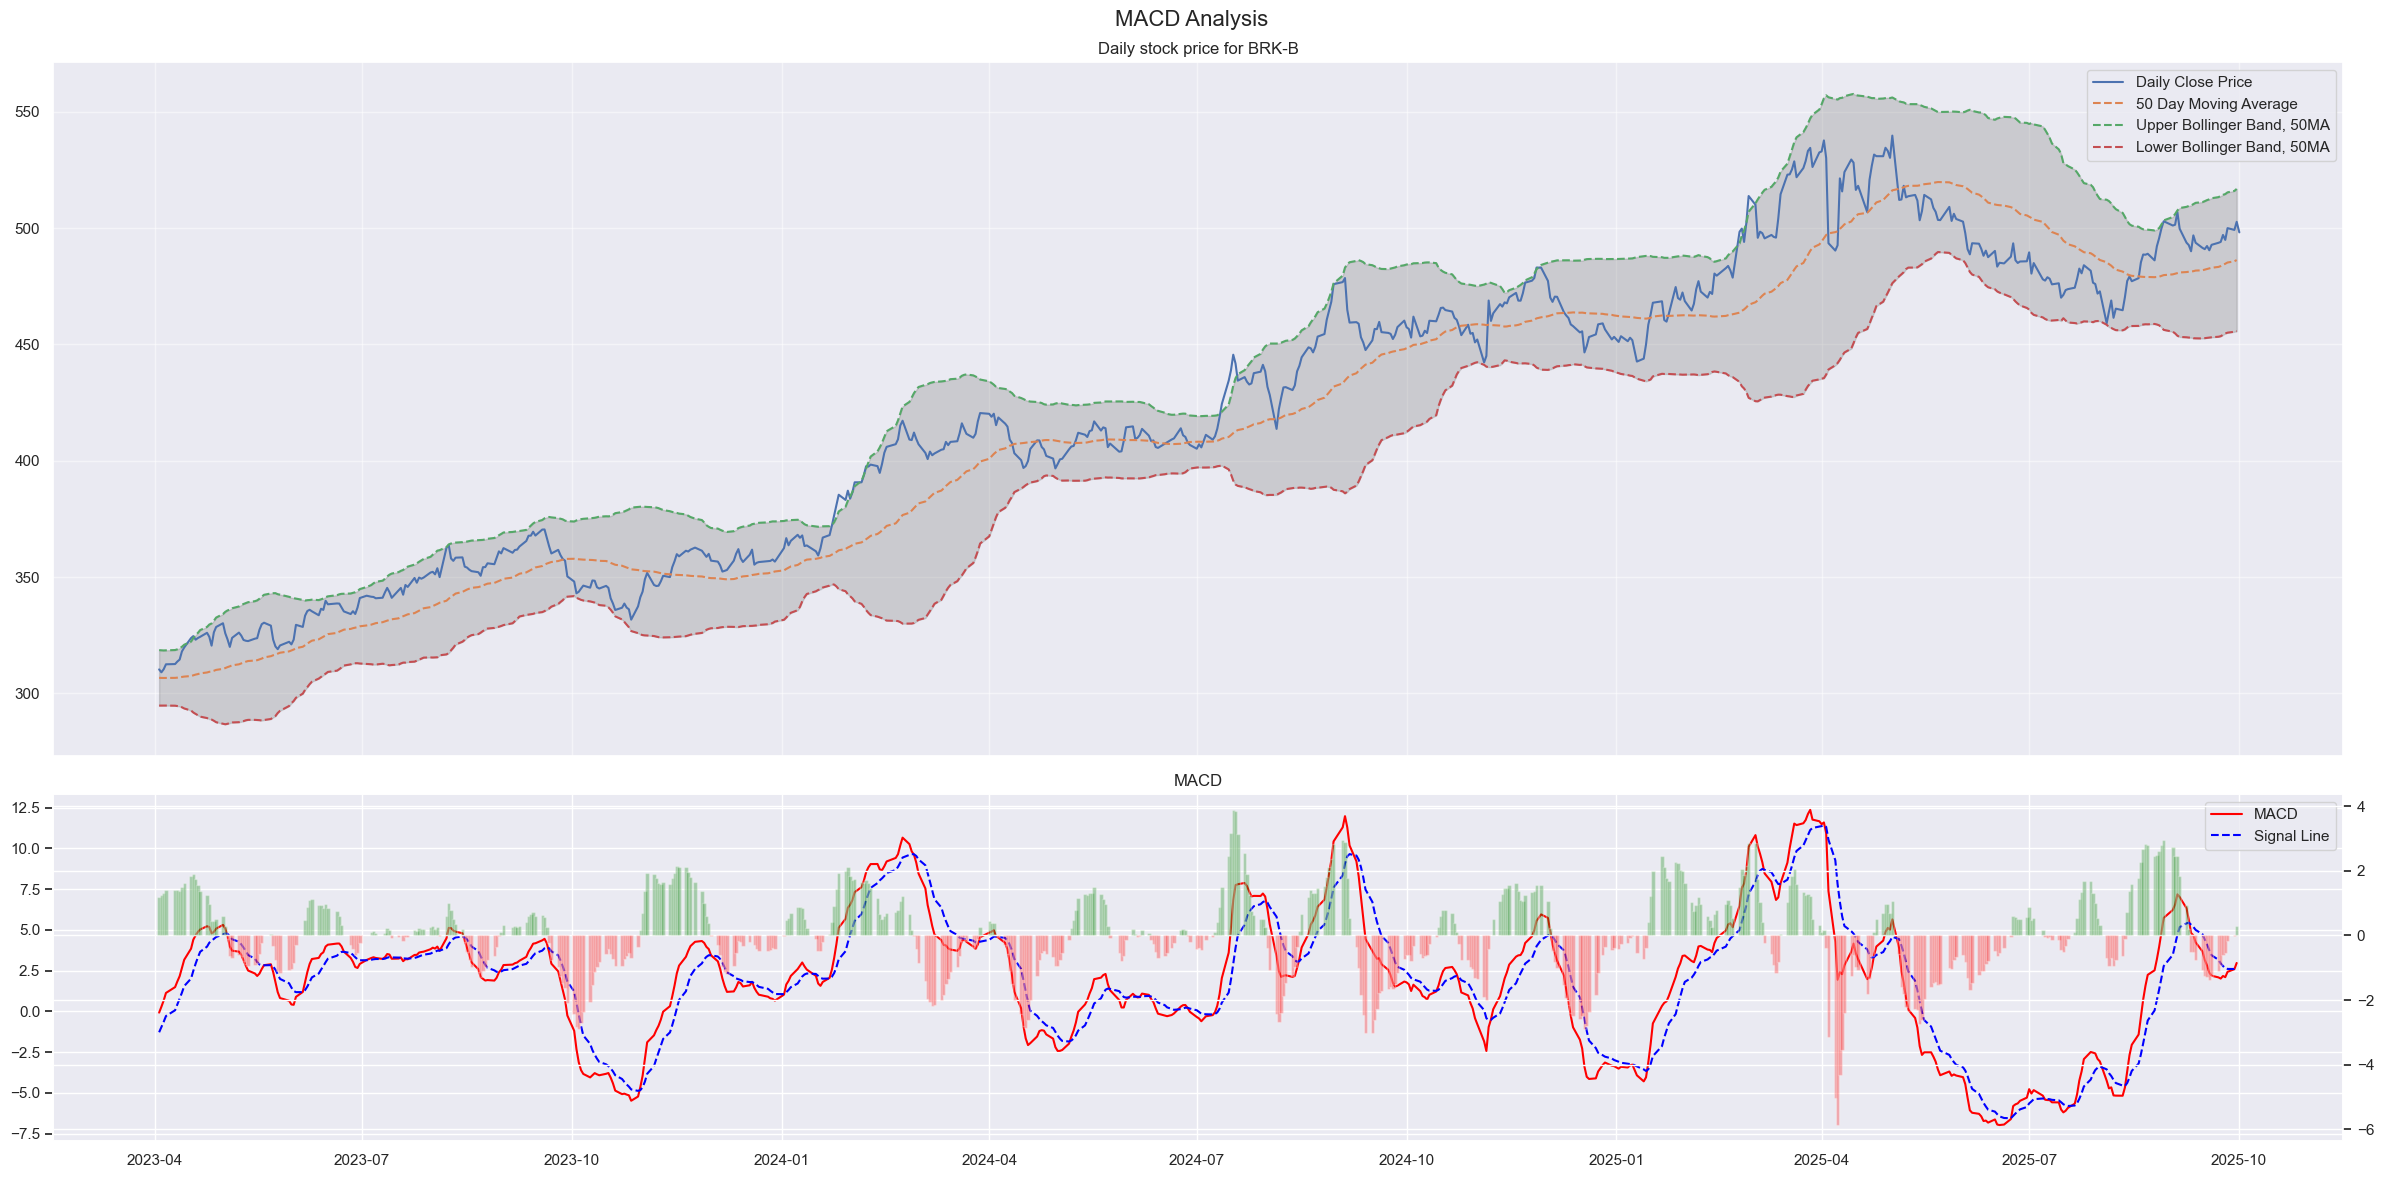

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  482.92
Regression price since 2020:  518.48


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  519.76
Current RSI: 52.04 
Current MACD Divergence: 0.16 
Tomorrow inferred RSI: 57.82 
Tomorrow inferred MACD Divergence: 0.04 


In [6]:
# 8/4/2025 min 455.19; 2/3/2025 454.60; 1/10/2025 440.10; 11/4/2024 437.90; 
# 486 support break; 20lbb break; 200MA break; 50lbb hold
# 433 / 453 strong supp; 20wk MA -> 40wk MA good supp
stock_name = 'brk-b'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 917.34
* Recent high: 1075.34
* Current stock price is at 85.31% of recent high
Latest 5 Day MA: 929.41
Latest 5 Day EMA: 928.35
Latest 20 Day MA: 951.07
Latest Lower Bollinger Band, 20MA: 917.42
Latest Higher Bollinger Band, 20MA: 984.72
Latest 50 Day MA: 954.52
Latest Lower Bollinger Band, 50MA: 906.19
Latest Higher Bollinger Band, 50MA: 1002.85
Latest 50 Day EMA: 956.02
Latest 120 Day MA: 976.85
Latest 200 Day MA: 972.78
Latest 200 Day EMA: 951.13
Latest 10 Week MA: 953.15
Latest 20 Week MA: 969.05
Latest 30 Week MA: 966.52
Latest 40 Week MA: 971.1
Latest Lower Weekly Bollinger Band, 20MA: 909.02
Latest Higher Weekly Bollinger Band, 20MA: 1029.07

Latest RSI: 34.54 
Latest MACD Divergence: -3.77 
5MA break point: 925.44
5MA crosses 20MA at 1088.19
20MA break point: 951.14
20MA crosses 50MA at 1071.21
20MA Lower Bollinger Band break point: 910.99
20MA Upper Bollinger Band break point: 991.28
50MA break point: 954.81
50MA crosses 200MA at 2140.71
50MA Lower Boll

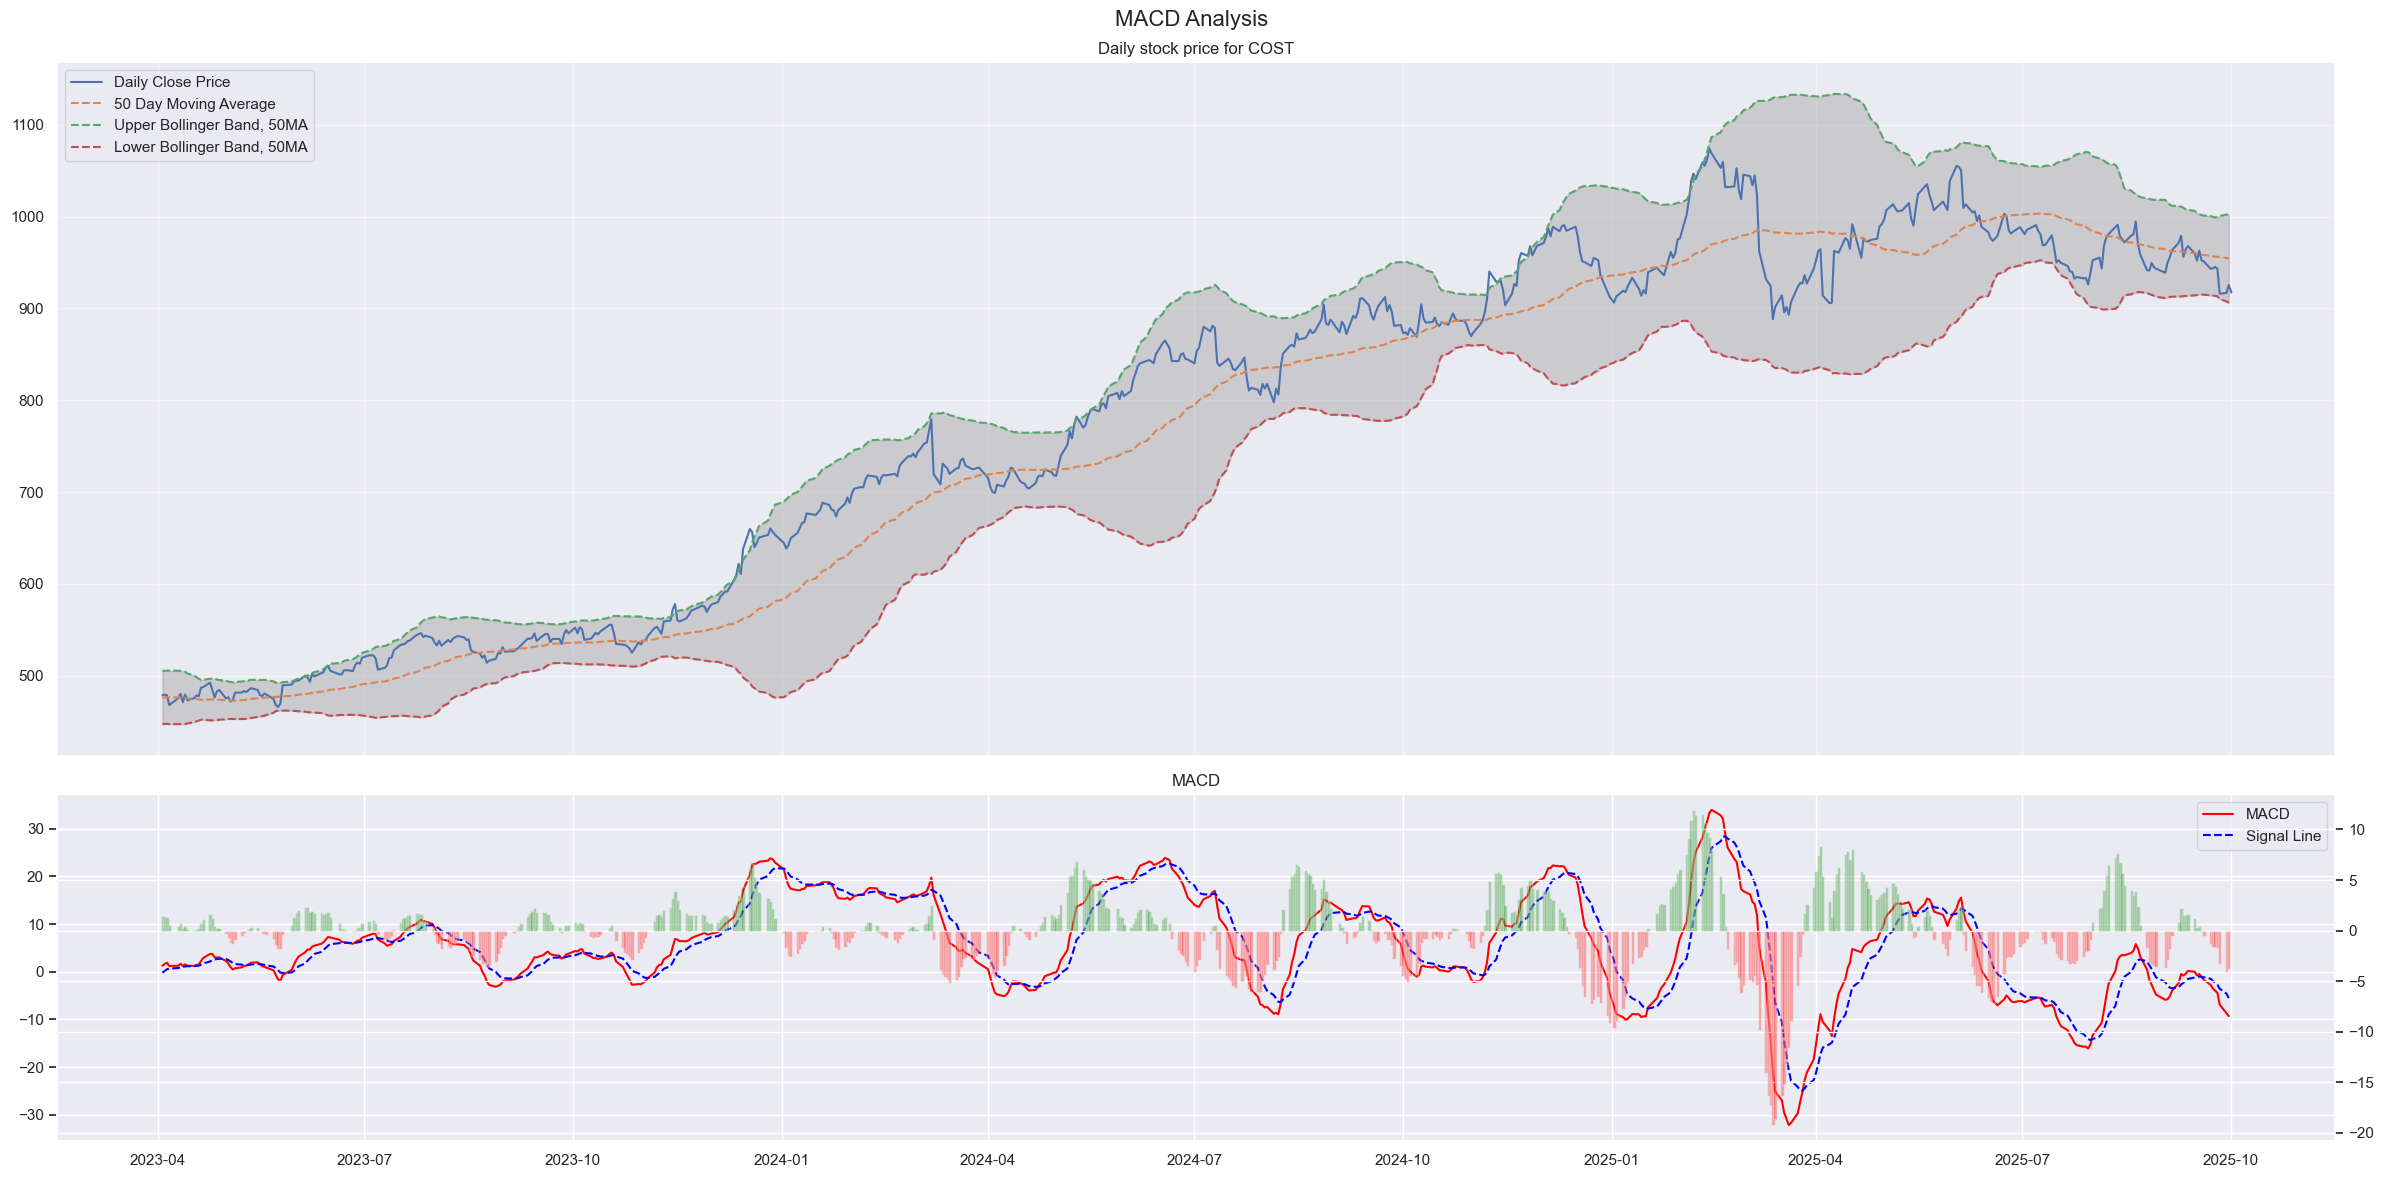

[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  1030.05


[*********************100%***********************]  1 of 1 completed


Regression price since 2020:  1055.27


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  1056.47
Current RSI: 26.38 
Current MACD Divergence: -3.84 
Tomorrow inferred RSI: 23.63 
Tomorrow inferred MACD Divergence: -3.63 


In [7]:
# Very strong supp: 793 - 783
# 9/25/2025 905.05, 4/7/2025 871.71, 10/2/2024 867.16 - support 880, 8/5/2024 793.00
# 50ma break; 120MA break; 20LBB break; 200MA break; 50LBB hold
# 20wk ma good most of time

stock_name = 'cost'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap(start_date='2025-04-01') # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
    # stg.atr_drawdown_thresholds() # use this after breakout to confirm
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 227.29
* Recent high: 258.14
* Current stock price is at 88.05% of recent high
Latest 5 Day MA: 228.2
Latest 5 Day EMA: 228.48
Latest 20 Day MA: 228.53
Latest Lower Bollinger Band, 20MA: 224.13
Latest Higher Bollinger Band, 20MA: 232.94
Latest 50 Day MA: 232.82
Latest Lower Bollinger Band, 50MA: 219.98
Latest Higher Bollinger Band, 50MA: 245.66
Latest 50 Day EMA: 232.52
Latest 120 Day MA: 240.62
Latest 200 Day MA: 232.69
Latest 200 Day EMA: 229.81
Latest 10 Week MA: 231.04
Latest 20 Week MA: 239.09
Latest 30 Week MA: 239.71
Latest 40 Week MA: 234.63
Latest Lower Weekly Bollinger Band, 20MA: 220.4
Latest Higher Weekly Bollinger Band, 20MA: 257.78

Latest RSI: 52.78 
Latest MACD Divergence: 0.48 
5MA break point: 228.4
5MA crosses 20MA at 227.91
20MA break point: 228.32
20MA crosses 50MA at 368.86
20MA Lower Bollinger Band break point: 223.56
20MA Upper Bollinger Band break point: 233.09
50MA break point: 232.63
50MA crosses 200MA at 244.89
50MA Lower Bollinger Ban

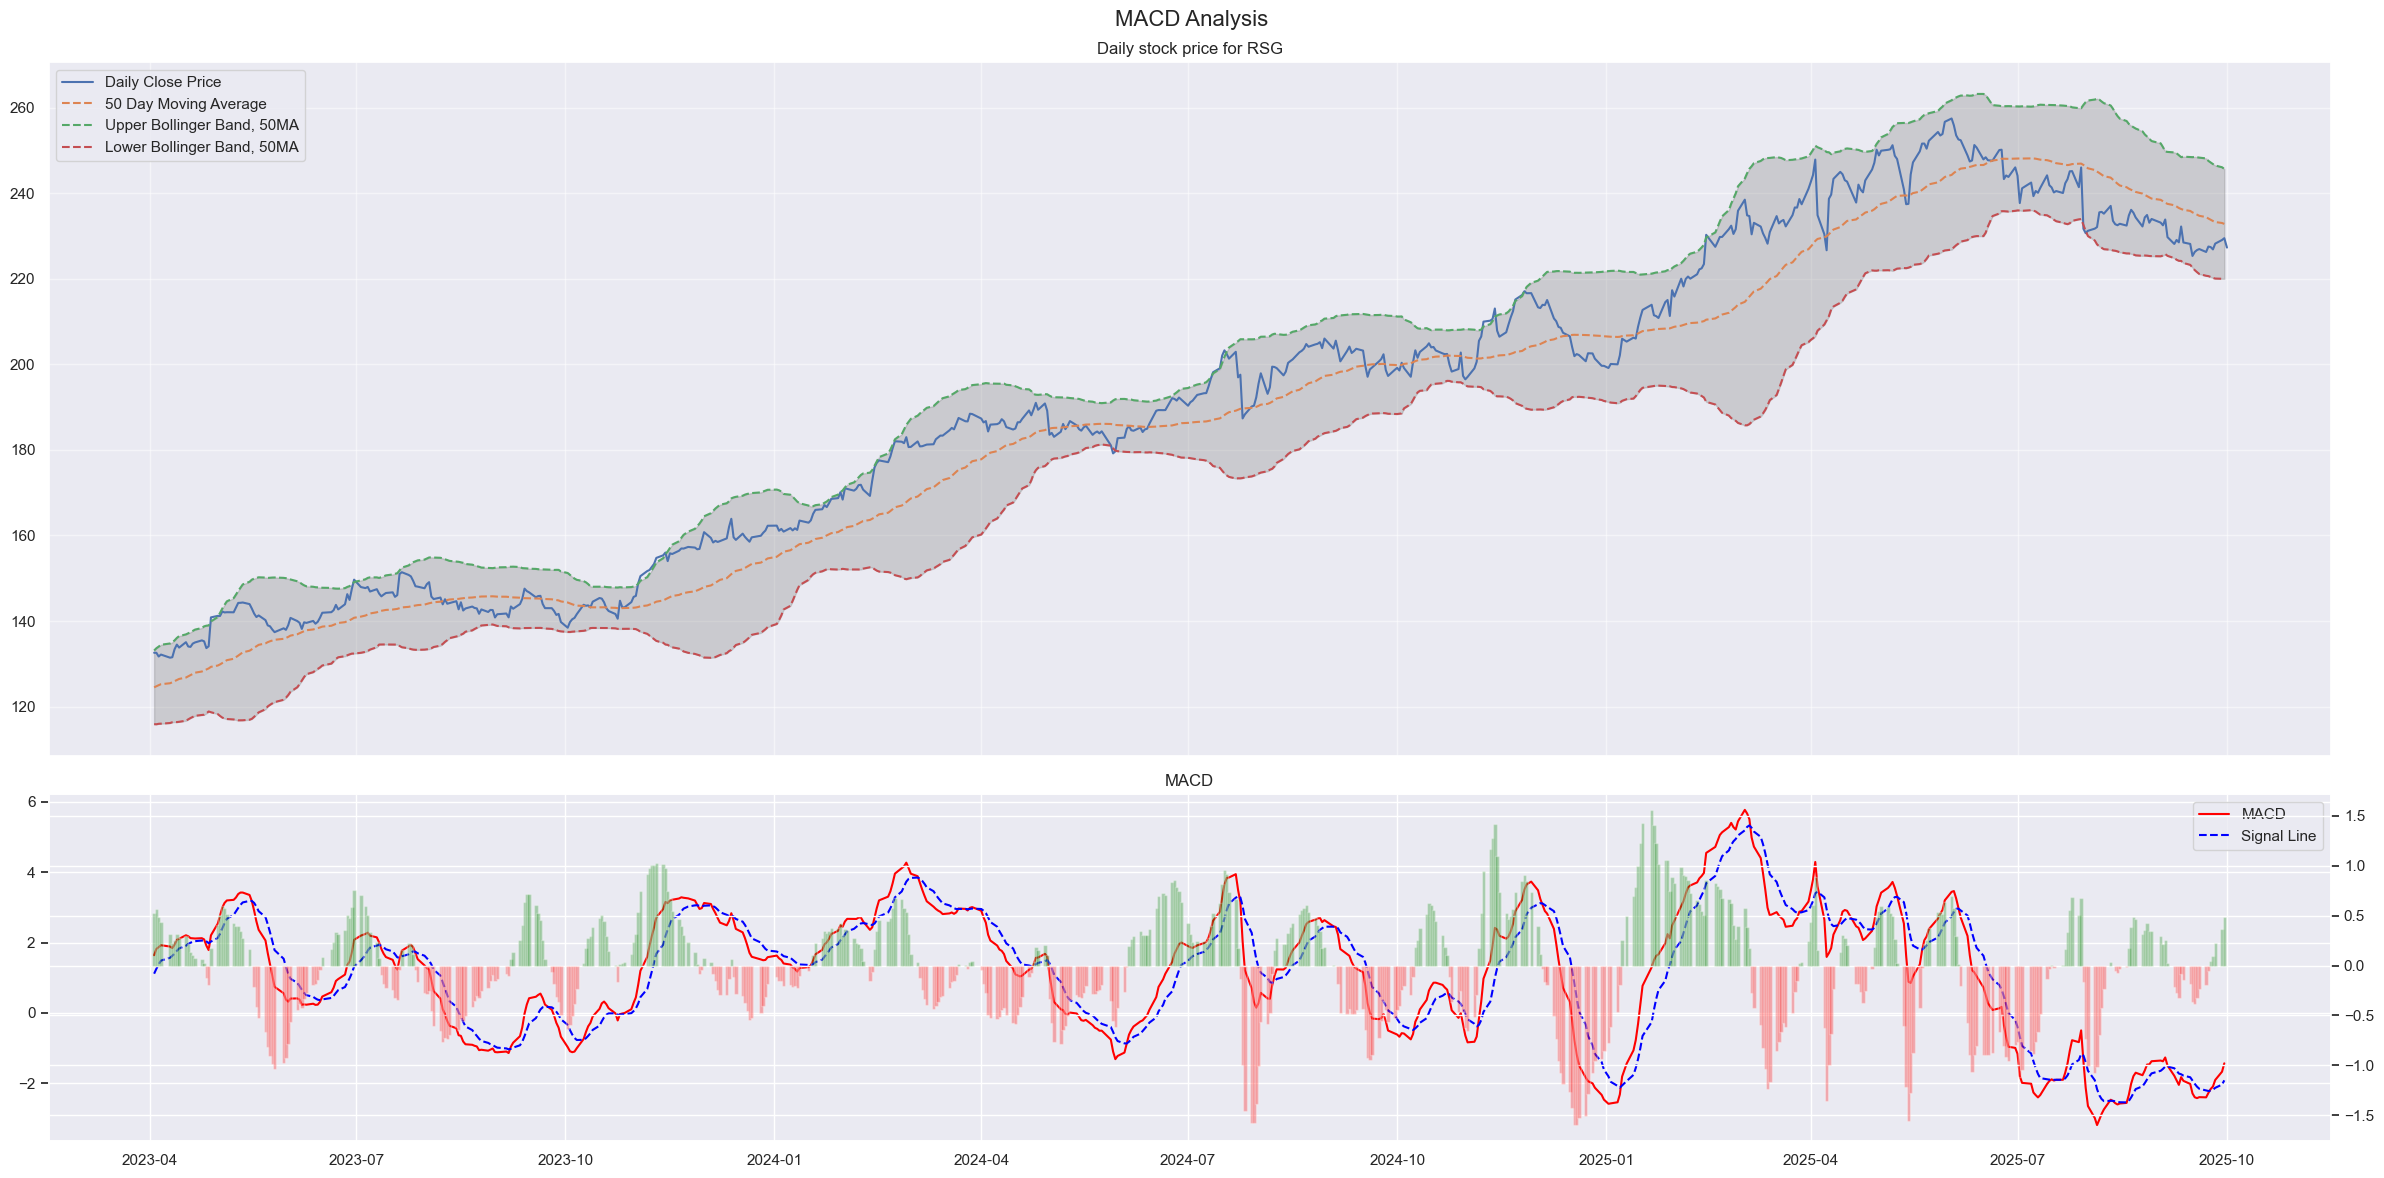

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  238.48
Regression price since 2020:  247.42


[*********************100%***********************]  1 of 1 completed


Regression price since QE:  248.22
Current RSI: 34.55 
Current MACD Divergence: 0.41 
Tomorrow inferred RSI: 45.12 
Tomorrow inferred MACD Divergence: 0.36 


In [8]:
# 20wk MA good supp
# 9/23/2025 224.62, 4/8/2025 224.13
stock_name = 'rsg'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 219.87
* Recent high: 240.84
* Current stock price is at 91.29% of recent high
Latest 5 Day MA: 219.11
Latest 5 Day EMA: 219.25
Latest 20 Day MA: 218.35
Latest Lower Bollinger Band, 20MA: 213.34
Latest Higher Bollinger Band, 20MA: 223.35
Latest 50 Day MA: 224.3
Latest Lower Bollinger Band, 50MA: 209.86
Latest Higher Bollinger Band, 50MA: 238.75
Latest 50 Day EMA: 222.59
Latest 120 Day MA: 227.54
Latest 200 Day MA: 223.44
Latest 200 Day EMA: 222.02
Latest 10 Week MA: 223.32
Latest 20 Week MA: 227.19
Latest 30 Week MA: 227.18
Latest 40 Week MA: 224.62
Latest Lower Weekly Bollinger Band, 20MA: 214.22
Latest Higher Weekly Bollinger Band, 20MA: 240.16

Latest RSI: 59.85 
Latest MACD Divergence: 0.72 
5MA break point: 219.03
5MA crosses 20MA at 212.98
20MA break point: 218.07
20MA crosses 50MA at 420.27
20MA Lower Bollinger Band break point: 212.87
20MA Upper Bollinger Band break point: 223.27
50MA break point: 224.26
50MA crosses 200MA at 173.21
50MA Lower Bollinger B

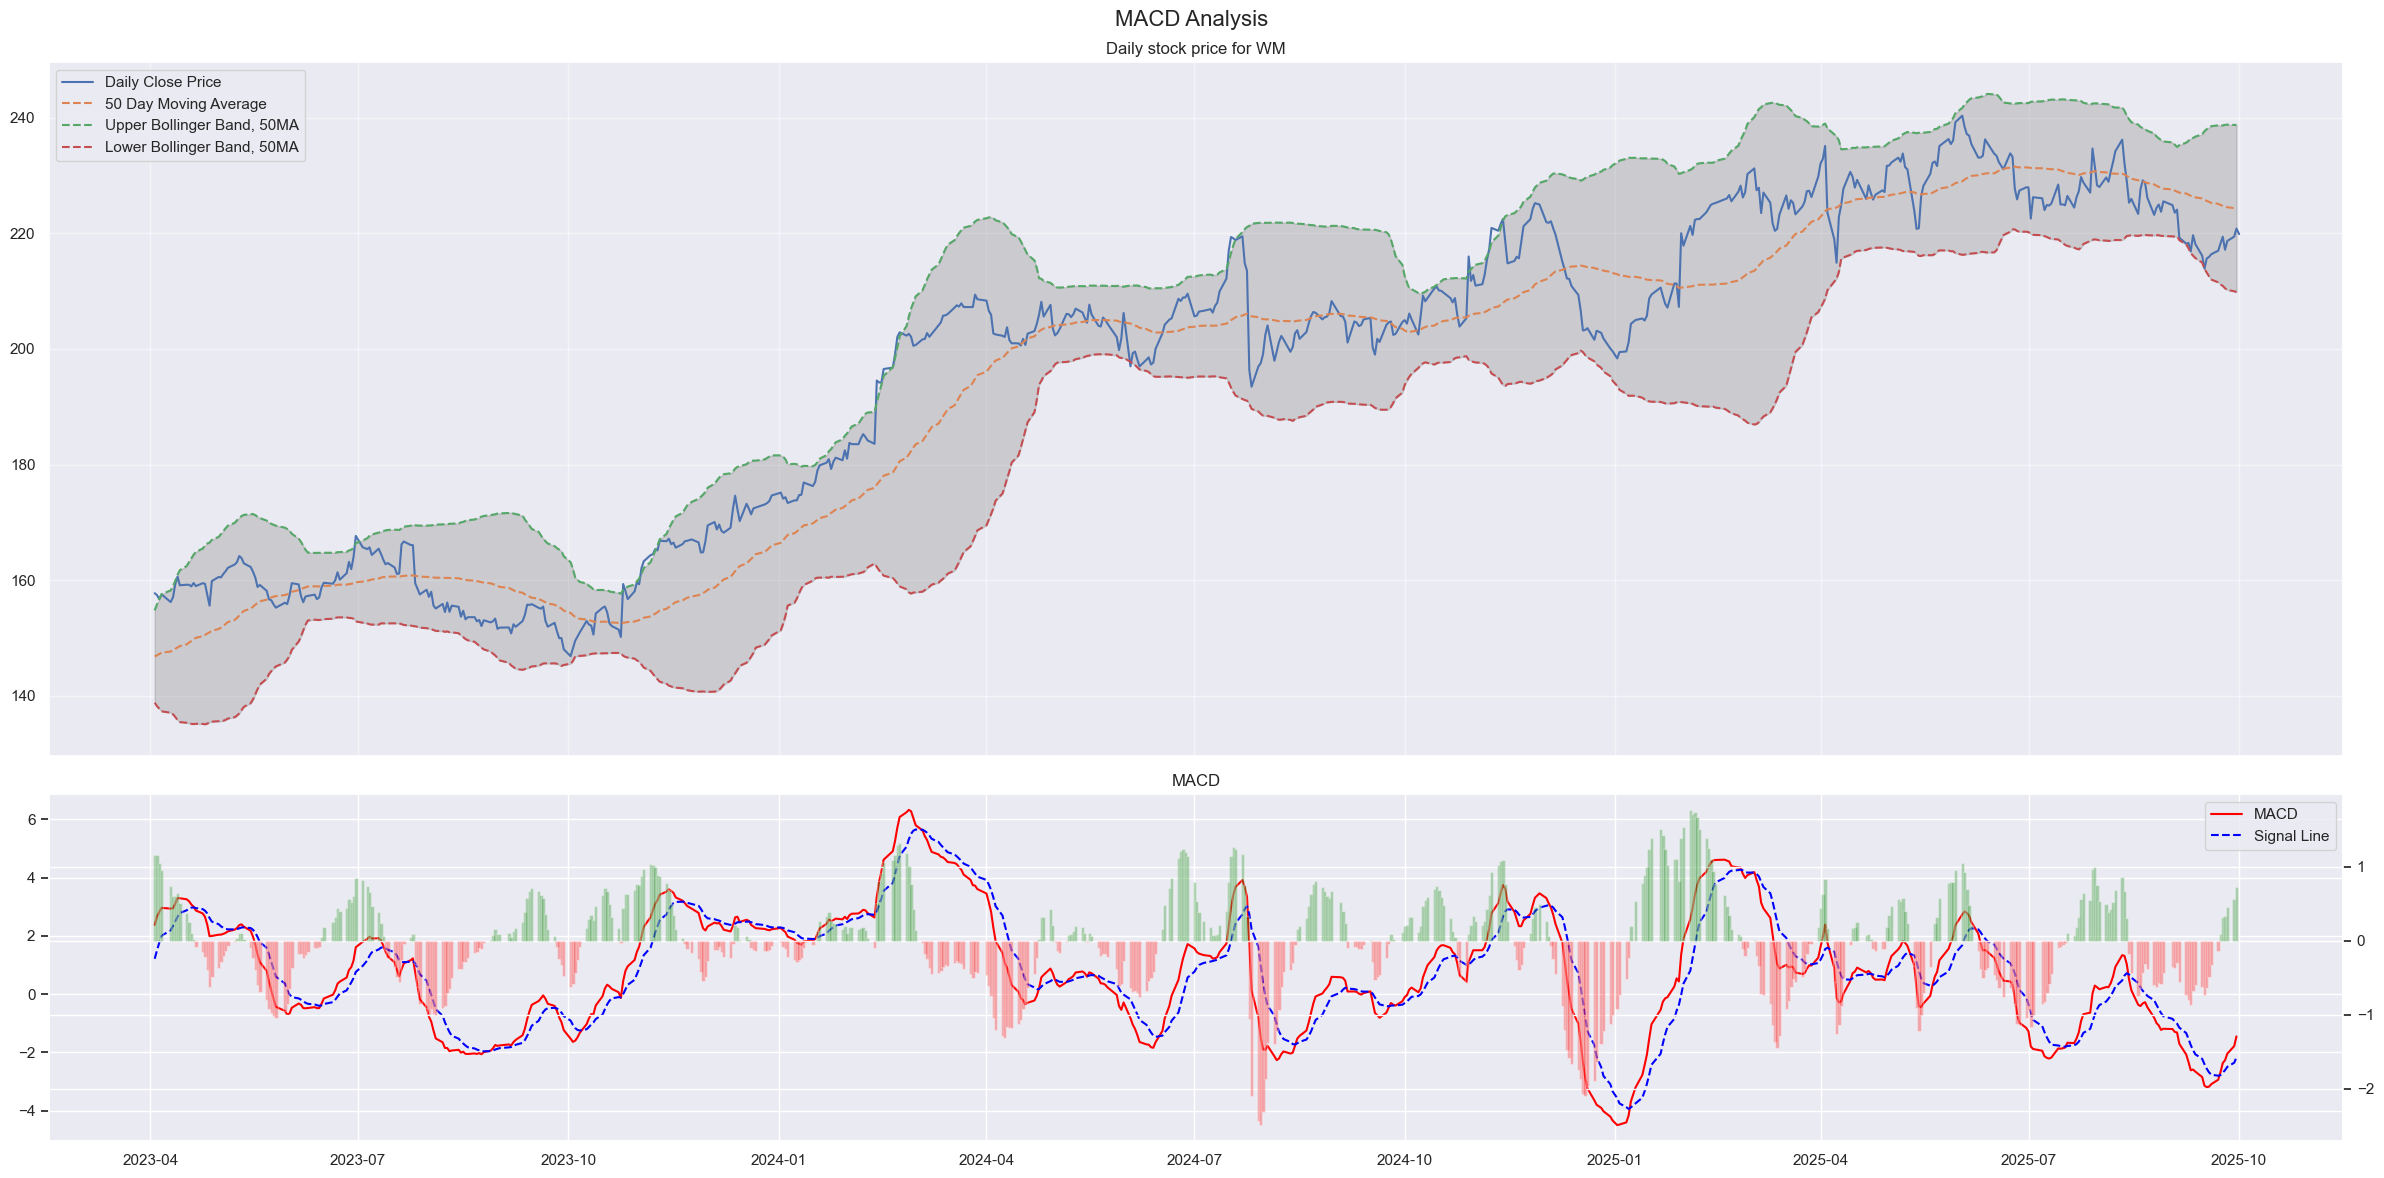

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  242.21
Regression price since 2020:  238.15


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  238.63
Current RSI: 50.53 
Current MACD Divergence: 0.74 
Tomorrow inferred RSI: 55.12 
Tomorrow inferred MACD Divergence: 0.73 


In [9]:
# 40Wk MA good supp
# 9/16/2025 213.72, 4/9/2025 213.50
stock_name = 'wm'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 614.57
* Recent high: 613.51
* Current stock price is at 100.17% of recent high
Latest 5 Day MA: 608.71
Latest 5 Day EMA: 609.8
Latest 20 Day MA: 603.58
Latest Lower Bollinger Band, 20MA: 589.95
Latest Higher Bollinger Band, 20MA: 617.21
Latest 50 Day MA: 592.3
Latest Lower Bollinger Band, 50MA: 564.3
Latest Higher Bollinger Band, 50MA: 620.3
Latest 50 Day EMA: 591.96
Latest 120 Day MA: 559.3
Latest 200 Day MA: 548.75
Latest 200 Day EMA: 553.8
Latest 10 Week MA: 595.35
Latest 20 Week MA: 576.33
Latest 30 Week MA: 552.44
Latest 40 Week MA: 550.06
Latest Lower Weekly Bollinger Band, 20MA: 526.31
Latest Higher Weekly Bollinger Band, 20MA: 626.36

Latest RSI: 71.22 
Latest MACD Divergence: -0.11 
5MA break point: 608.95
5MA crosses 20MA at 579.48
20MA break point: 604.29
20MA crosses 50MA at 223.09
20MA Lower Bollinger Band break point: 589.92
20MA Upper Bollinger Band break point: 618.67
50MA break point: 592.63
50MA Lower Bollinger Band break point: 562.65
50MA Upp

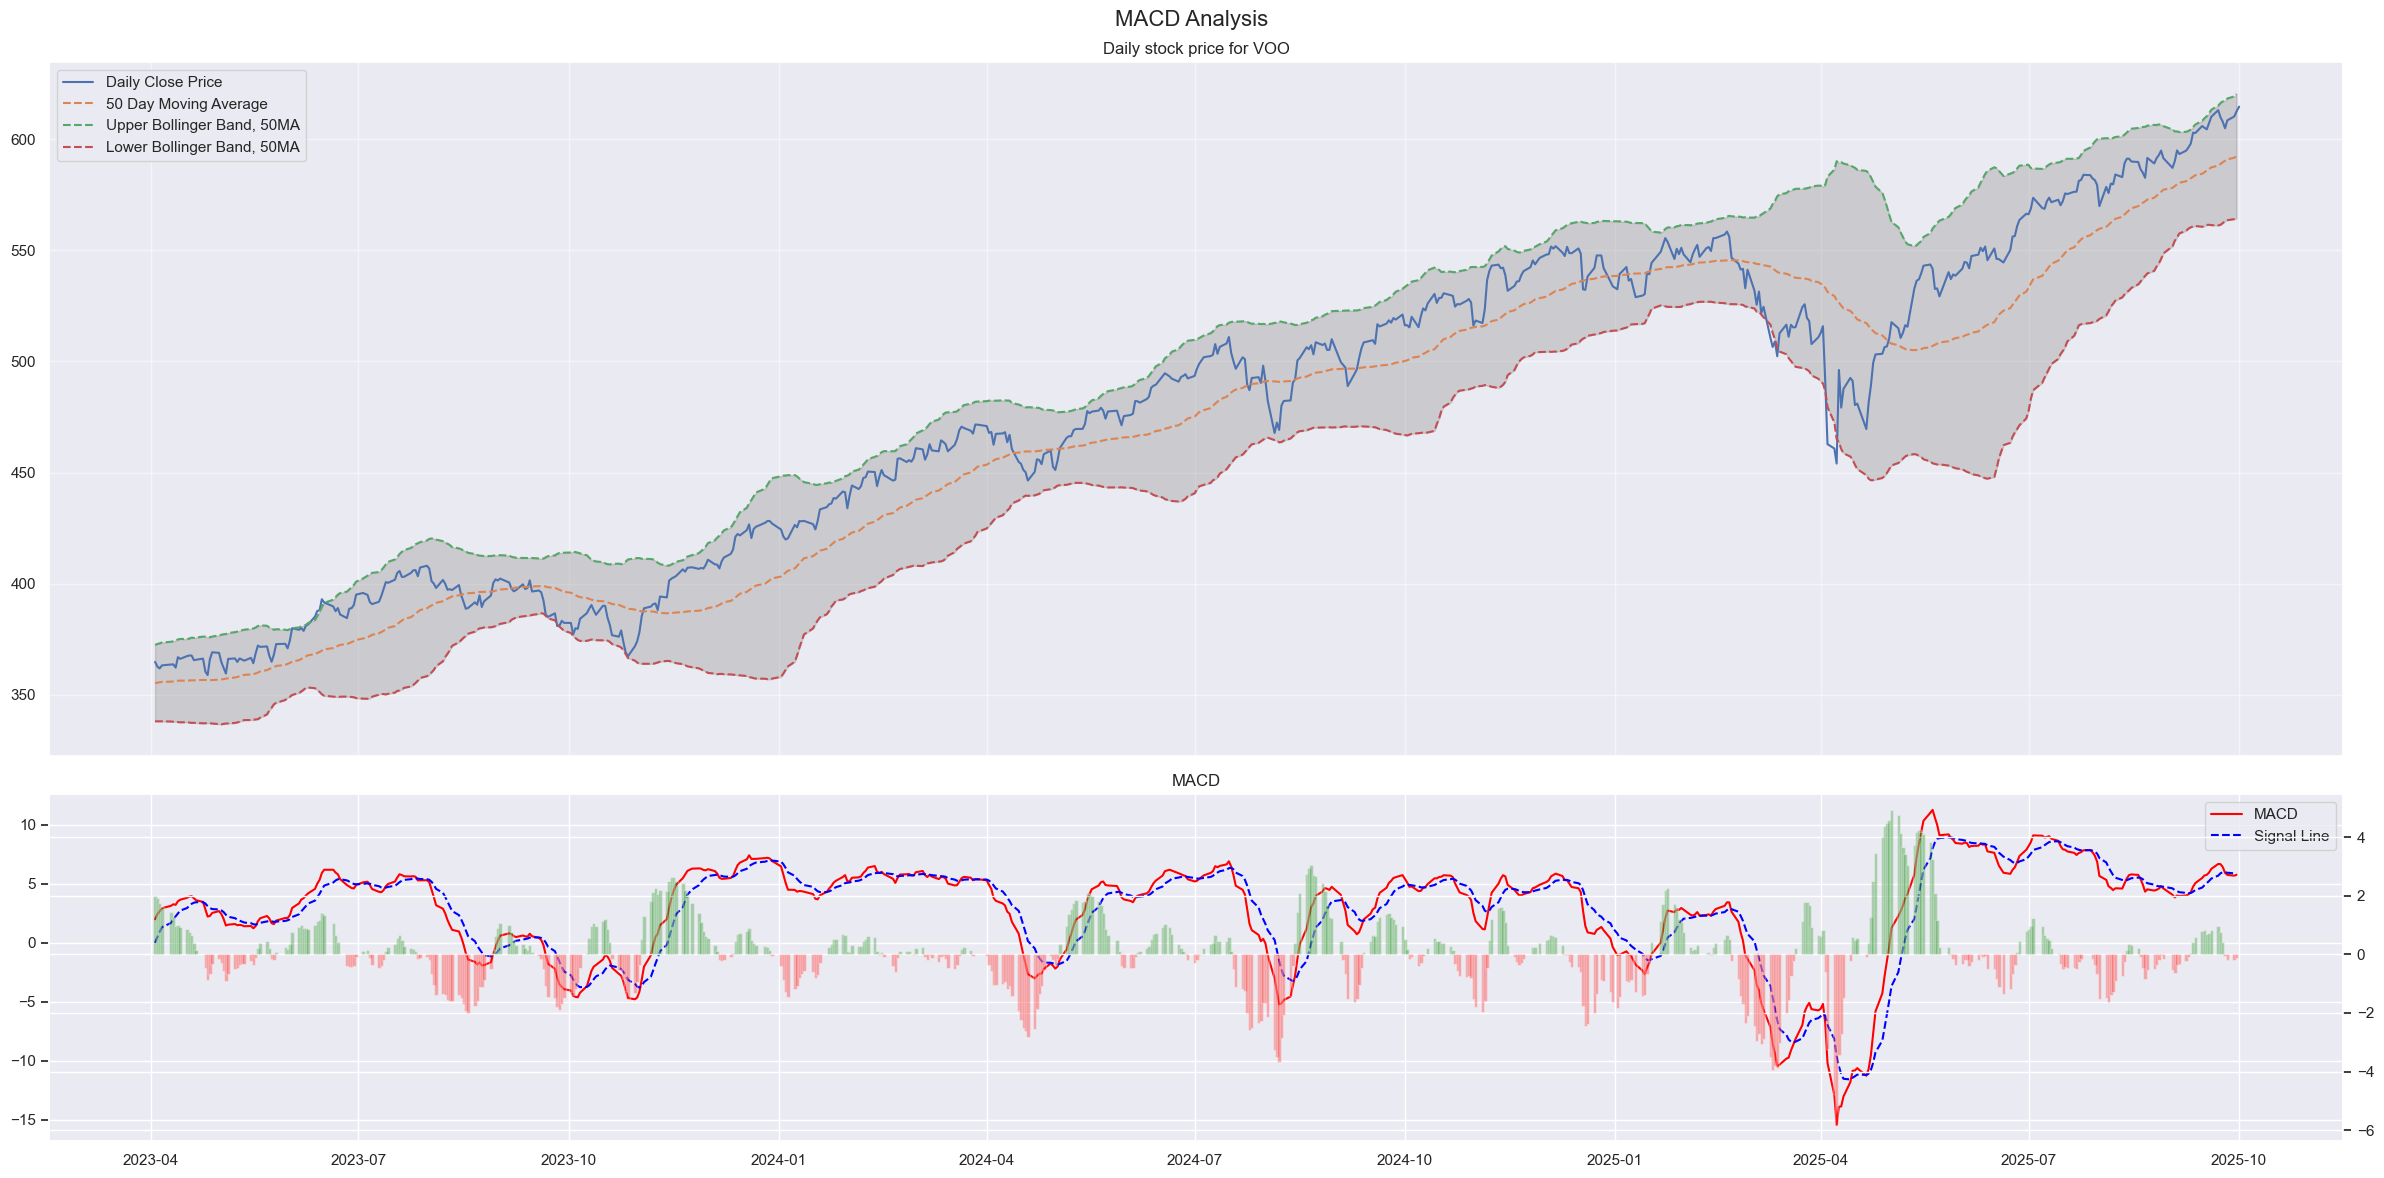

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  560.15
Regression price since 2020:  564.74


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  564.36
Current RSI: 68.75 
Current MACD Divergence: 0.04 
Tomorrow inferred RSI: 69.03 
Tomorrow inferred MACD Divergence: 0.08 


In [10]:
# Strong supp: 473 - 470.7
# 452 based on maximal drawback ()/0.9, also regression and drawback ()/0.95, also support
# next support 428
# 4/7/2025 low 442.80; 2024/4/19 453.90 last min before increase
stock_name = 'voo'
# stock_name = '^GSPC' # sp500

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 284.62
* Recent high: 282.89
* Current stock price is at 100.61% of recent high
Latest 5 Day MA: 279.5
Latest 5 Day EMA: 279.99
Latest 20 Day MA: 272.86
Latest Lower Bollinger Band, 20MA: 258.82
Latest Higher Bollinger Band, 20MA: 286.89
Latest 50 Day MA: 266.76
Latest Lower Bollinger Band, 50MA: 249.22
Latest Higher Bollinger Band, 50MA: 284.3
Latest 50 Day EMA: 266.44
Latest 120 Day MA: 245.83
Latest 200 Day MA: 237.5
Latest 200 Day EMA: 242.99
Latest 10 Week MA: 268.42
Latest 20 Week MA: 257.07
Latest 30 Week MA: 240.66
Latest 40 Week MA: 238.24
Latest Lower Weekly Bollinger Band, 20MA: 225.51
Latest Higher Weekly Bollinger Band, 20MA: 288.62

Latest RSI: 73.63 
Latest MACD Divergence: 0.52 
5MA break point: 279.76
5MA crosses 20MA at 240.01
20MA break point: 273.48
20MA crosses 50MA at 59.48
20MA Lower Bollinger Band break point: 258.12
20MA Upper Bollinger Band break point: 288.85
50MA break point: 266.93
50MA Lower Bollinger Band break point: 248.02
50MA Up

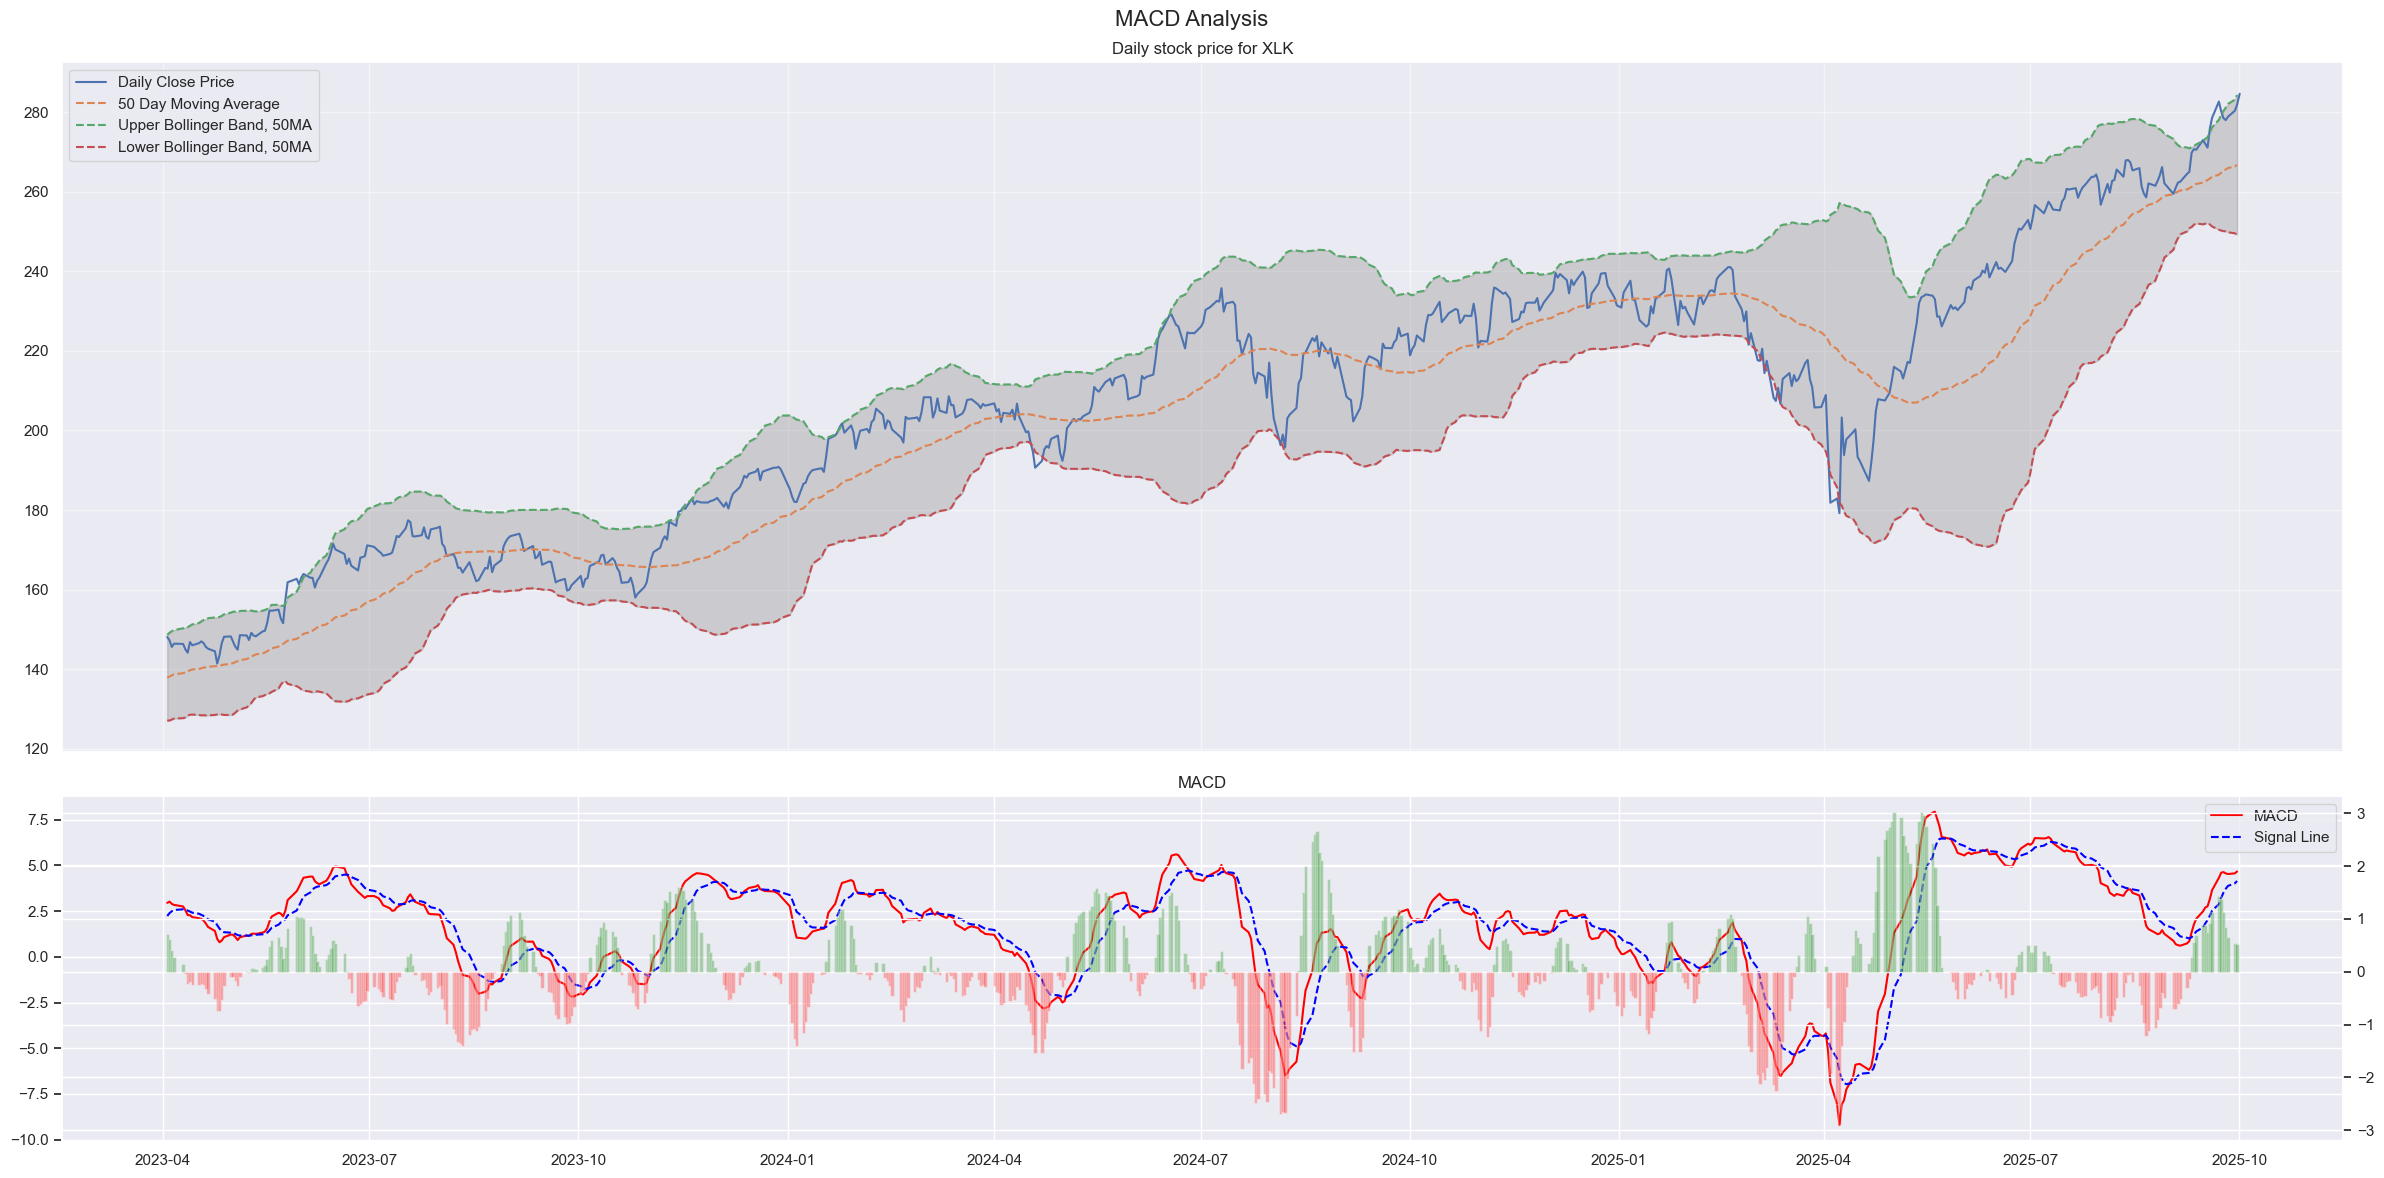

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  259.68
Regression price since 2020:  253.72


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  253.05
Current RSI: 75.41 
Current MACD Divergence: 0.61 
Tomorrow inferred RSI: 75.91 
Tomorrow inferred MACD Divergence: 0.6 


In [11]:
# 4/7/2025 172.45; 4/4/2025 182.69 - 1/5/2024 183.42, last min before increase; then 2023/10/26 159.50
# 183 supp
# massive buy at 200 based on regression drawback ()/0.9/0.95

stock_name = 'xlk'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 120.56
* Recent high: 122.3
* Current stock price is at 98.58% of recent high
Latest 5 Day MA: 120.71
Latest 5 Day EMA: 120.88
Latest 20 Day MA: 119.87
Latest Lower Bollinger Band, 20MA: 116.18
Latest Higher Bollinger Band, 20MA: 123.56
Latest 50 Day MA: 117.45
Latest Lower Bollinger Band, 50MA: 111.08
Latest Higher Bollinger Band, 50MA: 123.82
Latest 50 Day EMA: 117.16
Latest 120 Day MA: 109.09
Latest 200 Day MA: 103.98
Latest 200 Day EMA: 105.69
Latest 10 Week MA: 118.03
Latest 20 Week MA: 113.56
Latest 30 Week MA: 106.79
Latest 40 Week MA: 104.75
Latest Lower Weekly Bollinger Band, 20MA: 102.01
Latest Higher Weekly Bollinger Band, 20MA: 125.1

Latest RSI: 63.95 
Latest MACD Divergence: -0.14 
5MA break point: 120.66
5MA crosses 20MA at 117.11
20MA break point: 120.1
20MA crosses 50MA at 36.53
20MA Lower Bollinger Band break point: 116.48
20MA Upper Bollinger Band break point: 123.73
50MA break point: 117.55
50MA Lower Bollinger Band break point: 110.84
50MA Up

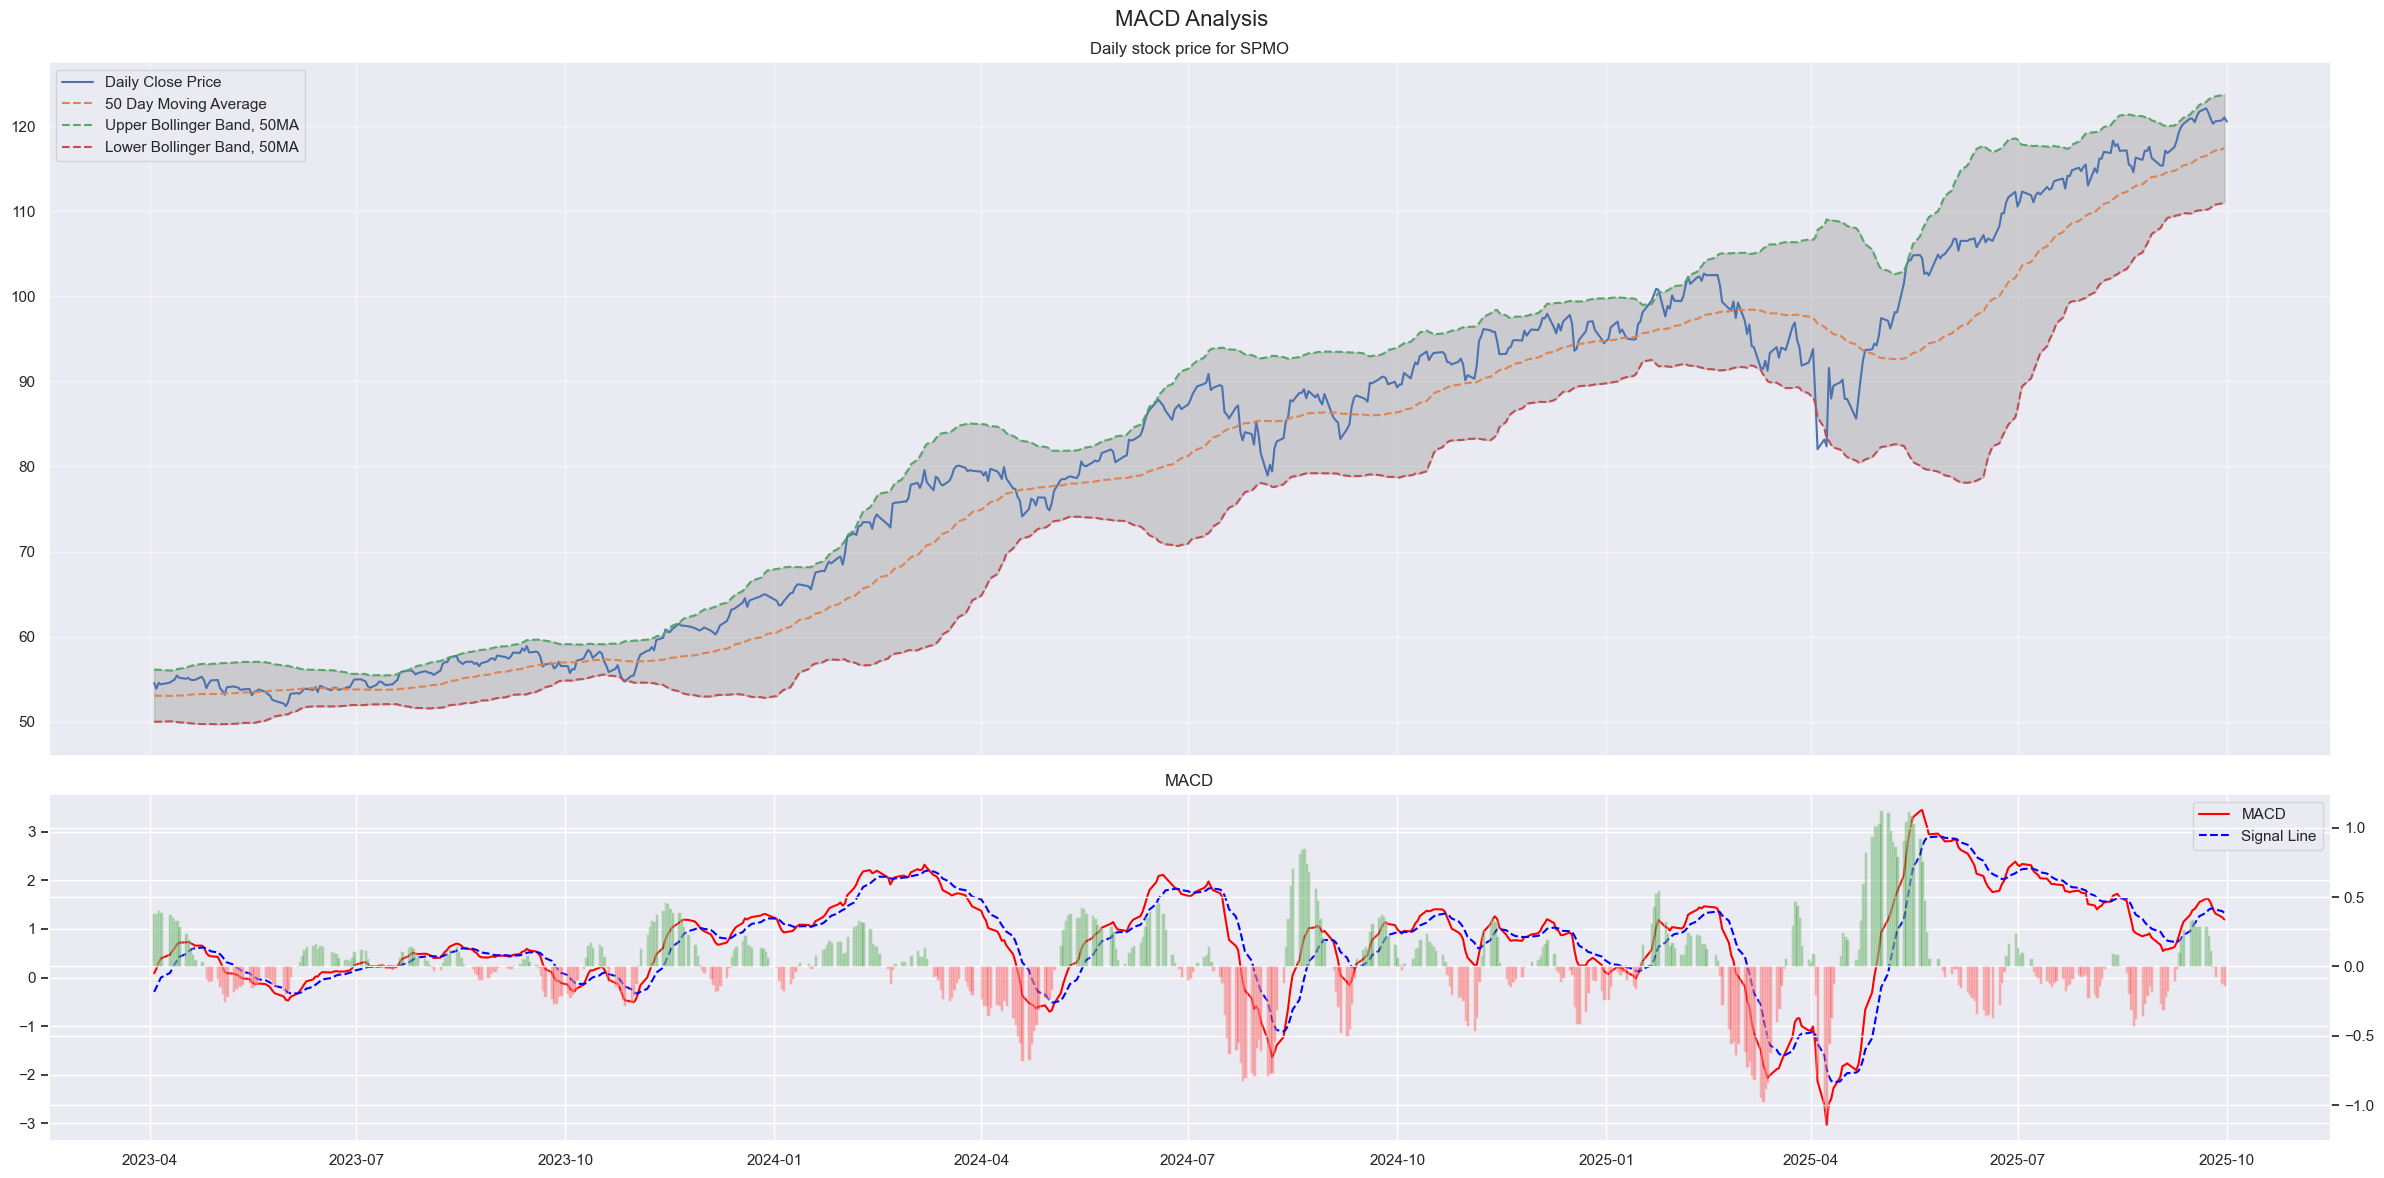

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  101.44
Regression price since 2020:  105.26


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  105.52
Current RSI: 55.04 
Current MACD Divergence: -0.18 
Tomorrow inferred RSI: 52.33 
Tomorrow inferred MACD Divergence: -0.21 


In [12]:
stock_name = 'spmo'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 143.47
* Recent high: 156.26
* Current stock price is at 91.82000000000001% of recent high
Latest 5 Day MA: 136.22
Latest 5 Day EMA: 136.91
Latest 20 Day MA: 136.81
Latest Lower Bollinger Band, 20MA: 134.57
Latest Higher Bollinger Band, 20MA: 139.04
Latest 50 Day MA: 135.05
Latest Lower Bollinger Band, 50MA: 128.46
Latest Higher Bollinger Band, 50MA: 141.64
Latest 50 Day EMA: 135.61
Latest 120 Day MA: 134.15
Latest 200 Day MA: 137.22
Latest 200 Day EMA: 136.97
Latest 10 Week MA: 135.61
Latest 20 Week MA: 134.3
Latest 30 Week MA: 135.27
Latest 40 Week MA: 137.12
Latest Lower Weekly Bollinger Band, 20MA: 128.43
Latest Higher Weekly Bollinger Band, 20MA: 140.16

Latest RSI: 58.76 
Latest MACD Divergence: -0.07 
5MA break point: 136.17
5MA crosses 20MA at 140.36
20MA break point: 136.84
20MA crosses 50MA at 79.87
20MA Lower Bollinger Band break point: 134.19
20MA Upper Bollinger Band break point: 139.49
50MA break point: 135.09
50MA crosses 200MA at 275.57
50MA Lower

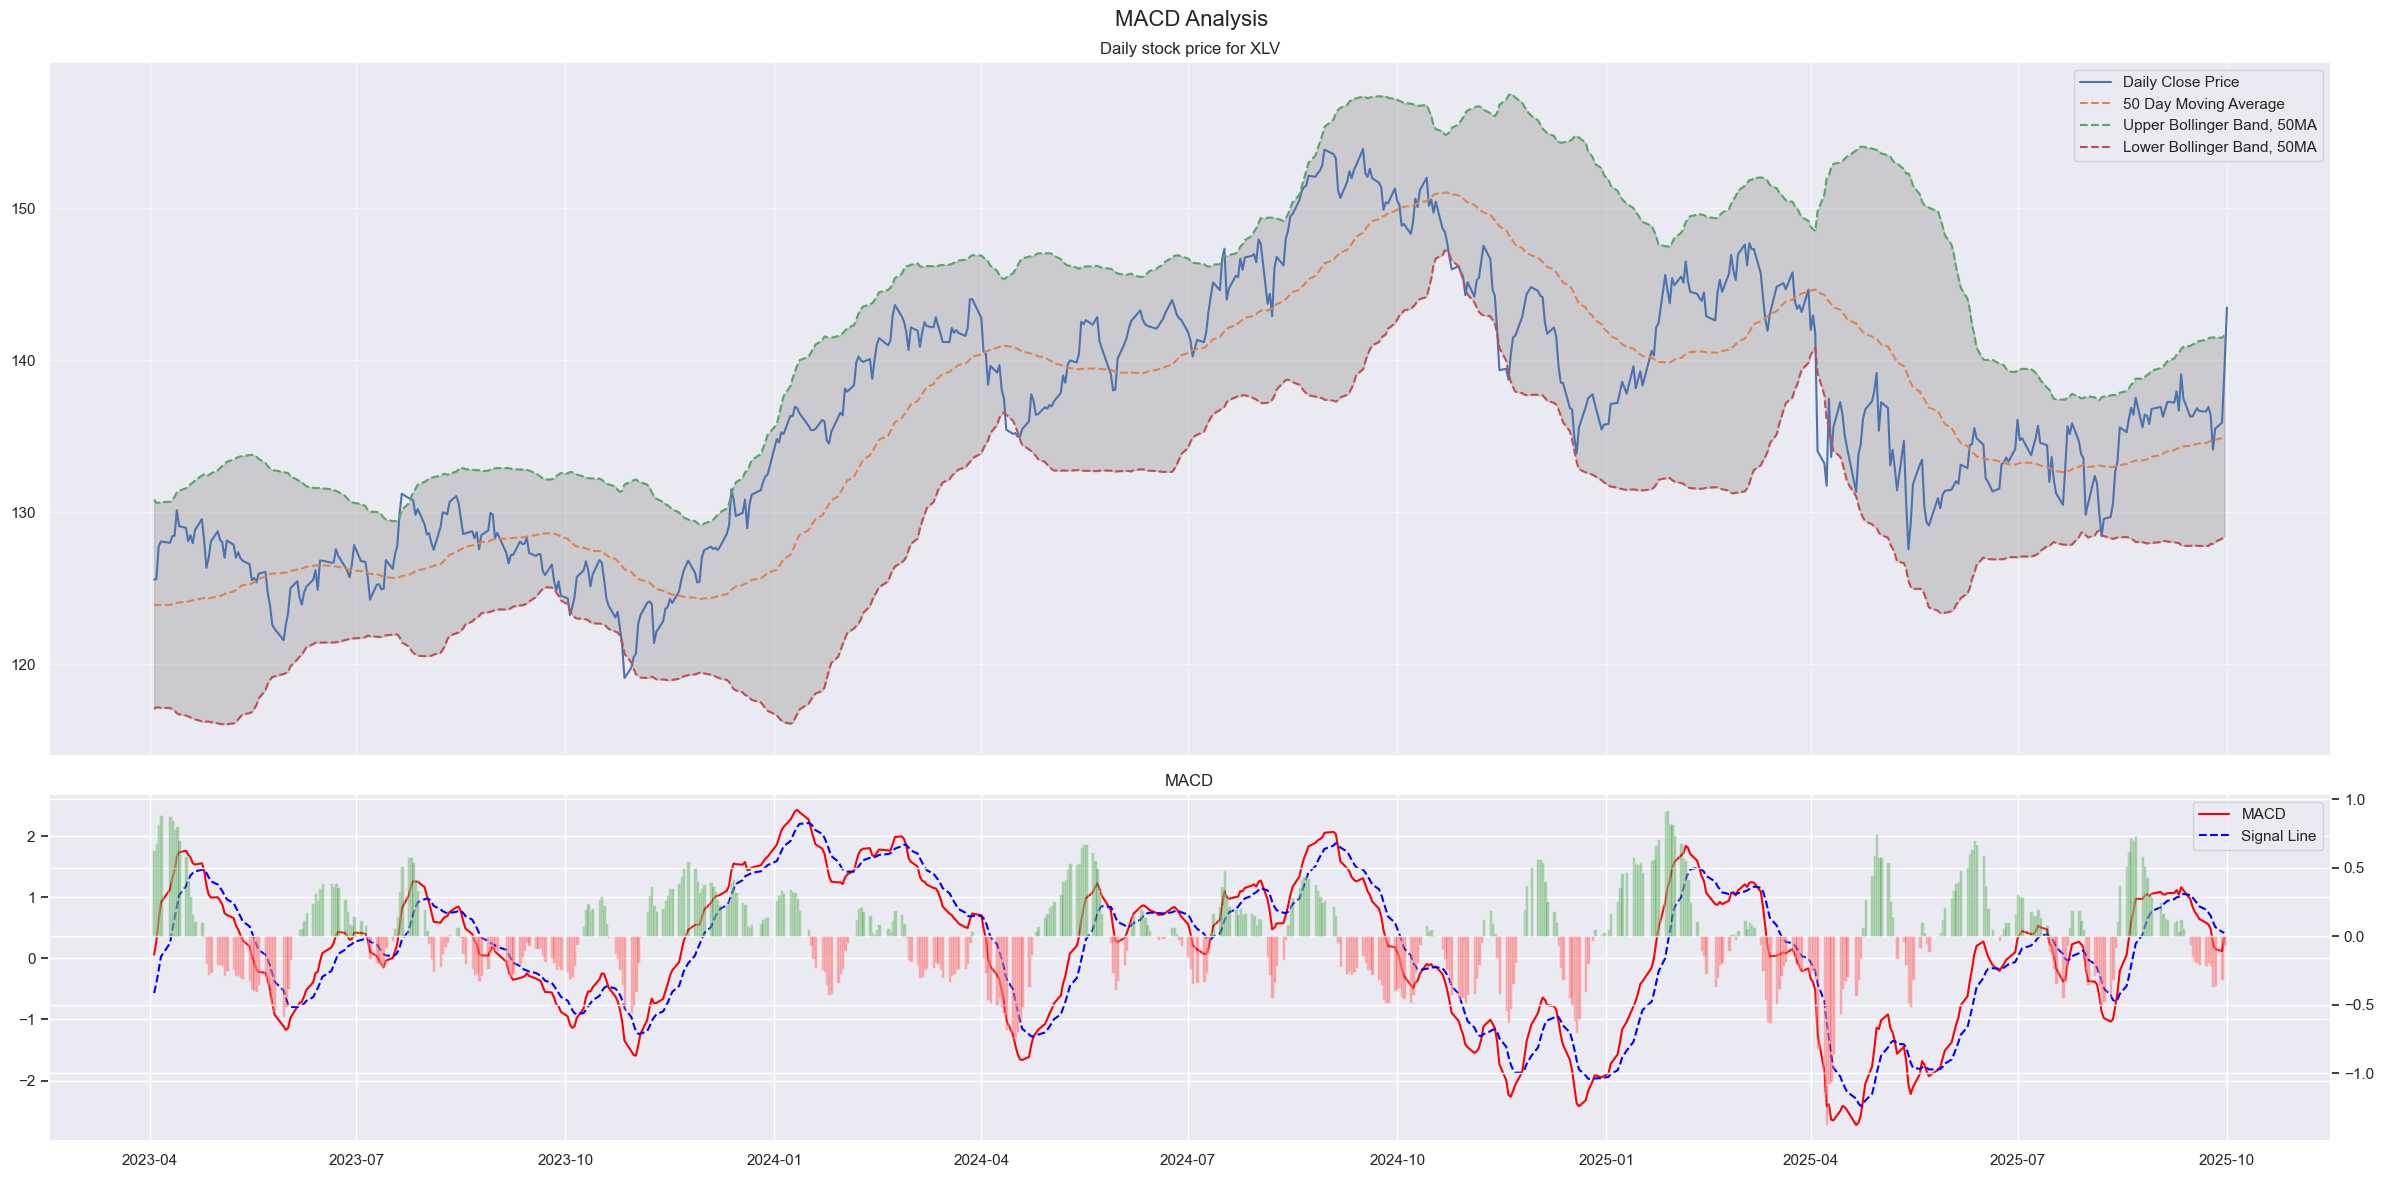

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  161.95
Regression price since 2020:  149.47


[*********************100%***********************]  1 of 1 completed


Regression price since QE:  148.69
Current RSI: 63.72 
Current MACD Divergence: 0.36 
Tomorrow inferred RSI: 70.81 
Tomorrow inferred MACD Divergence: 0.61 


In [13]:
# return limited, buy when > 5% below the regression
# 8/7/2025 min 127.96, 5/15/2025 127.35, 10/27/2023 low 122.59
# 126.73 maximal drawback
# 129 regression drawback
# 128 good supp; 134 good support
stock_name = 'xlv'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 255.45
* Recent high: 259.18
* Current stock price is at 98.56% of recent high
Latest 5 Day MA: 254.74
Latest 5 Day EMA: 253.95
Latest 20 Day MA: 243.12
Latest Lower Bollinger Band, 20MA: 223.84
Latest Higher Bollinger Band, 20MA: 262.41
Latest 50 Day MA: 230.09
Latest Lower Bollinger Band, 50MA: 193.35
Latest Higher Bollinger Band, 50MA: 266.83
Latest 50 Day EMA: 233.16
Latest 120 Day MA: 214.67
Latest 200 Day MA: 221.64
Latest 200 Day EMA: 220.43
Latest 10 Week MA: 235.21
Latest 20 Week MA: 219.9
Latest 30 Week MA: 215.03
Latest 40 Week MA: 220.28
Latest Lower Weekly Bollinger Band, 20MA: 180.83
Latest Higher Weekly Bollinger Band, 20MA: 258.98

Latest RSI: 82.77 
Latest MACD Divergence: 0.94 
5MA break point: 255.35
5MA crosses 20MA at 179.49
20MA break point: 243.37
20MA Lower Bollinger Band break point: 220.51
20MA Upper Bollinger Band break point: 266.23
50MA break point: 230.42
50MA Lower Bollinger Band break point: 190.72
50MA Upper Bollinger Band break p

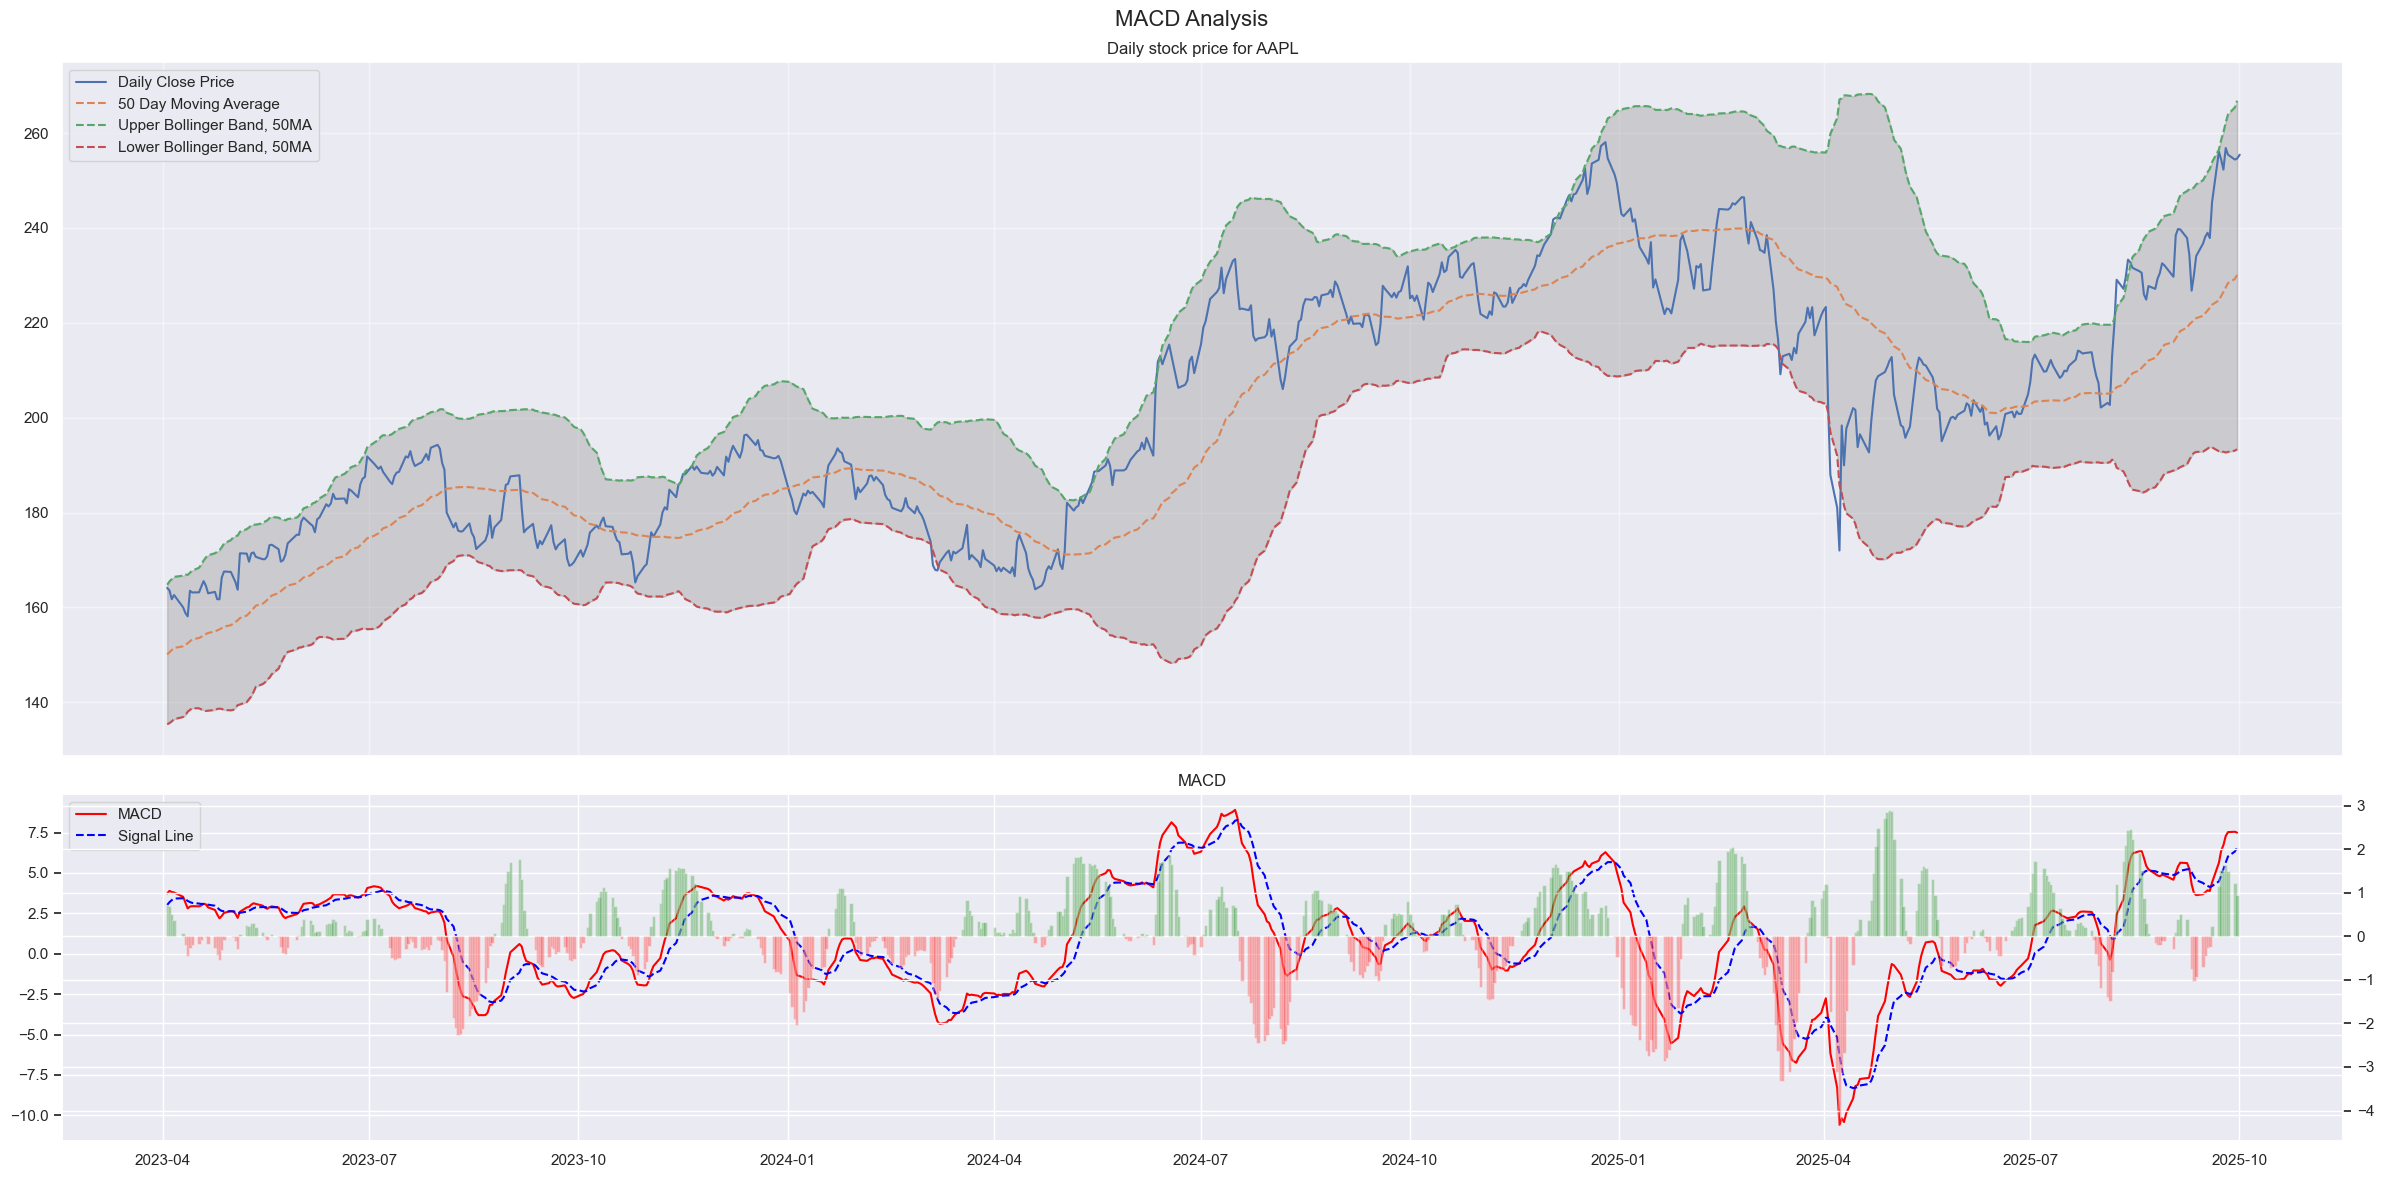

[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  264.58


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2020:  242.89
Regression price since QE:  240.79
Current RSI: 81.73 
Current MACD Divergence: 0.7 
Tomorrow inferred RSI: 79.68 
Tomorrow inferred MACD Divergence: 0.46 


In [14]:
# 185.6 - maximal drawback / 0.95; 186.6 - regression drawback / 0.95
# 174.6 maximal drawback since QE; 179.8 regression drawback
# 8/1/2025 201.50, 6/13/2025 195.70, 5/23/2025 193.46, 5/7/2025 193.25, 4/21/2025 189.81, 4/8/2025 169.21; 4/19/2024 164.08
# above 20lbb
stock_name = 'aapl'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 101.96
* Recent high: 106.11
* Current stock price is at 96.09% of recent high
Latest 5 Day MA: 103.02
Latest 5 Day EMA: 103.03
Latest 20 Day MA: 102.49
Latest Lower Bollinger Band, 20MA: 100.0
Latest Higher Bollinger Band, 20MA: 104.98
Latest 50 Day MA: 100.36
Latest Lower Bollinger Band, 50MA: 93.33
Latest Higher Bollinger Band, 50MA: 107.4
Latest 50 Day EMA: 100.53
Latest 120 Day MA: 97.82
Latest 200 Day MA: 95.65
Latest 200 Day EMA: 94.03
Latest 10 Week MA: 100.81
Latest 20 Week MA: 98.57
Latest 30 Week MA: 96.06
Latest 40 Week MA: 95.84
Latest Lower Weekly Bollinger Band, 20MA: 92.31
Latest Higher Weekly Bollinger Band, 20MA: 104.84

Latest RSI: 66.84 
Latest MACD Divergence: -0.08 
5MA break point: 103.09
5MA crosses 20MA at 100.3
20MA break point: 102.65
20MA crosses 50MA at 31.19
20MA Lower Bollinger Band break point: 100.22
20MA Upper Bollinger Band break point: 105.07
50MA break point: 100.46
50MA Lower Bollinger Band break point: 92.99
50MA Upper Bolli

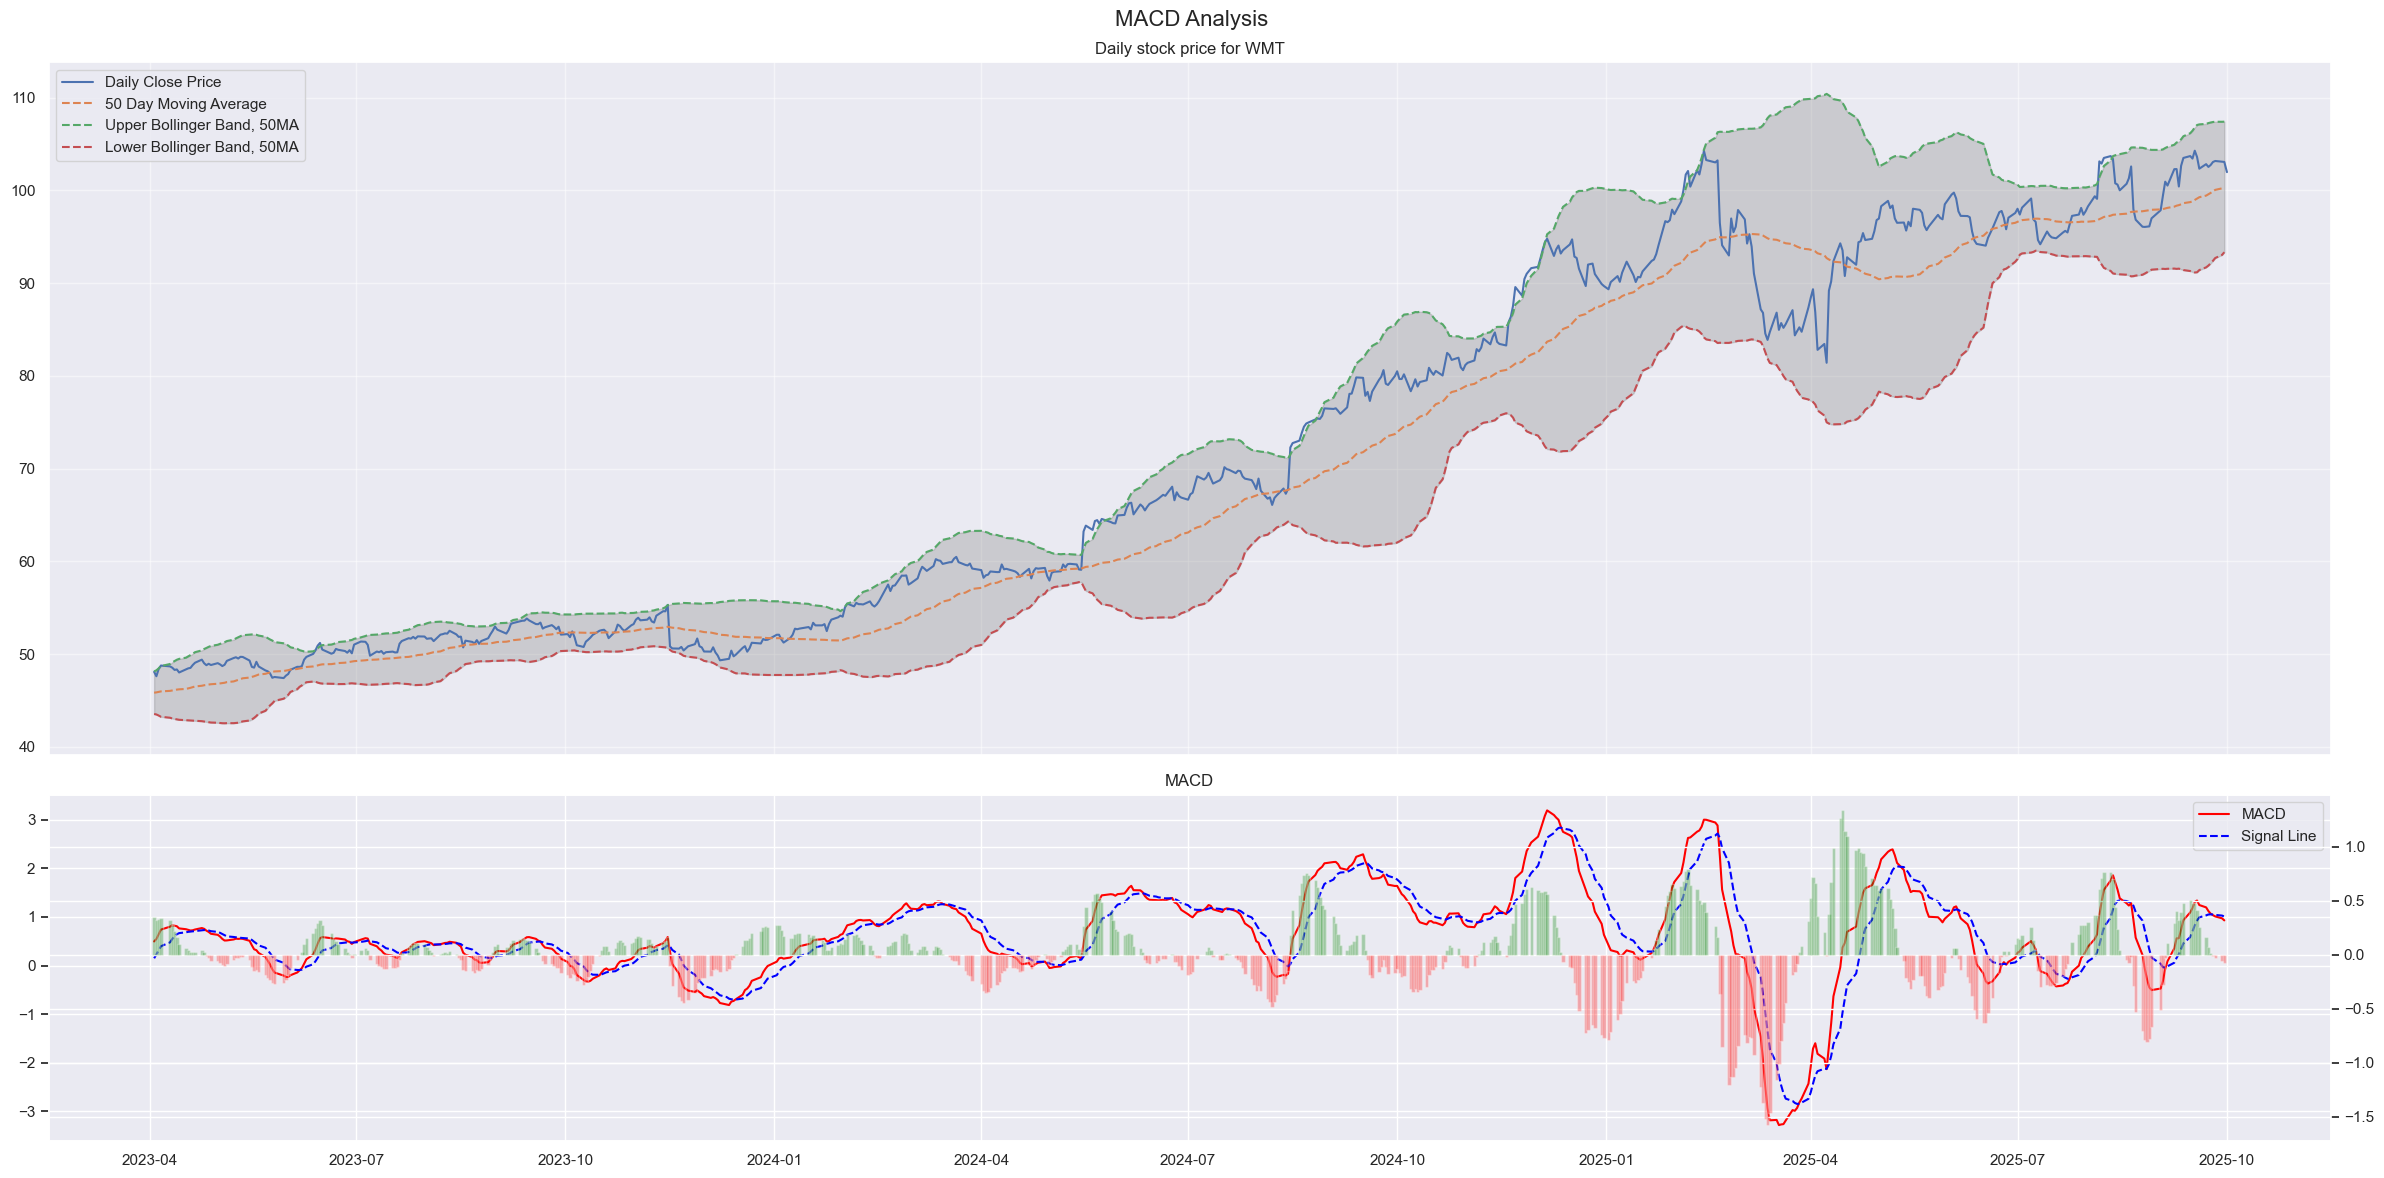

[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  84.32


[*********************100%***********************]  1 of 1 completed


Regression price since 2020:  93.77


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  94.29
Current RSI: 44.87 
Current MACD Divergence: -0.17 
Tomorrow inferred RSI: 37.01 
Tomorrow inferred MACD Divergence: -0.23 


In [15]:
stock_name = 'wmt'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 209.25
* Recent high: 209.51
* Current stock price is at 99.88% of recent high
Latest 5 Day MA: 205.44
Latest 5 Day EMA: 206.19
Latest 20 Day MA: 201.37
Latest Lower Bollinger Band, 20MA: 193.74
Latest Higher Bollinger Band, 20MA: 209.0
Latest 50 Day MA: 198.21
Latest Lower Bollinger Band, 50MA: 188.72
Latest Higher Bollinger Band, 50MA: 207.7
Latest 50 Day EMA: 197.29
Latest 120 Day MA: 182.94
Latest 200 Day MA: 169.83
Latest 200 Day EMA: 175.3
Latest 10 Week MA: 199.23
Latest 20 Week MA: 191.71
Latest 30 Week MA: 179.04
Latest 40 Week MA: 172.05
Latest Lower Weekly Bollinger Band, 20MA: 171.13
Latest Higher Weekly Bollinger Band, 20MA: 212.3

Latest RSI: 75.51 
Latest MACD Divergence: 0.5 
5MA break point: 205.88
5MA crosses 20MA at 179.07
20MA break point: 201.64
20MA crosses 50MA at 93.99
20MA Lower Bollinger Band break point: 193.02
20MA Upper Bollinger Band break point: 210.27
50MA break point: 198.35
50MA Lower Bollinger Band break point: 188.31
50MA Upper

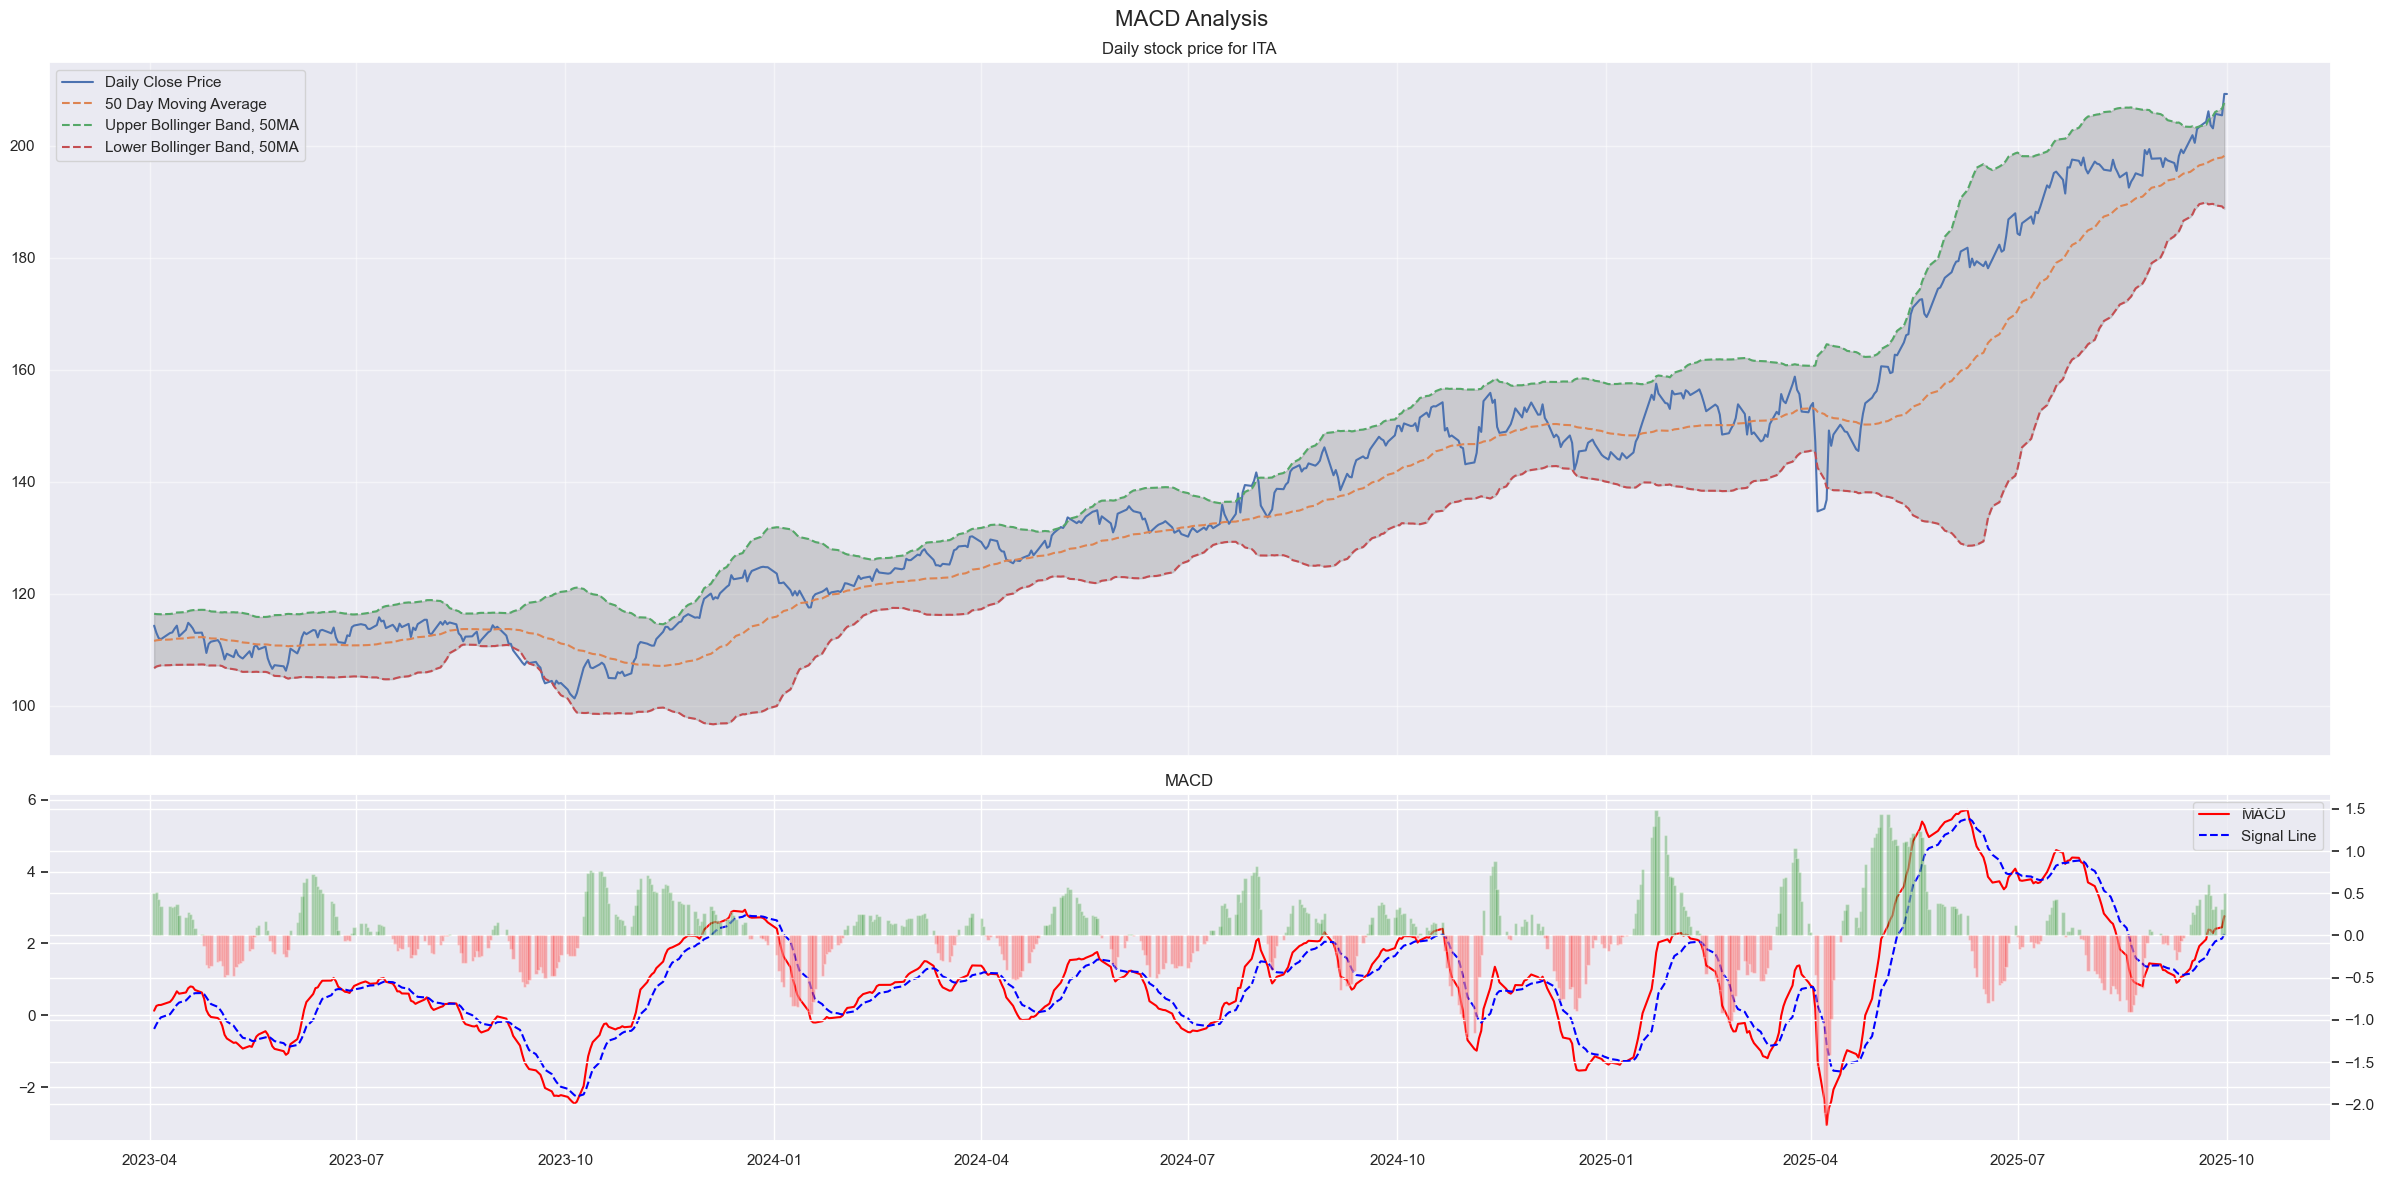

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  162.04
Regression price since 2020:  169.22


[*********************100%***********************]  1 of 1 completed


Regression price since QE:  171.51
Current RSI: 74.09 
Current MACD Divergence: 0.57 
Tomorrow inferred RSI: 76.49 
Tomorrow inferred MACD Divergence: 0.56 


In [16]:
stock_name = 'ita'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 118.97
* Recent high: 145.5
* Current stock price is at 81.76% of recent high
Latest 5 Day MA: 115.44
Latest 5 Day EMA: 115.97
Latest 20 Day MA: 118.0
Latest Lower Bollinger Band, 20MA: 110.73
Latest Higher Bollinger Band, 20MA: 125.27
Latest 50 Day MA: 116.4
Latest Lower Bollinger Band, 50MA: 108.52
Latest Higher Bollinger Band, 50MA: 124.28
Latest 50 Day EMA: 116.53
Latest 120 Day MA: 117.28
Latest 200 Day MA: 122.84
Latest 200 Day EMA: 117.65
Latest 10 Week MA: 116.46
Latest 20 Week MA: 114.55
Latest 30 Week MA: 119.25
Latest 40 Week MA: 122.93
Latest Lower Weekly Bollinger Band, 20MA: 106.41
Latest Higher Weekly Bollinger Band, 20MA: 122.69

Latest RSI: 41.13 
Latest MACD Divergence: -0.31 
5MA break point: 115.7
5MA crosses 20MA at 130.52
20MA break point: 118.04
20MA crosses 50MA at 63.86
20MA Lower Bollinger Band break point: 109.38
20MA Upper Bollinger Band break point: 126.71
50MA break point: 116.39
50MA crosses 200MA at 544.14
50MA Lower Bollinger Band

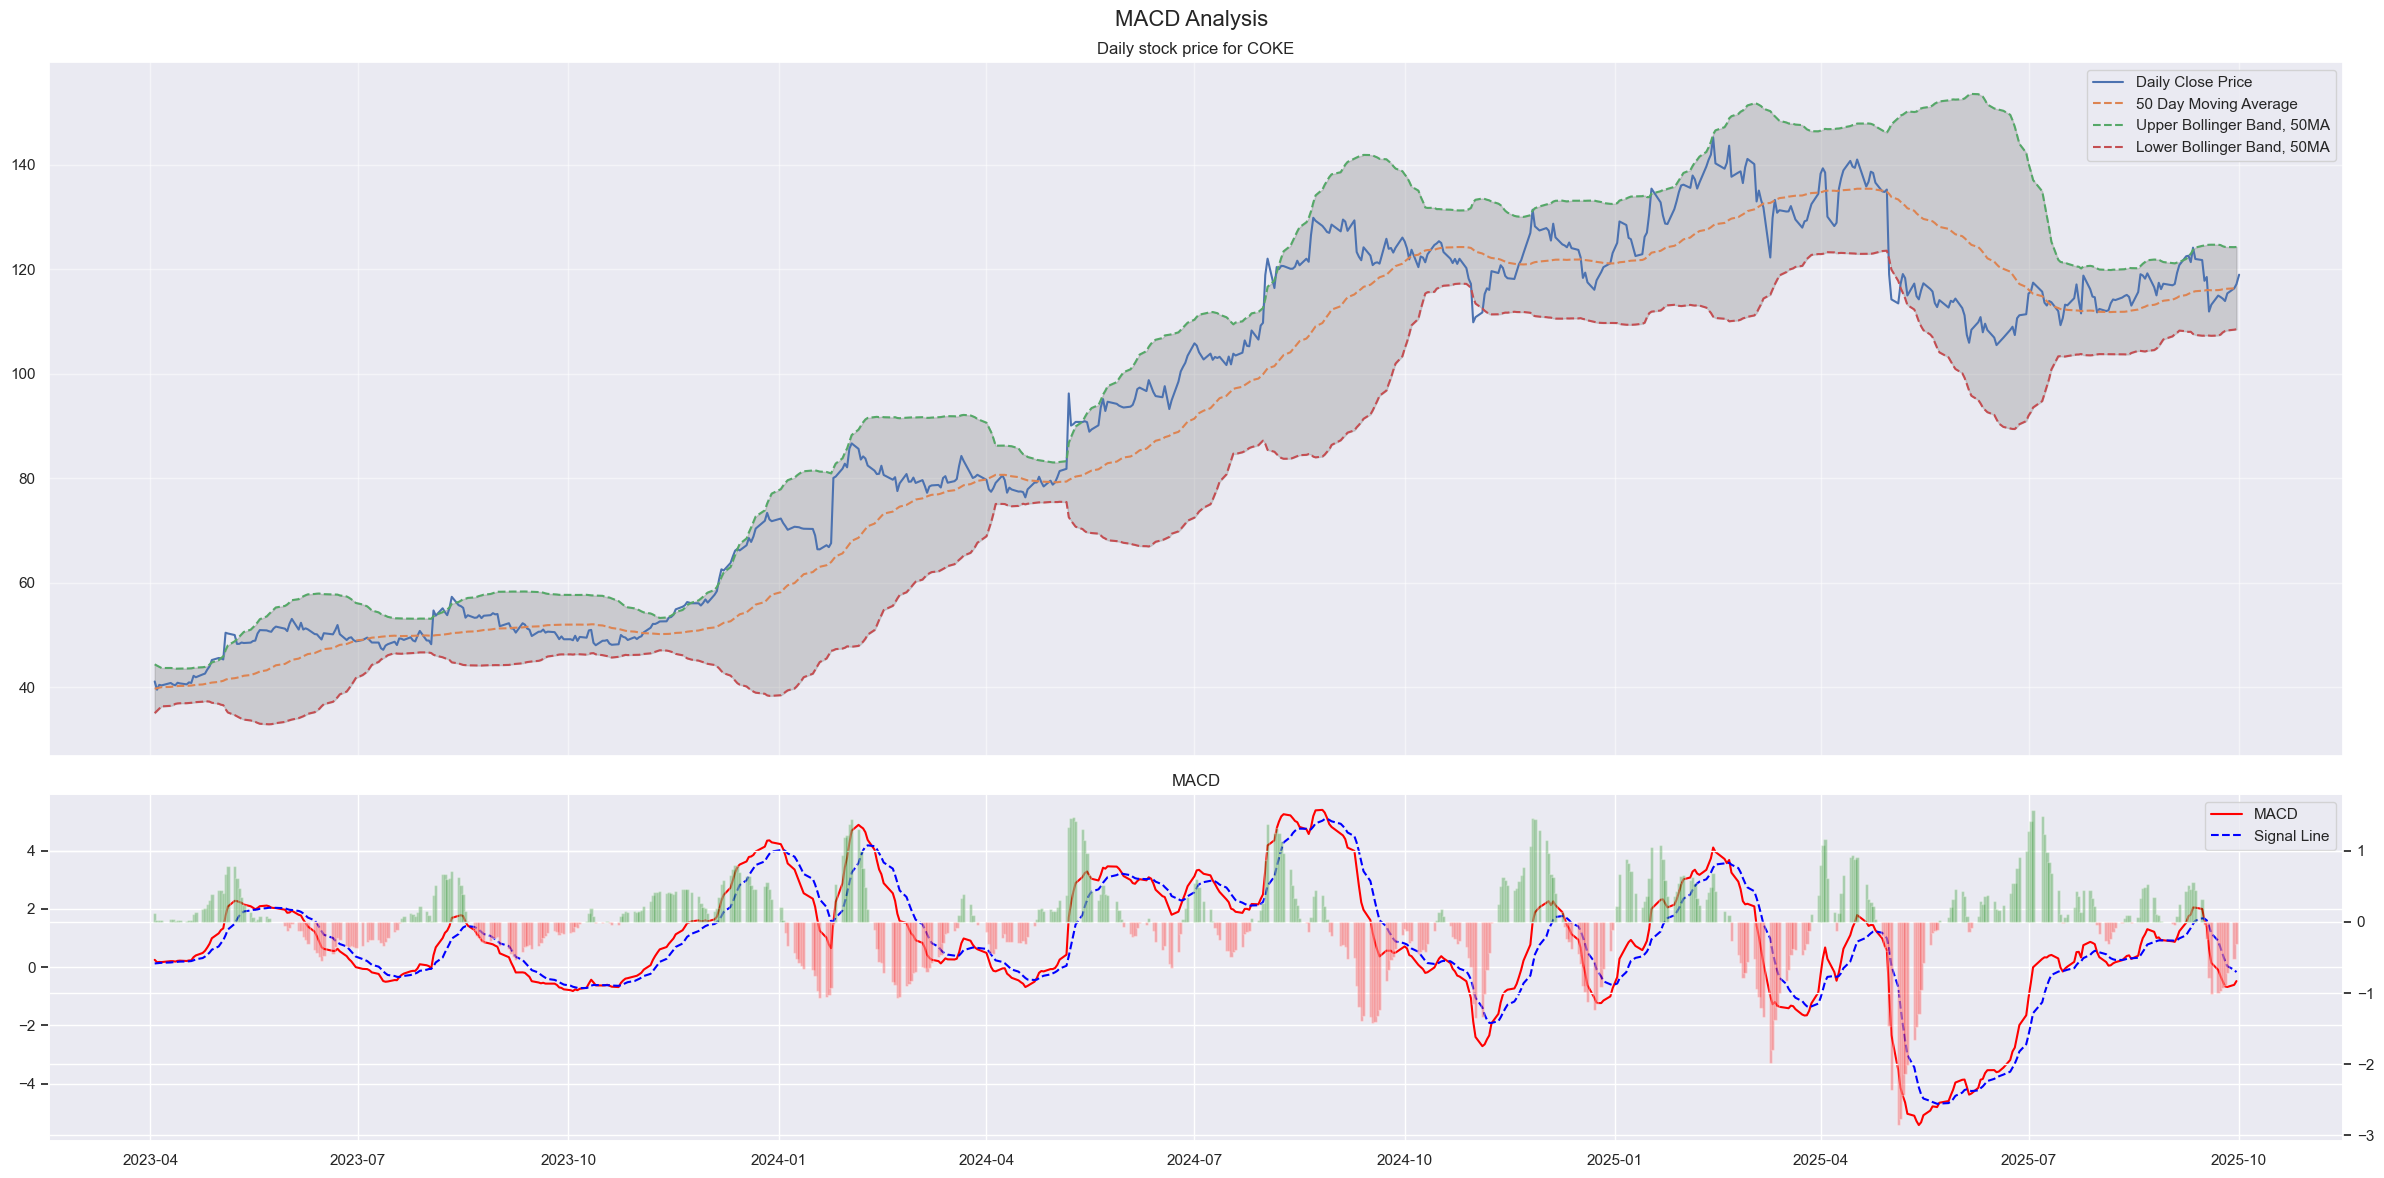

[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  142.58


[*********************100%***********************]  1 of 1 completed


Regression price since 2020:  147.88


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  148.06
Current RSI: 38.66 
Current MACD Divergence: -0.05 
Tomorrow inferred RSI: 42.72 
Tomorrow inferred MACD Divergence: 0.12 


In [17]:
# 9/19/2025 110.60, 7/15/2025 109.42, 6/18/2025 105.44, 6/5/2025 105.21; 6/20/2024 96.50
# Regression drawback 102.8
# keep supp 105.2 on 06/16/2025
# 20wk MA, if break, 30wk MA
stock_name = 'coke'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 490.24
* Recent high: 519.1
* Current stock price is at 94.44% of recent high
Latest 5 Day MA: 479.28
Latest 5 Day EMA: 481.04
Latest 20 Day MA: 481.08
Latest Lower Bollinger Band, 20MA: 468.0
Latest Higher Bollinger Band, 20MA: 494.16
Latest 50 Day MA: 474.77
Latest Lower Bollinger Band, 50MA: 422.65
Latest Higher Bollinger Band, 50MA: 526.89
Latest 50 Day EMA: 477.07
Latest 120 Day MA: 474.43
Latest 200 Day MA: 461.1
Latest 200 Day EMA: 463.45
Latest 10 Week MA: 469.58
Latest 20 Week MA: 477.54
Latest 30 Week MA: 467.99
Latest 40 Week MA: 462.88
Latest Lower Weekly Bollinger Band, 20MA: 439.6
Latest Higher Weekly Bollinger Band, 20MA: 515.49

Latest RSI: 57.88 
Latest MACD Divergence: -0.01 
5MA break point: 478.95
5MA crosses 20MA at 487.89
20MA break point: 480.36
20MA crosses 50MA at 280.43
20MA Lower Bollinger Band break point: 466.8
20MA Upper Bollinger Band break point: 493.92
50MA break point: 474.24
50MA Lower Bollinger Band break point: 418.15
50MA Upp

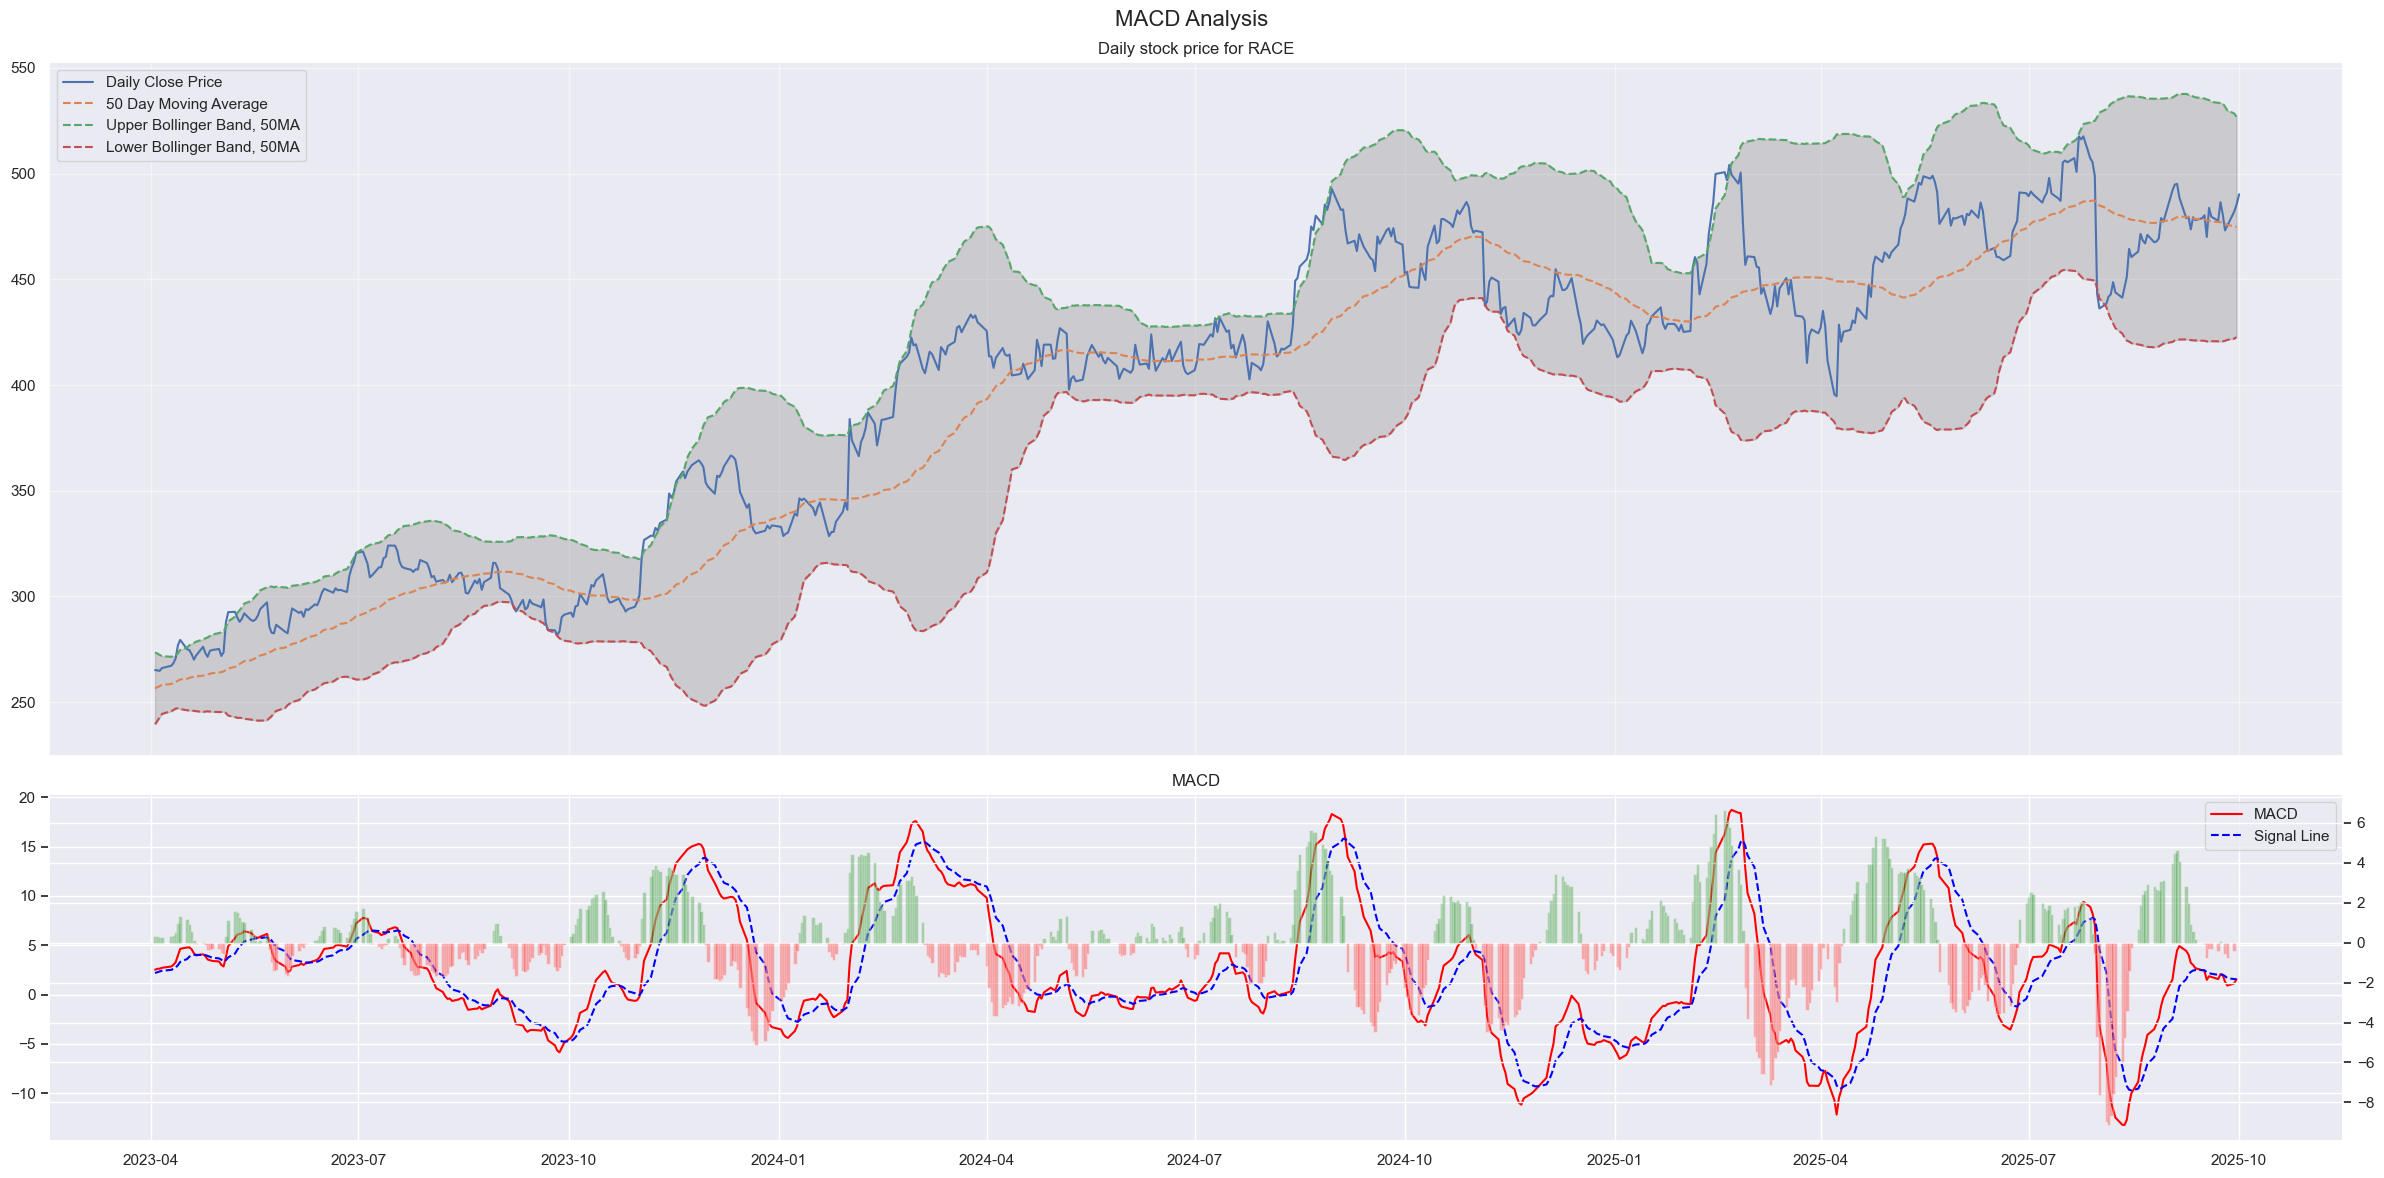

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  512.26
Regression price since 2020:  516.52


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  517.73
Current RSI: 57.46 
Current MACD Divergence: 0.56 
Tomorrow inferred RSI: 58.55 
Tomorrow inferred MACD Divergence: 0.87 


In [18]:
# 411 strong supp
# 8/1/2025 428.01, 4/7/2025 391.54
# 50lbb hold
# 30wk ma good supp
stock_name = 'race'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 519.71
* Recent high: 554.54
* Current stock price is at 93.72% of recent high
Latest 5 Day MA: 512.24
Latest 5 Day EMA: 513.8
Latest 20 Day MA: 508.09
Latest Lower Bollinger Band, 20MA: 494.83
Latest Higher Bollinger Band, 20MA: 521.36
Latest 50 Day MA: 511.98
Latest Lower Bollinger Band, 50MA: 489.9
Latest Higher Bollinger Band, 50MA: 534.05
Latest 50 Day EMA: 505.78
Latest 120 Day MA: 477.28
Latest 200 Day MA: 449.73
Latest 200 Day EMA: 464.39
Latest 10 Week MA: 512.99
Latest 20 Week MA: 498.85
Latest 30 Week MA: 465.3
Latest 40 Week MA: 452.14
Latest Lower Weekly Bollinger Band, 20MA: 455.47
Latest Higher Weekly Bollinger Band, 20MA: 542.24

Latest RSI: 65.42 
Latest MACD Divergence: 0.95 
5MA break point: 512.76
5MA crosses 20MA at 484.12
20MA break point: 508.24
20MA crosses 50MA at 635.36
20MA Lower Bollinger Band break point: 492.49
20MA Upper Bollinger Band break point: 523.99
50MA break point: 512.13
50MA Lower Bollinger Band break point: 488.17
50MA Up

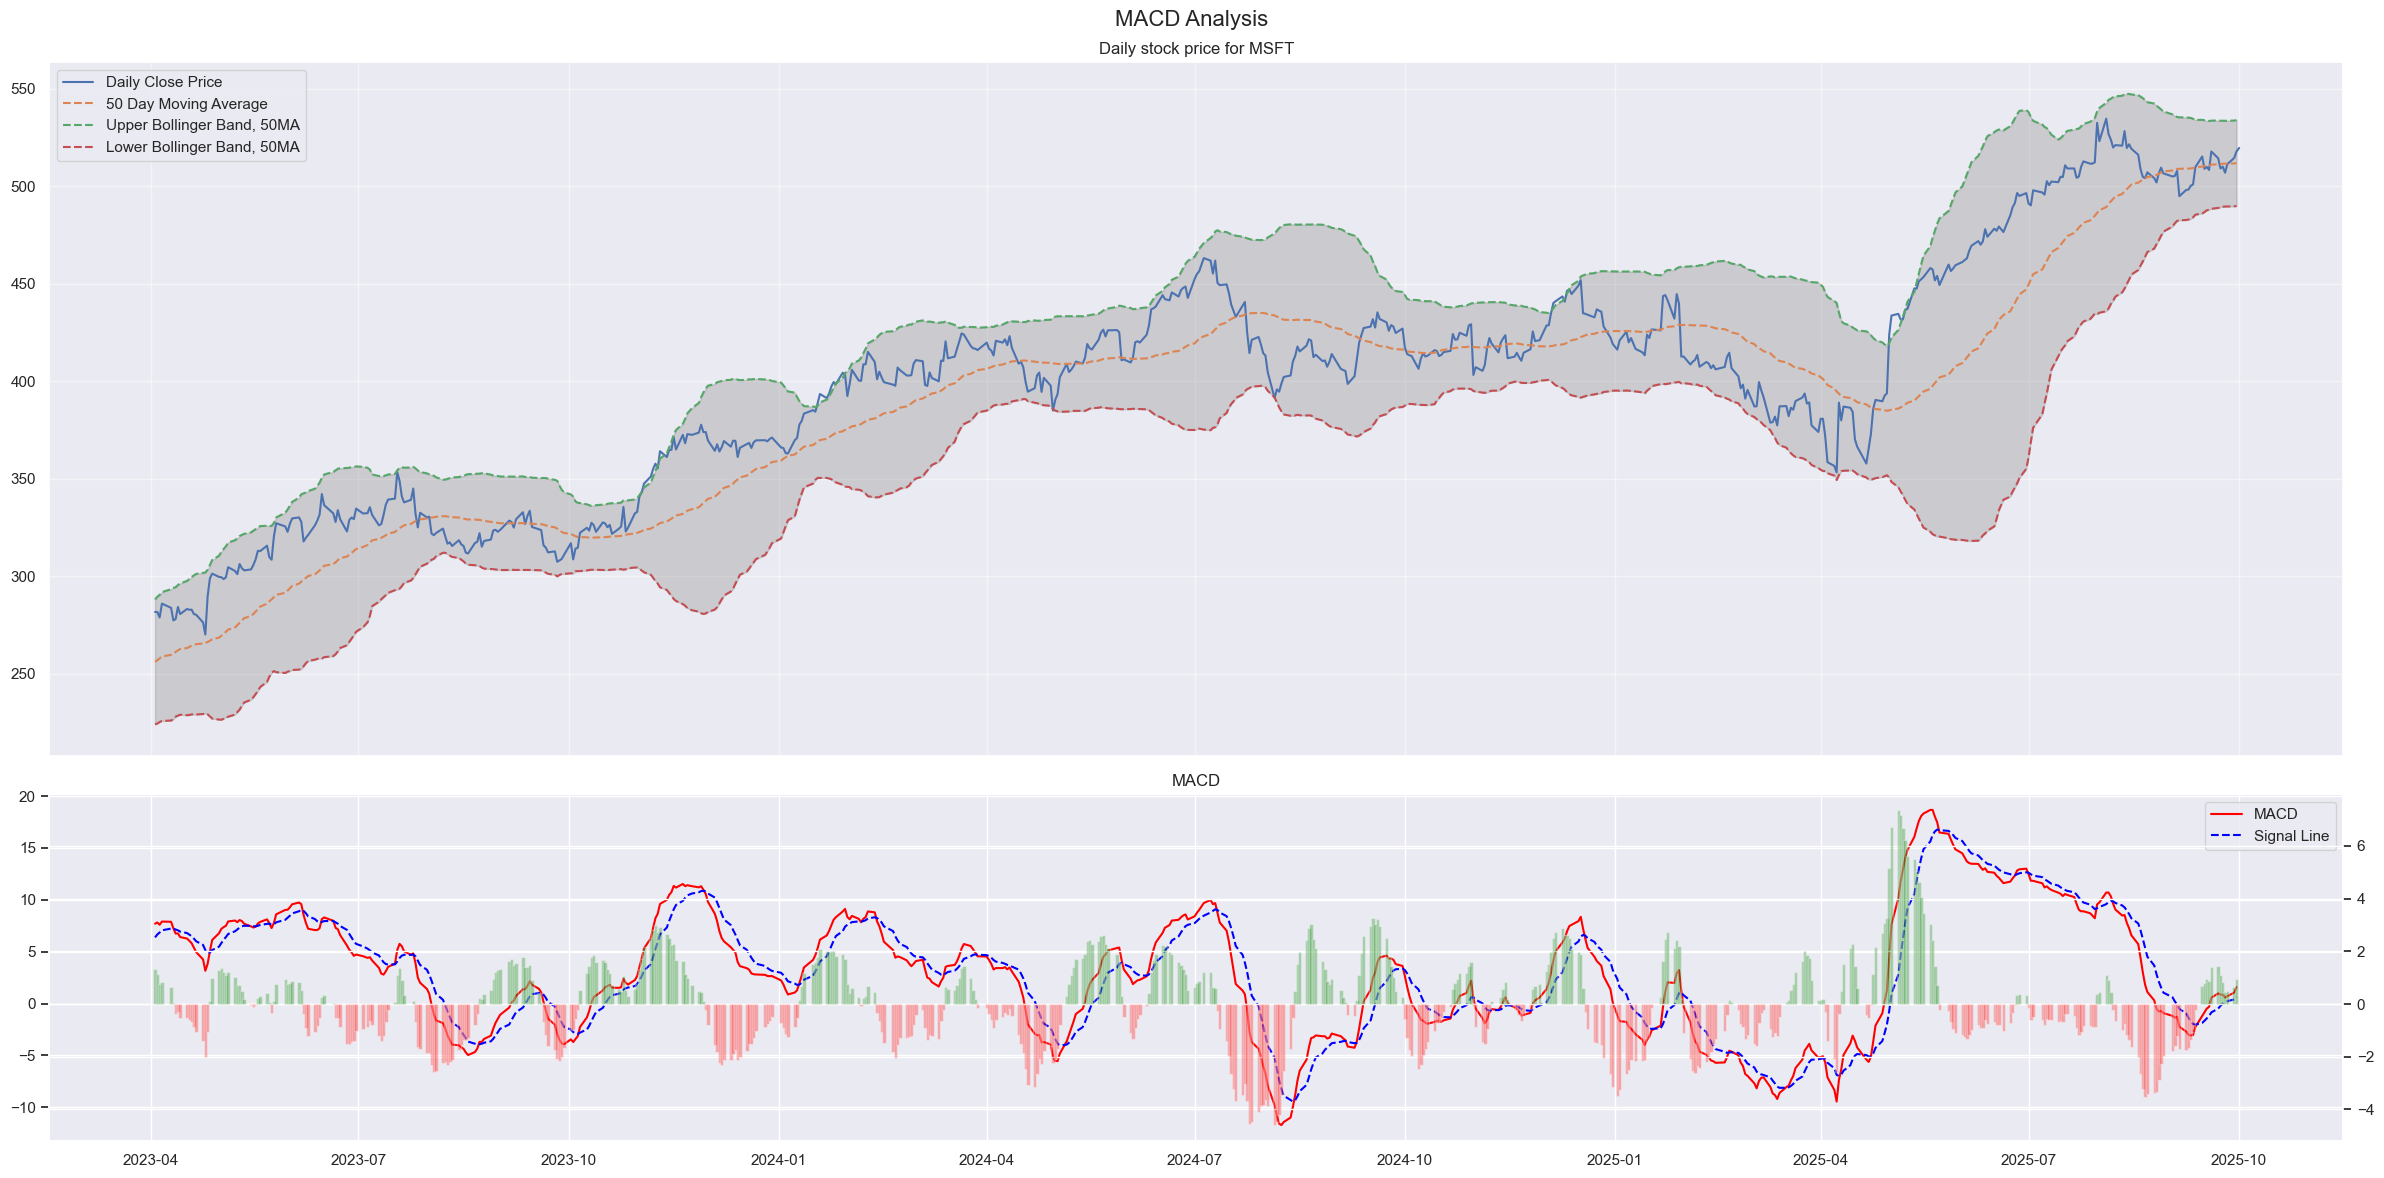

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  523.71
Regression price since 2020:  490.67


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  488.87
Current RSI: 66.09 
Current MACD Divergence: 1.19 
Tomorrow inferred RSI: 59.96 
Tomorrow inferred MACD Divergence: 1.26 


In [19]:
# 04/07/2025 min 344.79, 04/04/2025 min 362.01 ~ min of plateau 2023Dec - 2024Jan: 362.9
# 368 solid buy based on regression low /0.9/0.95
stock_name = 'msft'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 4247.96
* Recent high: 4388.11
* Current stock price is at 96.81% of recent high
Latest 5 Day MA: 4215.01
Latest 5 Day EMA: 4231.79
Latest 20 Day MA: 4219.22
Latest Lower Bollinger Band, 20MA: 4083.43
Latest Higher Bollinger Band, 20MA: 4355.02
Latest 50 Day MA: 4092.38
Latest Lower Bollinger Band, 50MA: 3696.46
Latest Higher Bollinger Band, 50MA: 4488.31
Latest 50 Day EMA: 4092.65
Latest 120 Day MA: 3860.01
Latest 200 Day MA: 3690.68
Latest 200 Day EMA: 3729.82
Latest 10 Week MA: 4138.03
Latest 20 Week MA: 3928.81
Latest 30 Week MA: 3841.35
Latest 40 Week MA: 3725.69
Latest Lower Weekly Bollinger Band, 20MA: 3447.67
Latest Higher Weekly Bollinger Band, 20MA: 4409.95

Latest RSI: 53.01 
Latest MACD Divergence: -4.11 
5MA break point: 4224.54
5MA crosses 20MA at 4200.77
20MA break point: 4220.79
20MA crosses 50MA at 238.61
20MA Lower Bollinger Band break point: 4059.63
20MA Upper Bollinger Band break point: 4381.95
50MA break point: 4098.89
50MA Lower Bollinger Ba

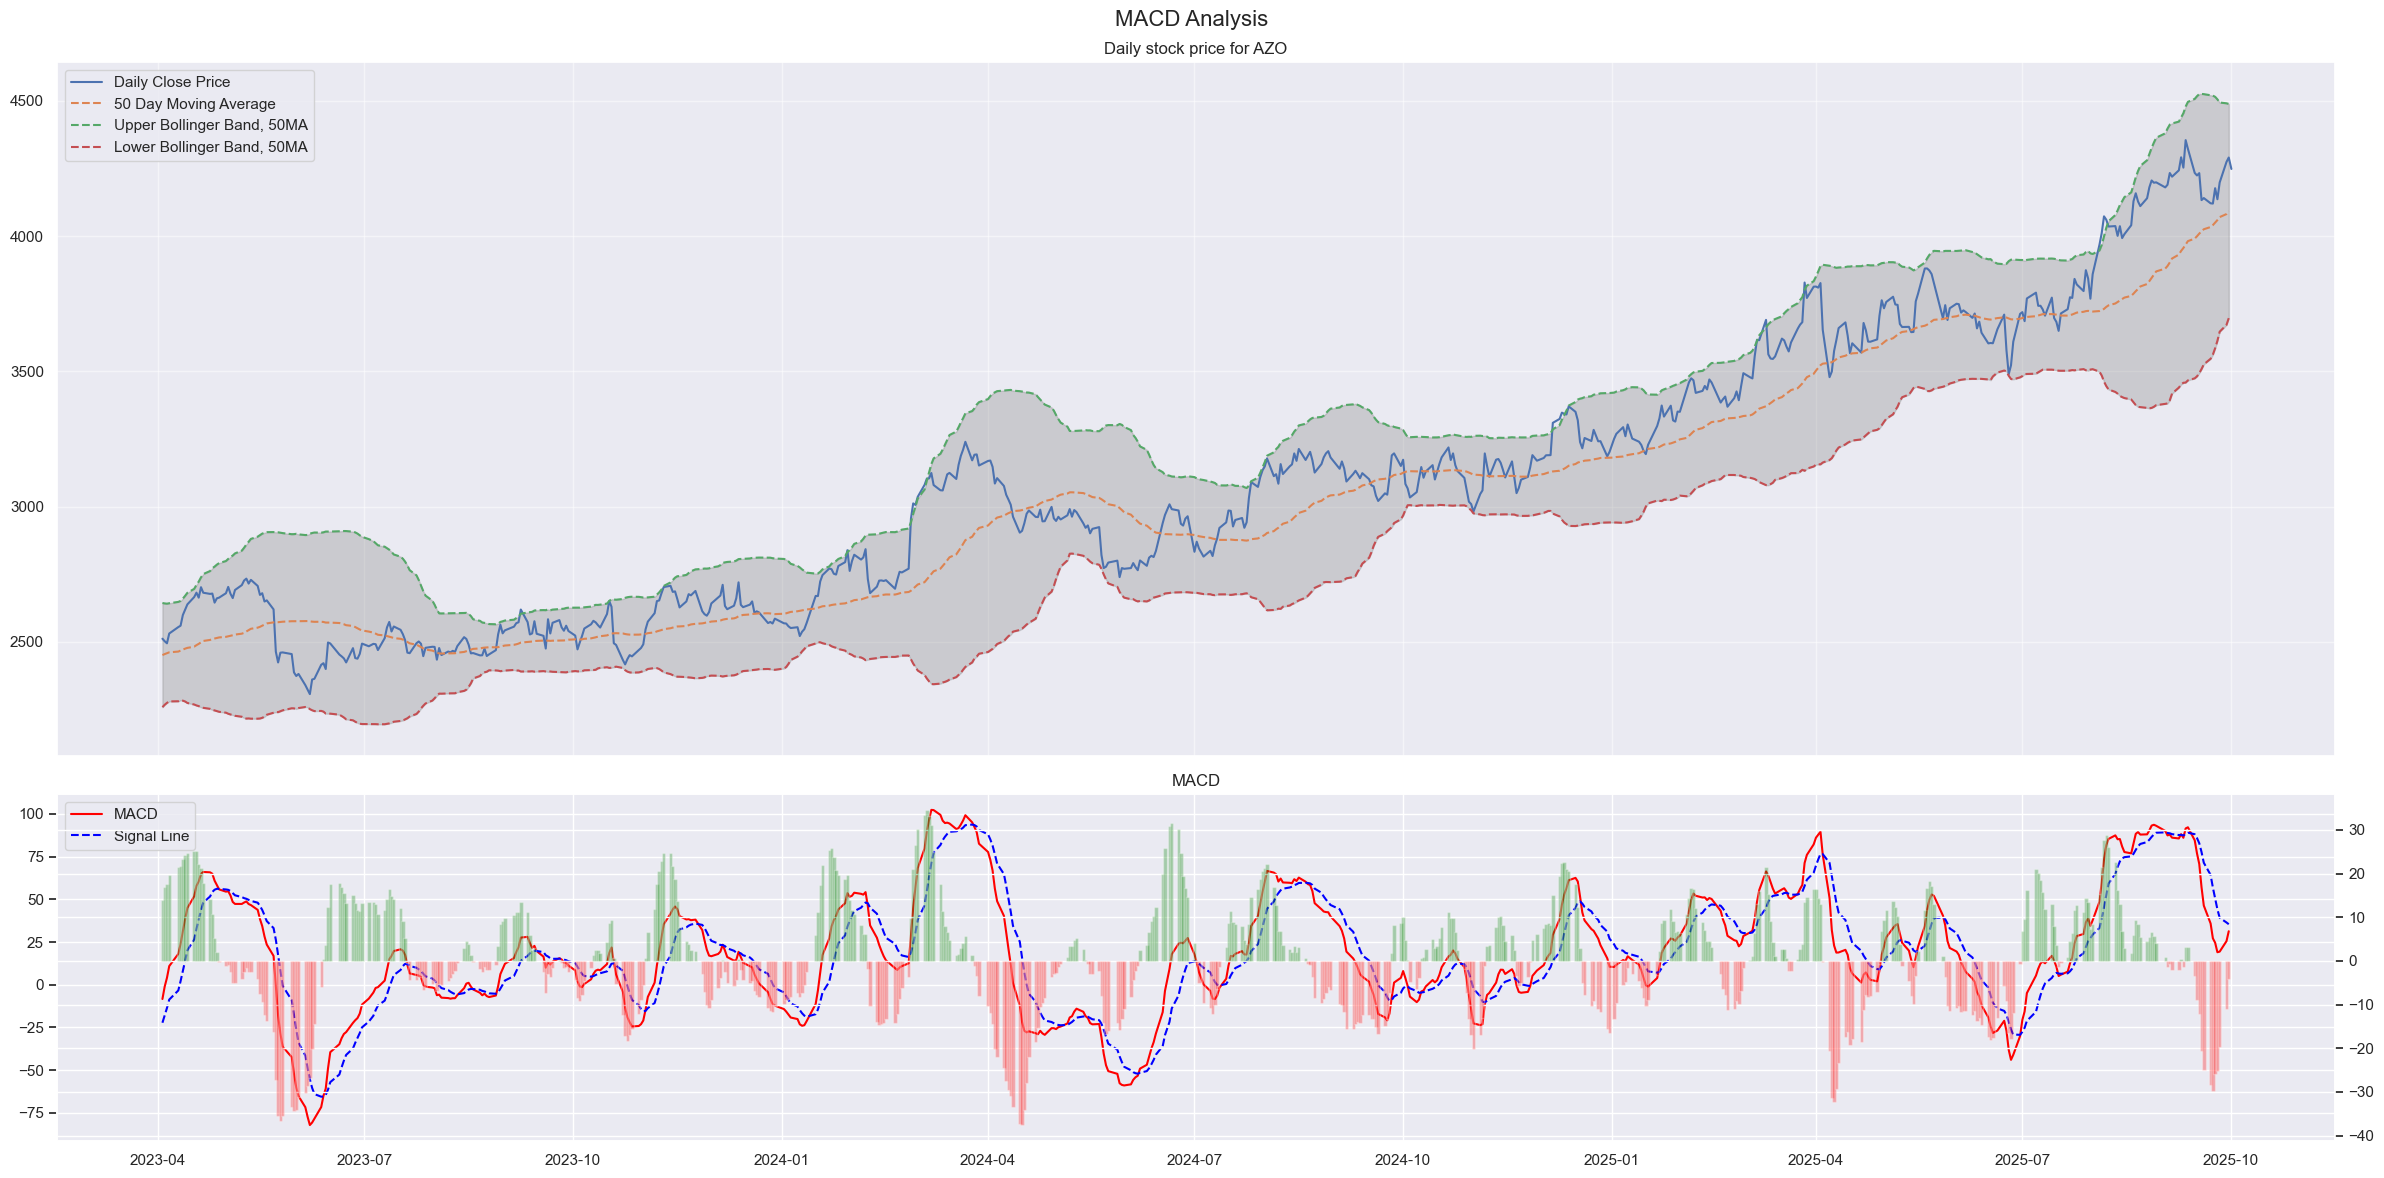

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  3918.54
Regression price since 2020:  4056.78


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  4051.0
Current RSI: 40.5 
Current MACD Divergence: -2.63 
Tomorrow inferred RSI: 42.98 
Tomorrow inferred MACD Divergence: -1.88 


In [20]:
# 9/23/2025 min 3969.59, 6/16/2025 & 5/12/2025 3565.02, 4/25/2025 3533.32, 4/21/2025 3506.62, 4/9/2025 3433.65
# 3580 good supp - 20lbb and supp, hold on 6/16/2025
# buy 50MA
stock_name = 'AZO'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 246.0
* Recent high: 299.88
* Current stock price is at 82.03% of recent high
Latest 5 Day MA: 243.9
Latest 5 Day EMA: 245.57
Latest 20 Day MA: 245.72
Latest Lower Bollinger Band, 20MA: 235.51
Latest Higher Bollinger Band, 20MA: 255.94
Latest 50 Day MA: 248.53
Latest Lower Bollinger Band, 50MA: 219.69
Latest Higher Bollinger Band, 50MA: 277.36
Latest 50 Day EMA: 250.21
Latest 120 Day MA: 262.4
Latest 200 Day MA: 262.43
Latest 200 Day EMA: 254.82
Latest 10 Week MA: 244.21
Latest 20 Week MA: 257.74
Latest 30 Week MA: 261.26
Latest 40 Week MA: 263.29
Latest Lower Weekly Bollinger Band, 20MA: 227.3
Latest Higher Weekly Bollinger Band, 20MA: 288.18

Latest RSI: 50.15 
Latest MACD Divergence: -0.02 
5MA break point: 244.14
5MA crosses 20MA at 256.61
20MA break point: 246.11
20MA crosses 50MA at 309.77
20MA Lower Bollinger Band break point: 234.64
20MA Upper Bollinger Band break point: 257.58
50MA break point: 248.06
50MA crosses 200MA at 1210.0
50MA Lower Bollinger Ban

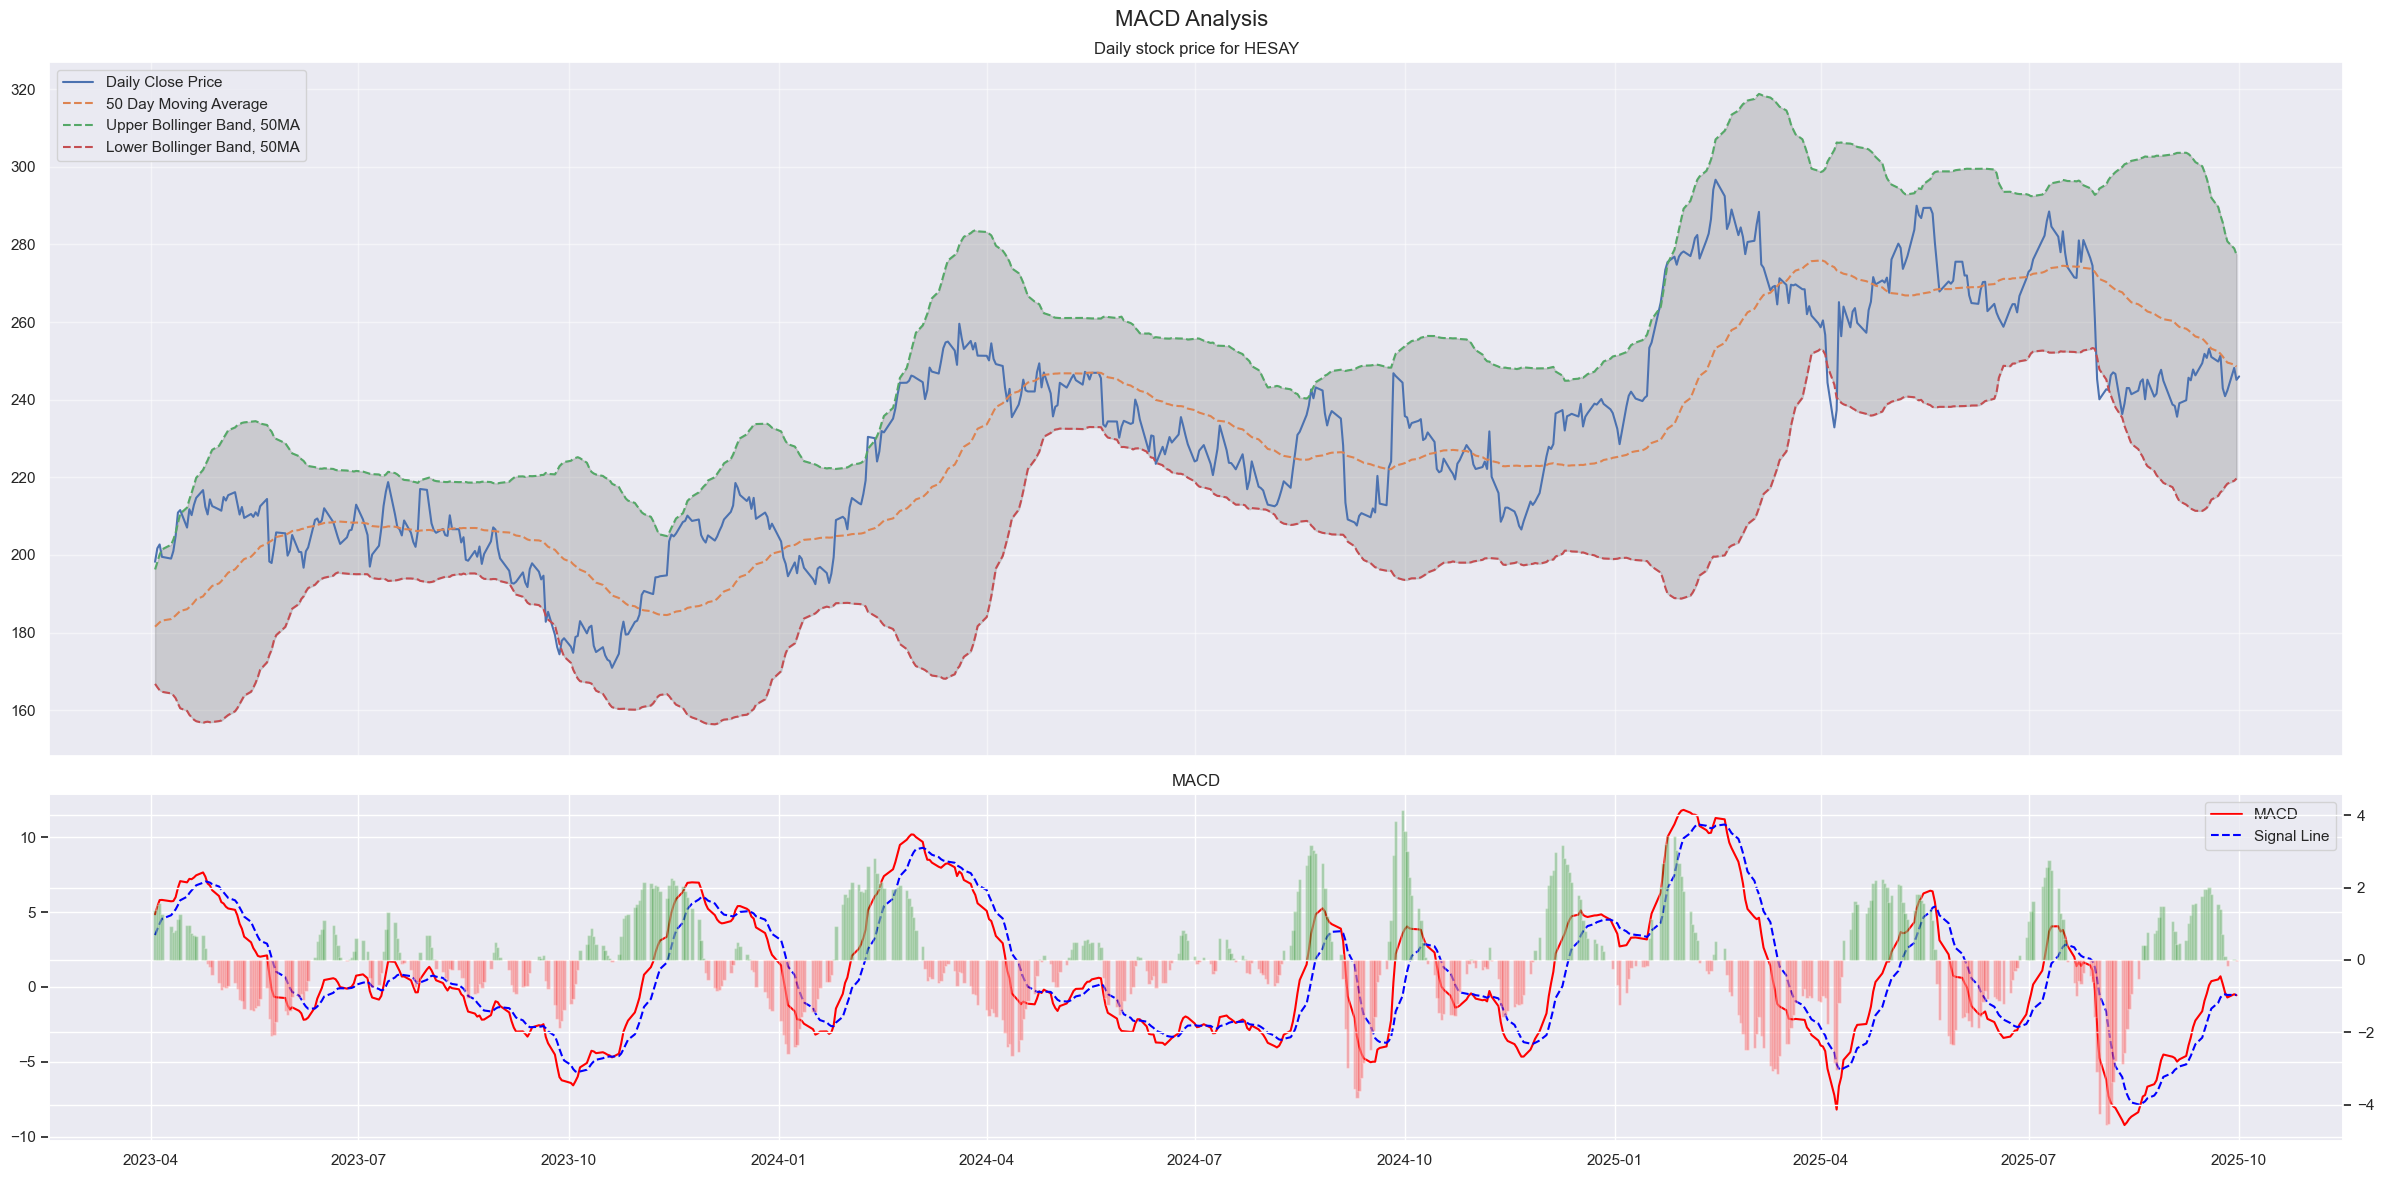

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  291.24


[*********************100%***********************]  1 of 1 completed

Regression price since 2020:  291.06
Regression price since QE:  289.77
Current RSI: 47.58 
Current MACD Divergence: -0.0 
Tomorrow inferred RSI: 49.62 
Tomorrow inferred MACD Divergence: 0.02 


In [21]:
# 9/4/2025 & 8/12/2025 min 233.21 & 233.92, 04/07/2025 232.01 then 1/3/2025 228.82
# 233.5 good support
stock_name = 'hesay'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 328.56
* Recent high: 349.19
* Current stock price is at 94.08999999999999% of recent high
Latest 5 Day MA: 339.36
Latest 5 Day EMA: 338.07
Latest 20 Day MA: 333.03
Latest Lower Bollinger Band, 20MA: 318.09
Latest Higher Bollinger Band, 20MA: 347.97
Latest 50 Day MA: 318.18
Latest Lower Bollinger Band, 50MA: 279.79
Latest Higher Bollinger Band, 50MA: 356.58
Latest 50 Day EMA: 322.66
Latest 120 Day MA: 302.27
Latest 200 Day MA: 297.73
Latest 200 Day EMA: 297.1
Latest 10 Week MA: 321.41
Latest 20 Week MA: 313.1
Latest 30 Week MA: 297.21
Latest 40 Week MA: 298.59
Latest Lower Weekly Bollinger Band, 20MA: 277.96
Latest Higher Weekly Bollinger Band, 20MA: 348.25

Latest RSI: 60.61 
Latest MACD Divergence: -0.52 
5MA break point: 339.08
5MA crosses 20MA at 303.88
20MA break point: 333.52
20MA Lower Bollinger Band break point: 316.48
20MA Upper Bollinger Band break point: 350.56
50MA break point: 318.47
50MA Lower Bollinger Band break point: 276.83
50MA Upper Bollinger 

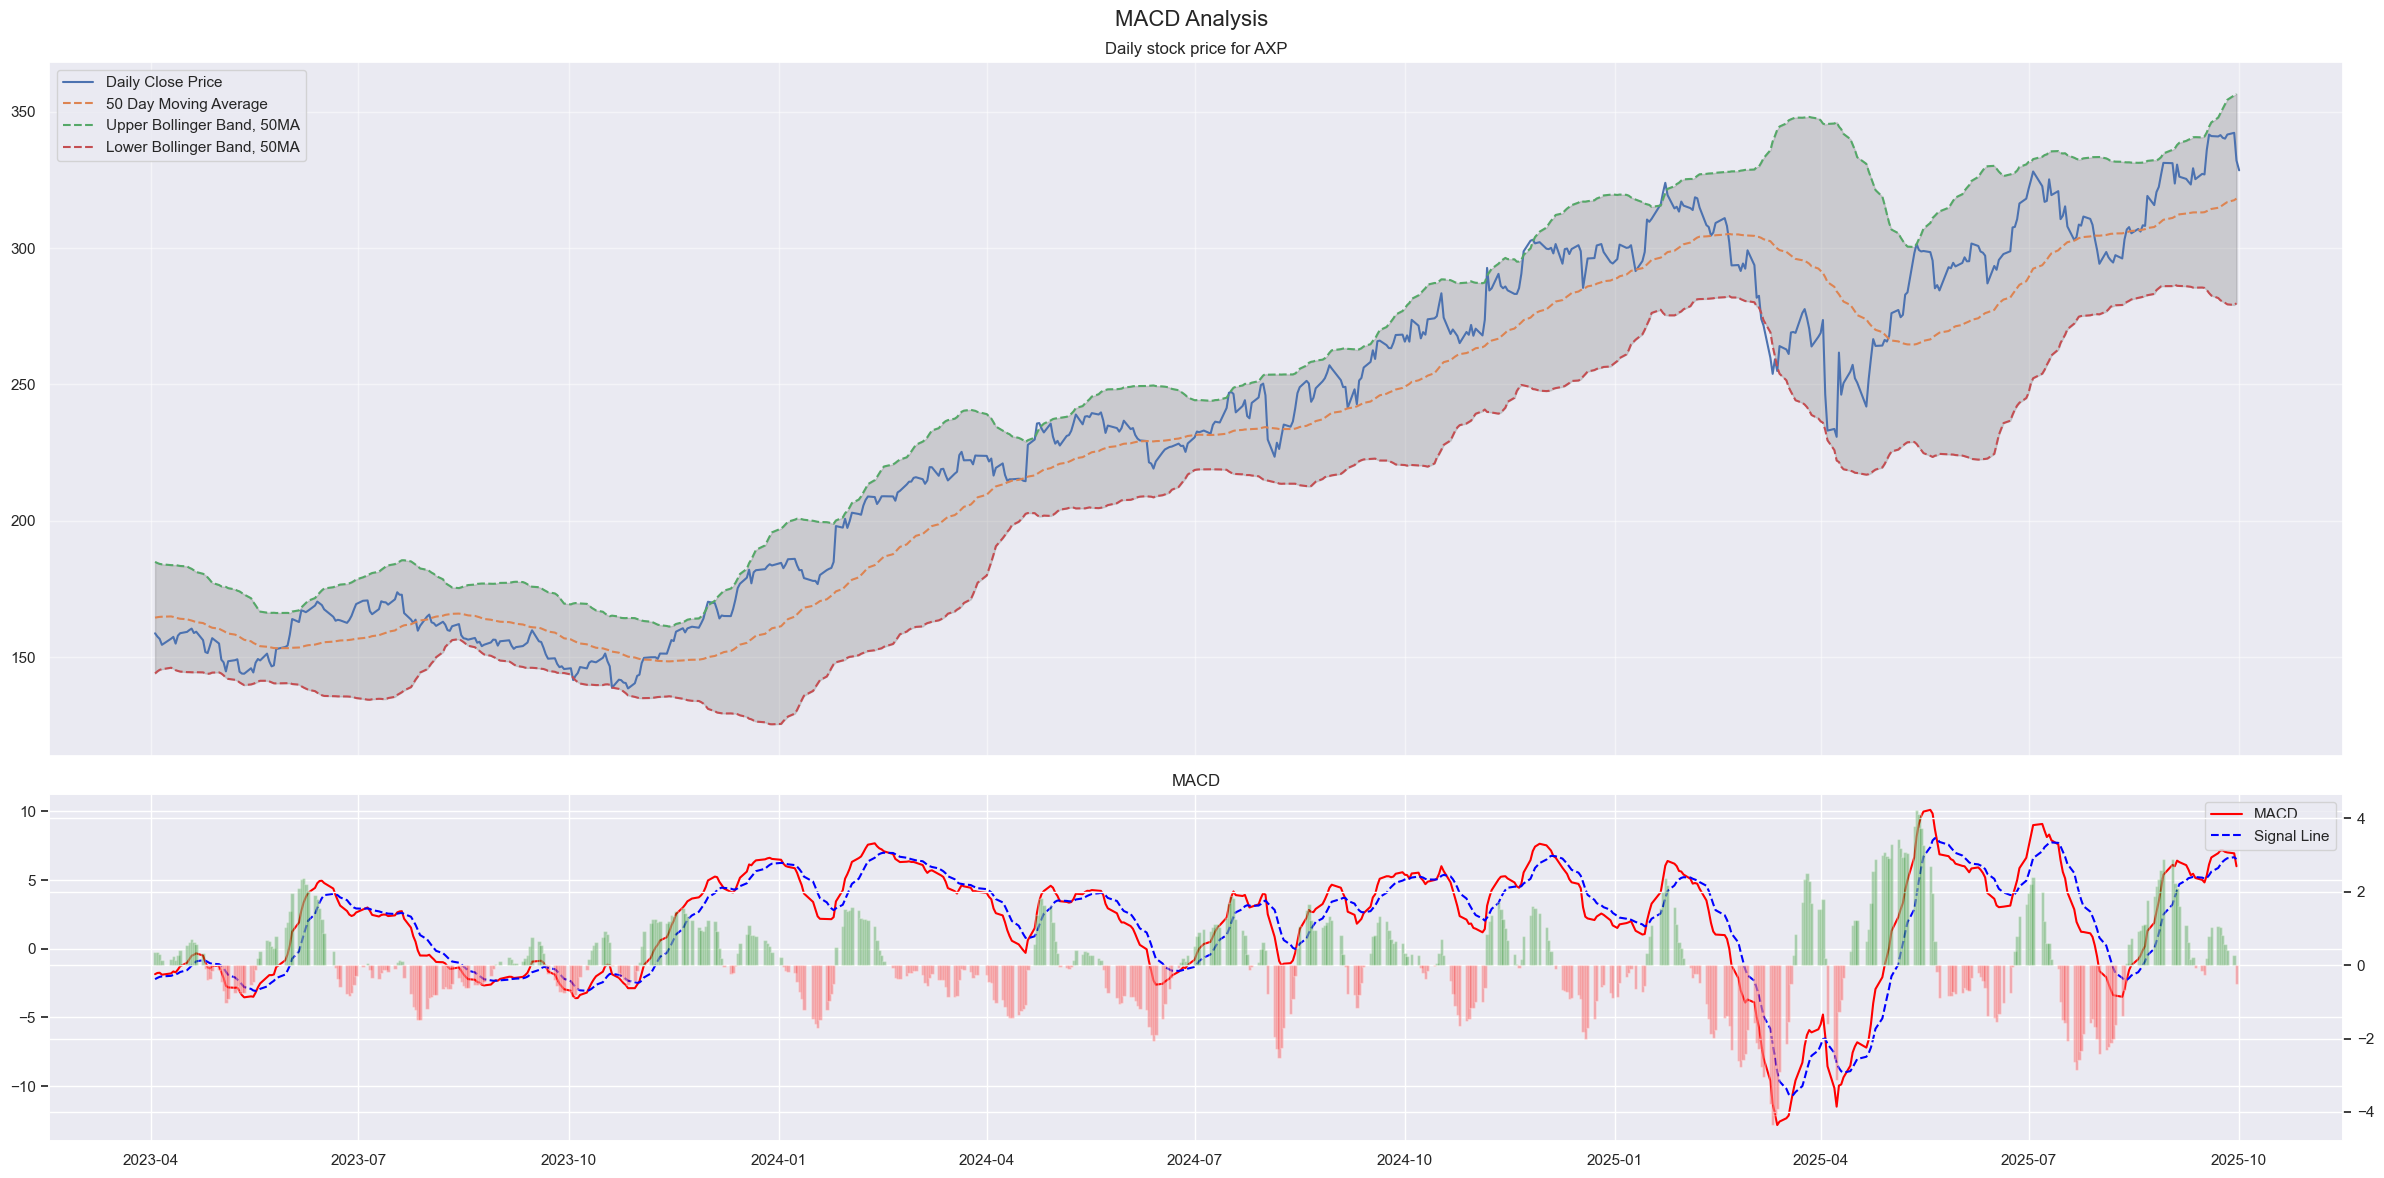

[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  277.15


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Regression price since 2020:  310.01
Regression price since QE:  311.68
Current RSI: 49.03 
Current MACD Divergence: -1.29 
Tomorrow inferred RSI: 54.62 
Tomorrow inferred MACD Divergence: -1.76 


In [22]:
# 4/7/2025 220.43; 4/4/2025 228.62; 8/5/2024 222.03
# 213.6 can be considered as a bottom based on maximal drawback
# 224.8 based on on maximal drawback () /0.95
# buy below 232
stock_name = 'axp'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 244.9
* Recent high: 256.0
* Current stock price is at 95.66% of recent high
Latest 5 Day MA: 245.32
Latest 5 Day EMA: 245.44
Latest 20 Day MA: 244.06
Latest Lower Bollinger Band, 20MA: 229.22
Latest Higher Bollinger Band, 20MA: 258.9
Latest 50 Day MA: 217.5
Latest Lower Bollinger Band, 50MA: 160.02
Latest Higher Bollinger Band, 50MA: 274.97
Latest 50 Day EMA: 221.88
Latest 120 Day MA: 188.57
Latest 200 Day MA: 185.33
Latest 200 Day EMA: 189.93
Latest 10 Week MA: 223.25
Latest 20 Week MA: 200.1
Latest 30 Week MA: 186.04
Latest 40 Week MA: 186.34
Latest Lower Weekly Bollinger Band, 20MA: 141.85
Latest Higher Weekly Bollinger Band, 20MA: 258.35

Latest RSI: 55.99 
Latest MACD Divergence: -2.17 
5MA break point: 244.87
5MA crosses 20MA at 244.28
20MA break point: 244.78
20MA Lower Bollinger Band break point: 228.81
20MA Upper Bollinger Band break point: 260.75
50MA break point: 218.03
50MA Lower Bollinger Band break point: 156.01
50MA Upper Bollinger Band break poin

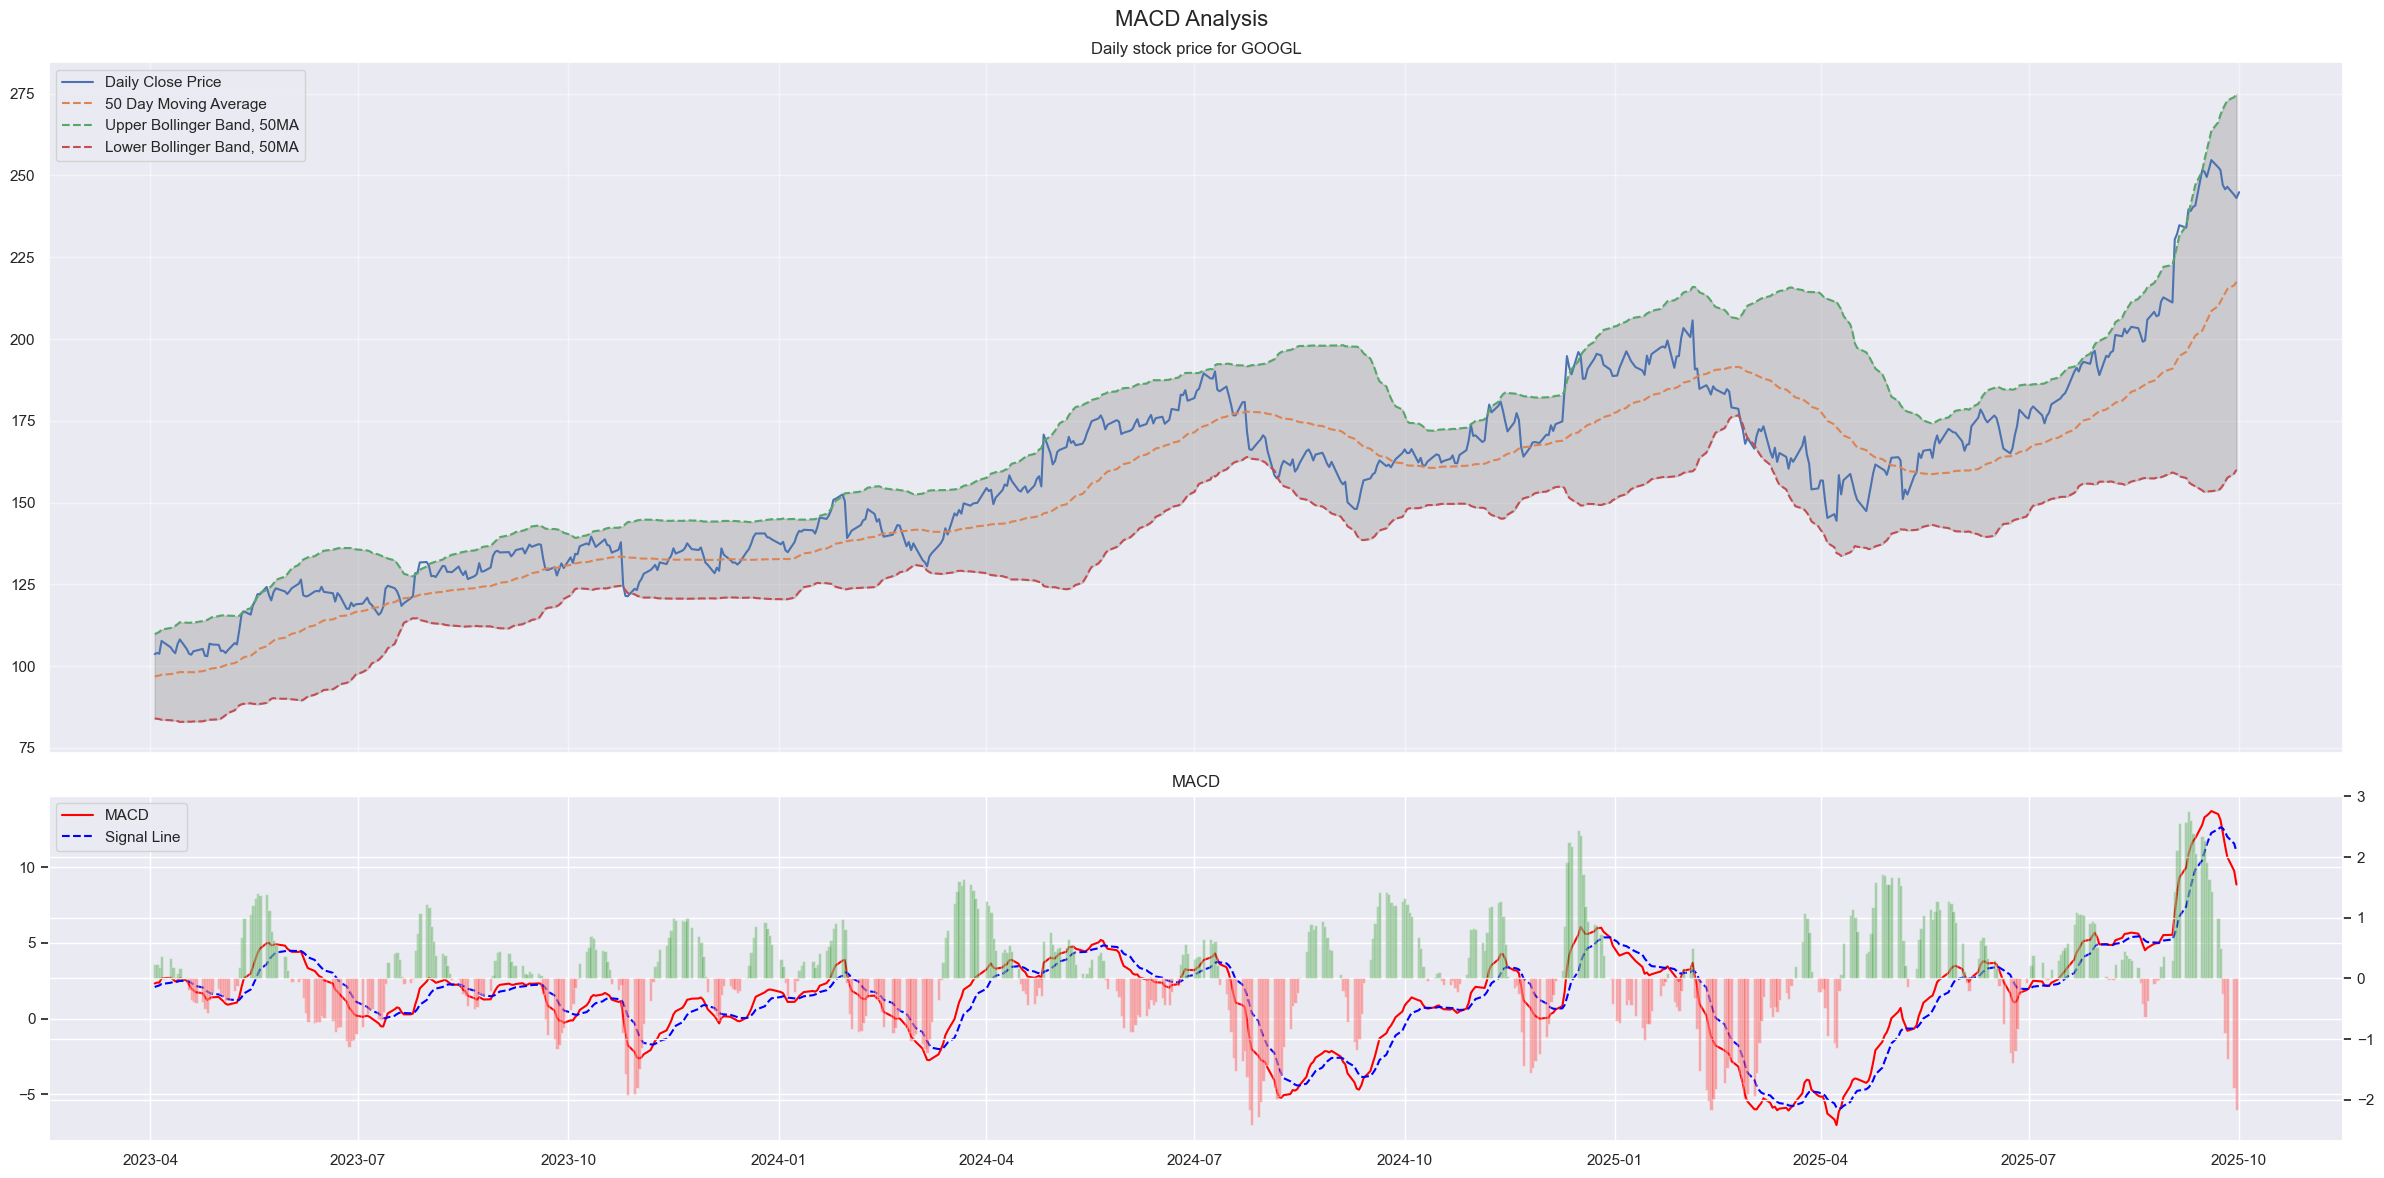

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  199.06
Regression price since 2020:  193.41


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  192.61
Current RSI: 56.78 
Current MACD Divergence: -2.27 
Tomorrow inferred RSI: 56.21 
Tomorrow inferred MACD Divergence: -2.31 


In [23]:
# 4/7/2025 min 140.53; 4/4/2025 146.15 & 9/9/2024 147.22 -- strong supp; then 3/5/2024 130.67
# buy 146.2
stock_name = 'googl'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 244.38
* Recent high: 232.35
* Current stock price is at 105.18% of recent high
Latest 5 Day MA: 222.77
Latest 5 Day EMA: 224.7
Latest 20 Day MA: 218.3
Latest Lower Bollinger Band, 20MA: 207.33
Latest Higher Bollinger Band, 20MA: 229.27
Latest 50 Day MA: 207.47
Latest Lower Bollinger Band, 50MA: 178.99
Latest Higher Bollinger Band, 50MA: 235.94
Latest 50 Day EMA: 209.76
Latest 120 Day MA: 194.03
Latest 200 Day MA: 191.31
Latest 200 Day EMA: 193.54
Latest 10 Week MA: 212.65
Latest 20 Week MA: 199.64
Latest 30 Week MA: 196.09
Latest 40 Week MA: 193.43
Latest Lower Weekly Bollinger Band, 20MA: 168.47
Latest Higher Weekly Bollinger Band, 20MA: 230.81

Latest RSI: 77.67 
Latest MACD Divergence: 0.26 
5MA break point: 223.46
5MA crosses 20MA at 192.92
20MA break point: 218.64
20MA Lower Bollinger Band break point: 206.07
20MA Upper Bollinger Band break point: 231.21
50MA break point: 207.88
50MA Lower Bollinger Band break point: 177.78
50MA Upper Bollinger Band break p

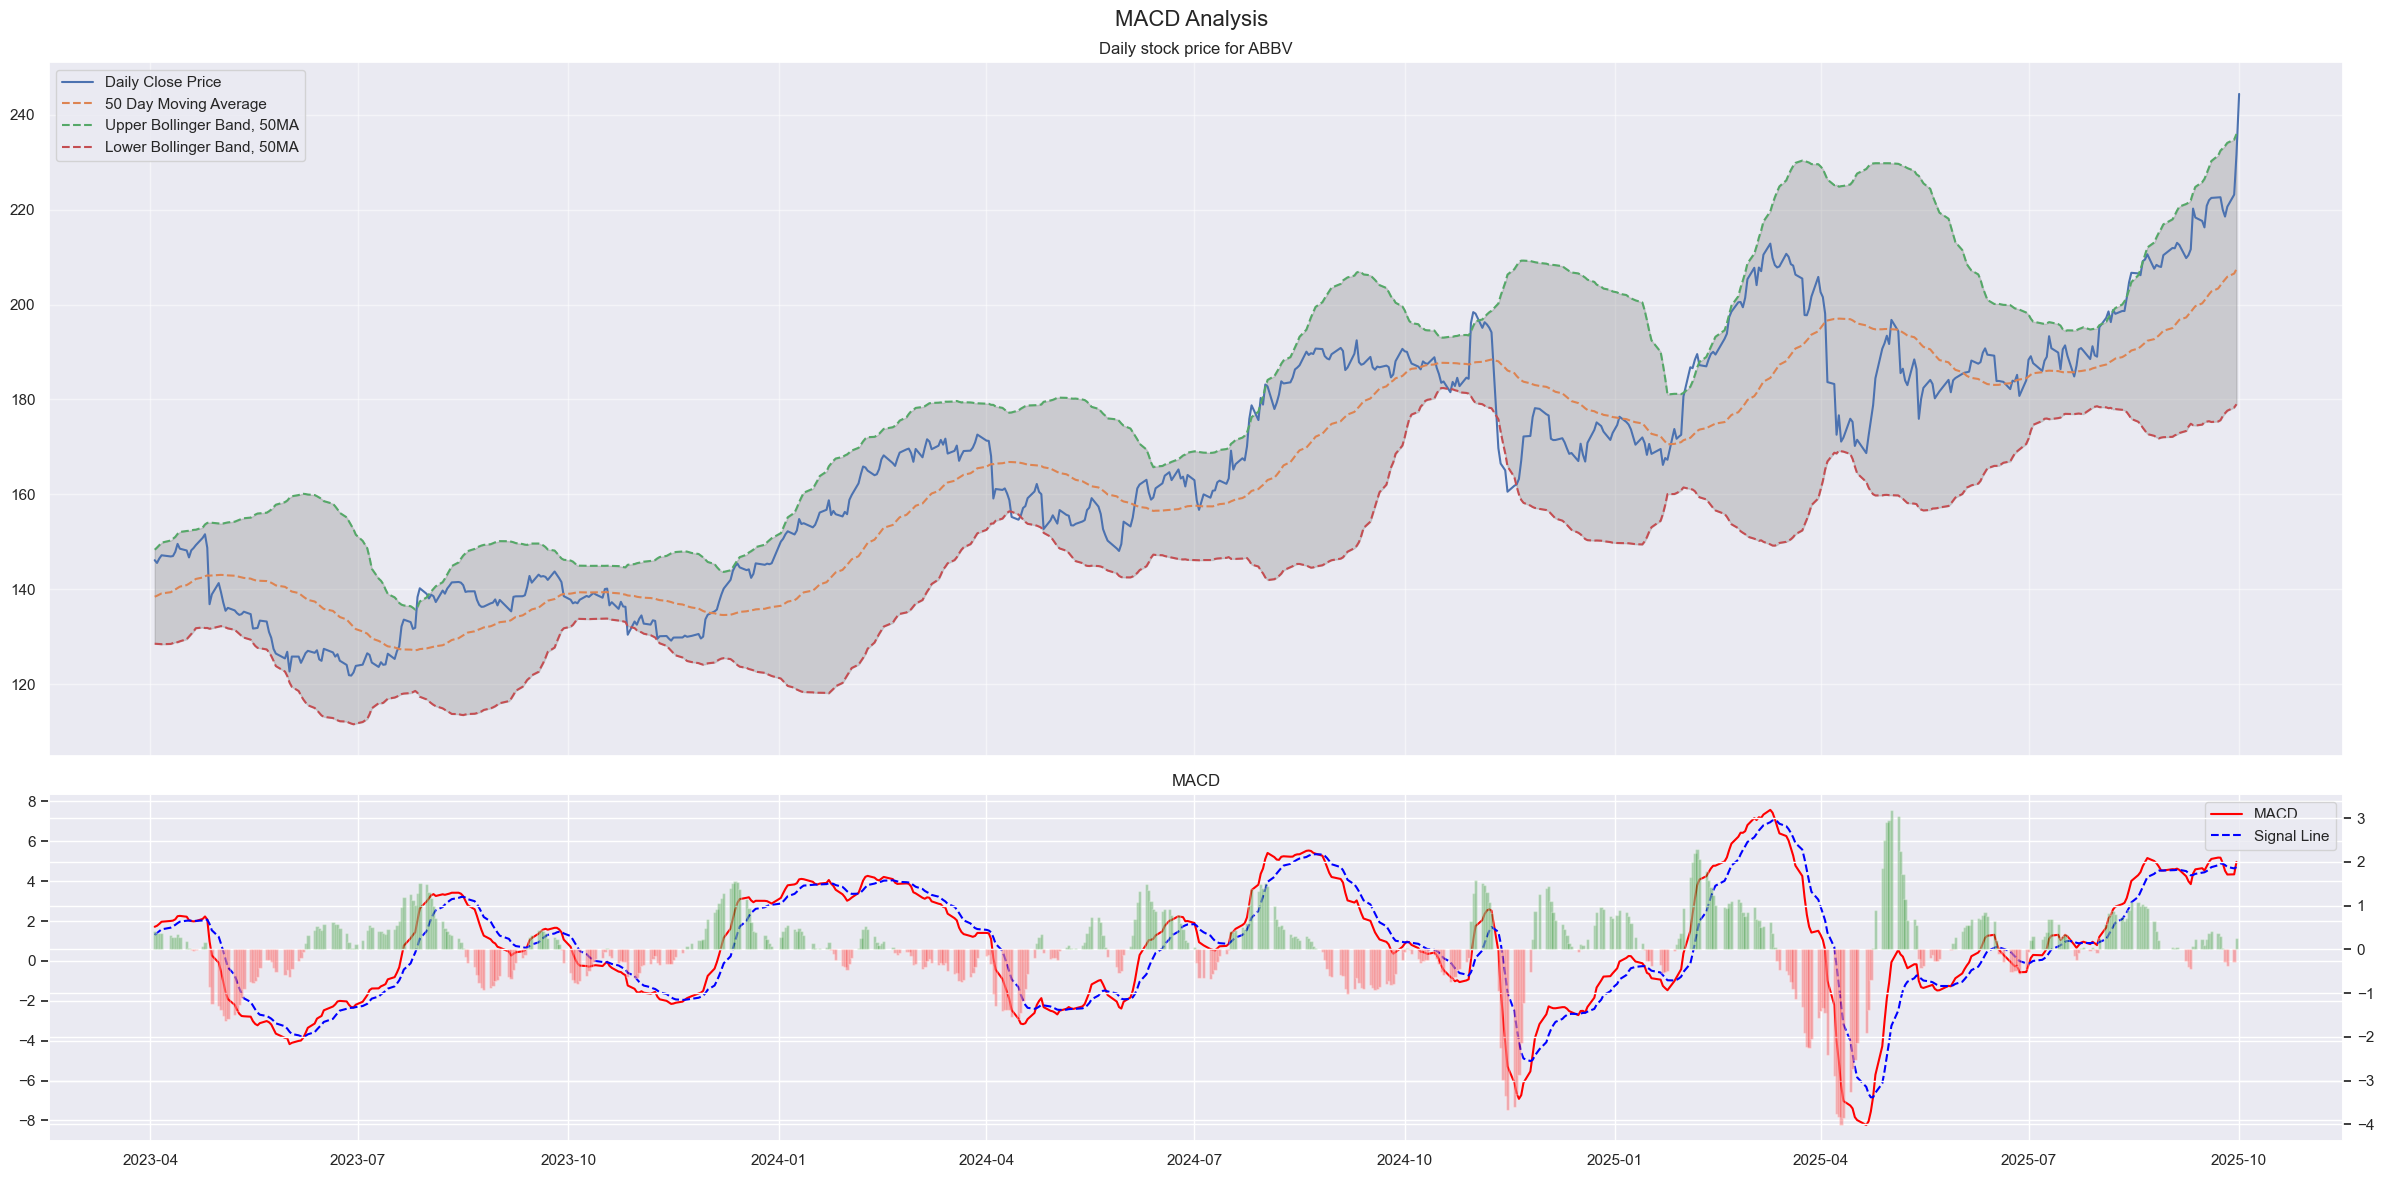

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  205.9
Regression price since 2020:  209.57


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  209.02
Current RSI: 80.03 
Current MACD Divergence: 1.37 
Tomorrow inferred RSI: 83.96 
Tomorrow inferred MACD Divergence: 1.95 


In [24]:
# 4/9/2025 min 164.39 - maximal drawback minimal, then 11/19/2024 163.8 -- regression drawback
stock_name = 'abbv'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 825.42
* Recent high: 965.15
* Current stock price is at 85.52% of recent high
Latest 5 Day MA: 734.1
Latest 5 Day EMA: 741.7
Latest 20 Day MA: 746.19
Latest Lower Bollinger Band, 20MA: 717.67
Latest Higher Bollinger Band, 20MA: 774.71
Latest 50 Day MA: 733.68
Latest Lower Bollinger Band, 50MA: 627.82
Latest Higher Bollinger Band, 50MA: 839.54
Latest 50 Day EMA: 741.73
Latest 120 Day MA: 758.45
Latest 200 Day MA: 780.67
Latest 200 Day EMA: 770.1
Latest 10 Week MA: 725.26
Latest 20 Week MA: 748.62
Latest 30 Week MA: 764.15
Latest 40 Week MA: 779.29
Latest Lower Weekly Bollinger Band, 20MA: 662.46
Latest Higher Weekly Bollinger Band, 20MA: 834.79

Latest RSI: 53.07 
Latest MACD Divergence: -1.69 
5MA break point: 732.16
5MA crosses 20MA at 823.82
20MA break point: 746.63
20MA crosses 50MA at 296.14
20MA Lower Bollinger Band break point: 712.93
20MA Upper Bollinger Band break point: 780.33
50MA break point: 732.84
50MA crosses 200MA at 3901.96
50MA Lower Bollinger B

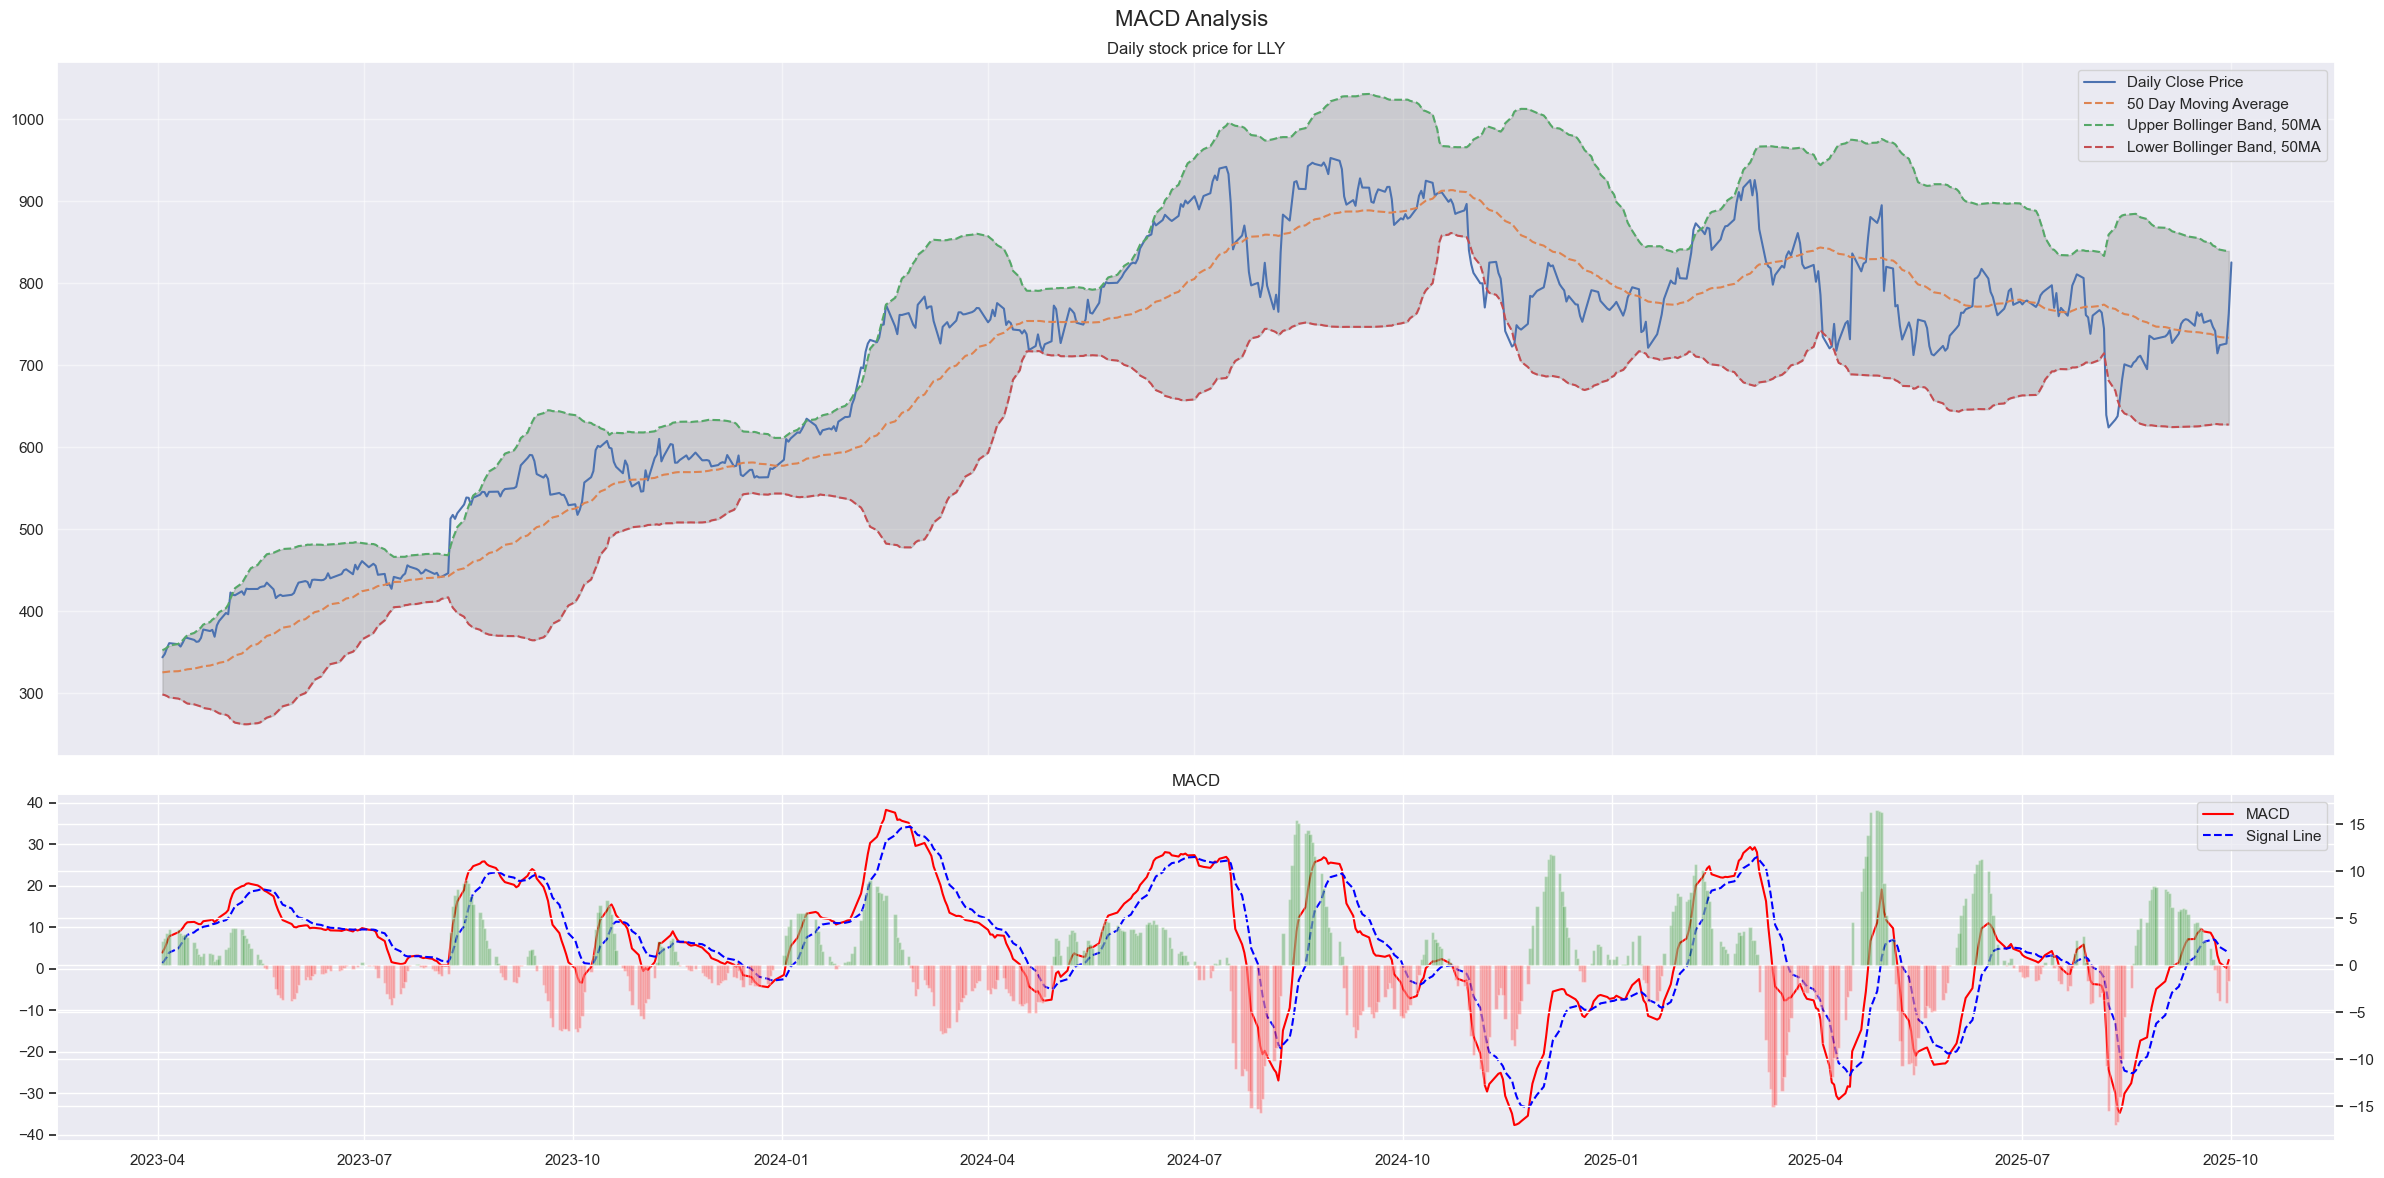

[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  982.17


[*********************100%***********************]  1 of 1 completed


Regression price since 2020:  992.4


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  991.23
Current RSI: 67.54 
Current MACD Divergence: 3.82 
Tomorrow inferred RSI: 67.85 
Tomorrow inferred MACD Divergence: 7.03 


In [25]:
# all break
# 8/8/2025 623.78, 01/18/2024 612.70
# try support 718*0.99
stock_name = 'lly'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 573.77
* Recent high: 601.77
* Current stock price is at 95.35% of recent high
Latest 5 Day MA: 567.64
Latest 5 Day EMA: 569.53
Latest 20 Day MA: 581.16
Latest Lower Bollinger Band, 20MA: 561.19
Latest Higher Bollinger Band, 20MA: 601.12
Latest 50 Day MA: 578.61
Latest Lower Bollinger Band, 50MA: 548.81
Latest Higher Bollinger Band, 50MA: 608.42
Latest 50 Day EMA: 577.1
Latest 120 Day MA: 565.95
Latest 200 Day MA: 554.66
Latest 200 Day EMA: 551.91
Latest 10 Week MA: 579.29
Latest 20 Week MA: 570.62
Latest 30 Week MA: 558.92
Latest 40 Week MA: 554.96
Latest Lower Weekly Bollinger Band, 20MA: 536.51
Latest Higher Weekly Bollinger Band, 20MA: 604.73

Latest RSI: 42.83 
Latest MACD Divergence: -2.6 
5MA break point: 567.35
5MA crosses 20MA at 650.78
20MA break point: 580.52
20MA crosses 50MA at 531.58
20MA Lower Bollinger Band break point: 557.69
20MA Upper Bollinger Band break point: 603.35
50MA break point: 579.02
50MA Lower Bollinger Band break point: 547.37
50MA 

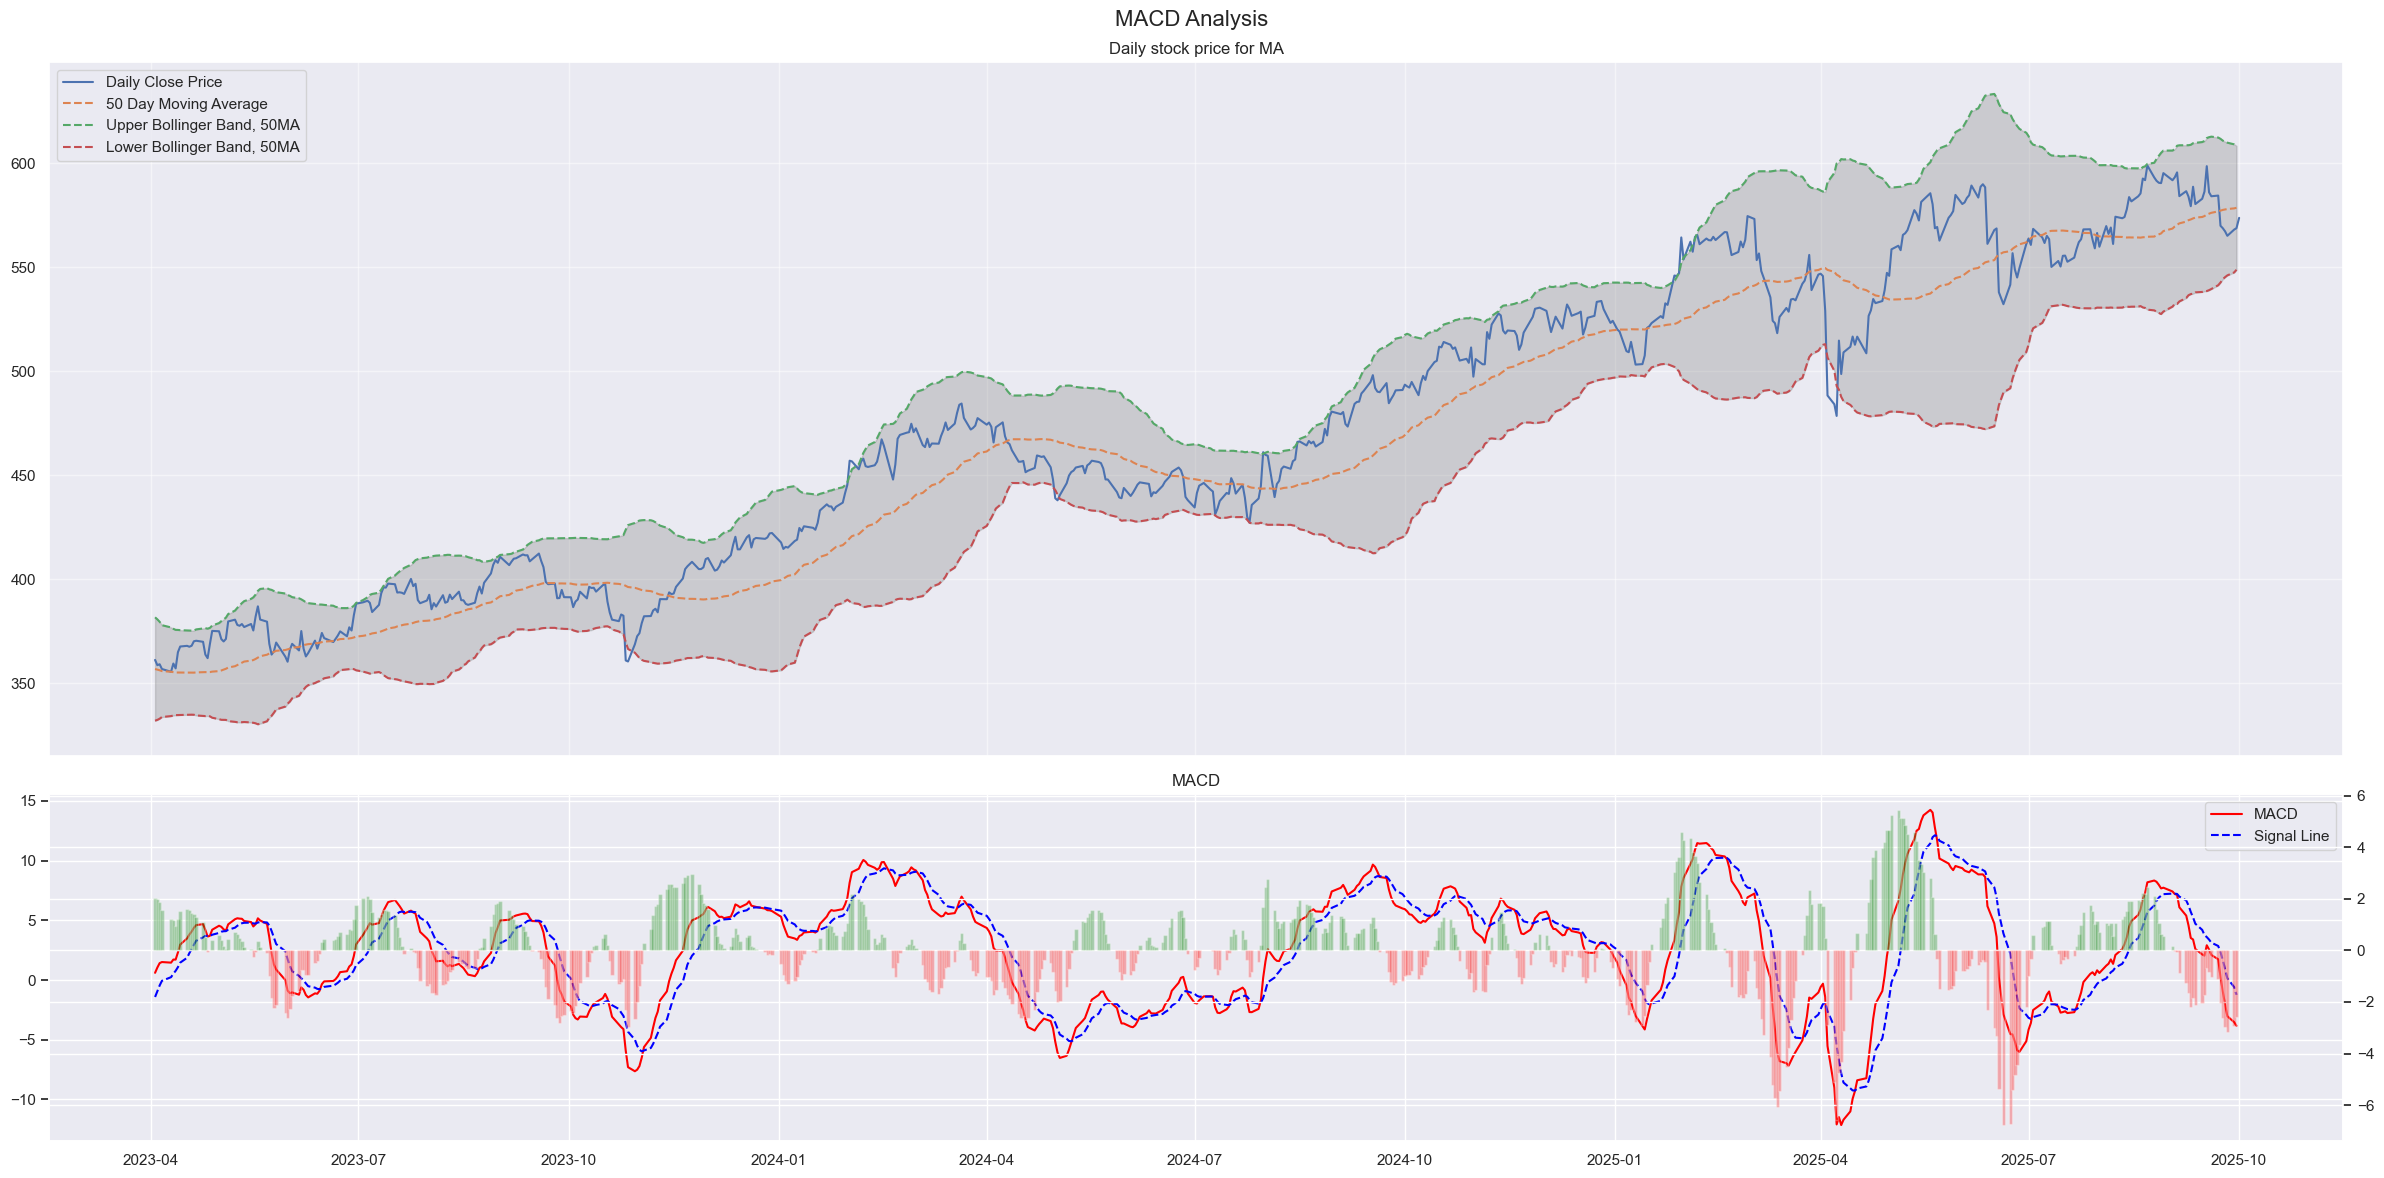

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Regression price since 2010:  600.64
Regression price since 2020:  551.58


[*********************100%***********************]  1 of 1 completed

Regression price since QE:  553.89
Current RSI: 39.21 
Current MACD Divergence: -1.91 
Tomorrow inferred RSI: 44.56 
Tomorrow inferred MACD Divergence: -1.37 


In [26]:
stock_name = 'ma'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

[*********************100%***********************]  1 of 1 completed


* Current stock price: 167.2
* Recent high: 168.28
* Current stock price is at 99.36% of recent high
Latest 5 Day MA: 163.24
Latest 5 Day EMA: 163.78
Latest 20 Day MA: 158.83
Latest Lower Bollinger Band, 20MA: 151.9
Latest Higher Bollinger Band, 20MA: 165.76
Latest 50 Day MA: 157.09
Latest Lower Bollinger Band, 50MA: 149.3
Latest Higher Bollinger Band, 50MA: 164.88
Latest 50 Day EMA: 156.01
Latest 120 Day MA: 144.75
Latest 200 Day MA: 136.18
Latest 200 Day EMA: 139.32
Latest 10 Week MA: 158.15
Latest 20 Week MA: 151.06
Latest 30 Week MA: 143.24
Latest 40 Week MA: 138.07
Latest Lower Weekly Bollinger Band, 20MA: 132.6
Latest Higher Weekly Bollinger Band, 20MA: 169.51

Latest RSI: 83.41 
Latest MACD Divergence: 0.74 
5MA break point: 163.71
5MA crosses 20MA at 133.08
20MA break point: 158.87
20MA crosses 50MA at 106.49
20MA Lower Bollinger Band break point: 150.61
20MA Upper Bollinger Band break point: 167.13
50MA break point: 157.27
50MA Lower Bollinger Band break point: 149.45
50MA Upp

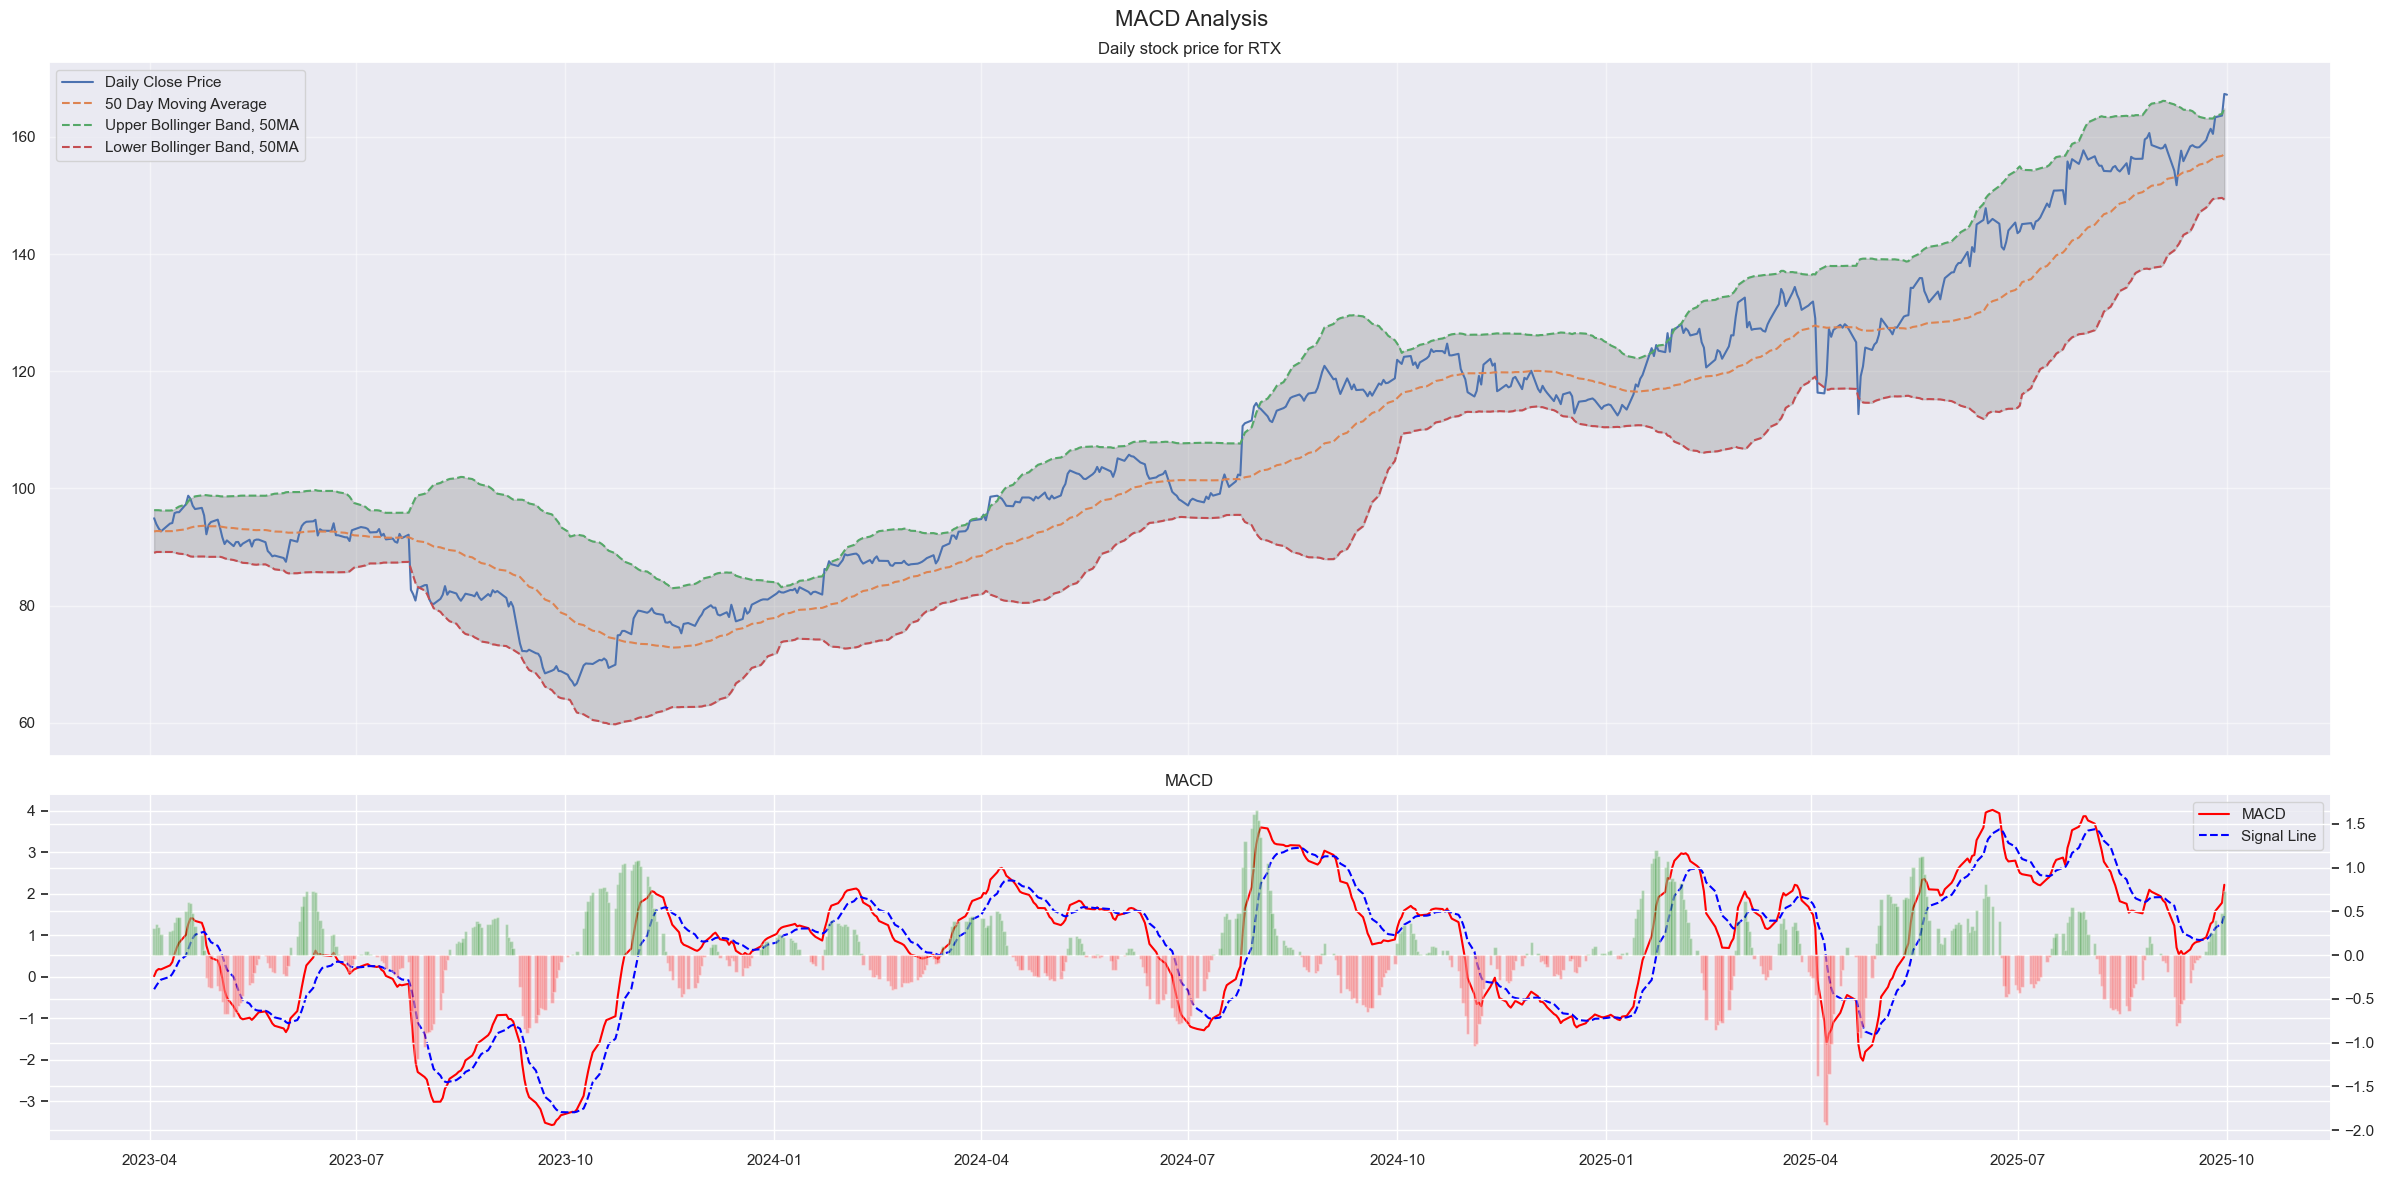

In [ ]:
stock_name = 'rtx'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
stock_name = 'ewjv'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

#### Return limited; buy low only

In [ ]:
# only buy at least 4% below regression
# lose all position since 2024Feb 
# 9/23/2025 min 150.97, 7/31/2025 min 149.91; 1/22/2024 141.87; 12/15/2023 137.34 - stop loss
# 154.4 - 150 good support
stock_name = 'pg'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# return limited; at least 5% below regression
# 2025/9/26 min 77.49, 2025/4/8 75.61
# 78.3 support

stock_name = 'xlp'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 423 (425 supp) regression drawdown lower bound
# 02/14/2025 min 419.70 -> 10/06/2023 min 393.77

stock_name = 'lmt'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 4/9/2025 low 48.55, 3/4/2025 47.60, uptrend started doubledown 3/15/2023 37.77 + 6/17/2022 38.58
stock_name = 'inda'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

## Swing

fico, nvda, avgo, fbtc not regressive

In [ ]:
# 4/3/2025 lowest 308.53, then 8/2/2024 307.05
# 307 - 319 is a support region
# 271.4 can be considered a bottom based on maximal drawback
# 317 - maximal drawback / 0.9 /0.95; 314 - regression drawback /0.9/0.95
# 40wk MA good supp
stock_name = 'cat'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
stock_name = 'itb'
# 6/2/2025 min 87.02, 4/21/2025 86.47, 4/9/2025 82.71
# maximal drawback 74.17; regression drawback 79.06

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 4/7/2025 min 439.38, then 8/5/2024 437.37
stock_name = 'gs'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 2025/4/7 min 42.21, then 8/5/2024 40.66
stock_name = 'xlf'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 6/17/2025 min 350.23, 4/21/2025 341.80; 4/9/2025 326.31
# BUY 338 supp < 342 = regression drawback /0.9
# 6/16/2025 354 supp seem to hold, next 339
stock_name = 'hd'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 2025/4/4 min 208.93, then 10/3/2024 204.34
stock_name = 'jpm'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 4/4/2025 min 178.23; 1/1/2024 163.97
# supp 200 break
stock_name = 'smh'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 2025/4/3 min 48.18
# 47.8 can be considered minimal
stock_name = 'jef'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 05/09/2025 min 378.54, break all support in 5yrs
# 388 resistance
stock_name = 'unh'

try:
    stg = stock_strategy(stock_name, start='2019-01-01')
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# not regressible since 2010
stock_name = 'orcl'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# 8/14/2025 min 1300, maximal drawback since QE
stock_name = 'fico'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
    # stg.atr_drawdown_thresholds() # use this after breakout to confirm
except:
    pass

In [ ]:
# 118 supp?
# horizontal support not realy working
# try 20wk MA as support
stock_name = 'nvda'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# try 20wk MA as support

stock_name = 'avgo'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# buy 20wk MA

try:
    stock_name = 'fbtc'
    stg = stock_strategy(stock_name)
    stg.print_info()
    # stock_strategy(stock_name,strategy='daily').output()
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    stg.latest_metric()
    stg.infer_metric()
except:
    pass
try:
    stock_name = 'btc-usd'
    # stock_strategy(stock_name).output()
    stg = stock_strategy(stock_name, strategy='daily')
    stg.plot_daily_chart(interactive_plot=False)
    stg.plot_weekly_chart() # 40 wk MA strong supp
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
except:
    pass

In [ ]:
# not regressible since 2020
# it will break all trendline; just start buy when lowest trendline is broken
stock_name = 'jnj'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart() # not useful; simply swing
    # stg.plot_daily_vwap()
    # stg.calculate_anchored_vwap() # mostly useless
    print('Regression price since 2010: ', stock_regression(stock_name)['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

## REF

In [ ]:
# 7/30/2025 min 300.96, 6/27/2025 299.89, 5/16/2025 291.78; try 280
# 240 strong supp
stock_name = 'gld'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    stg.plot_weekly_chart()
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
stock_name = 'uso'
try:
    stg = stock_strategy(stock_name, strategy='daily')
    stg.output()
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
stock_name = 'CNY=X'
try:
    stg = stock_strategy(stock_name, start='2019-01-01', strategy='daily')
    stg.output()
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
stock_name = 'DX-Y.NYB'

try:
    stg = stock_strategy(stock_name, strategy='daily')
    stg.output()
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

## Gamble & Bought, so let's find the right place to sell

In [ ]:
# Very strong supp: (41.6 never reached) - 41.9 - 42.3; 48 strong supp
# 51 strong supp
stock_name = 'fngs'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    print('Regression price since 2020: ', stock_regression(stock_name, regression_start='2020-01-01')['fitted'])
    print('Regression price since QE: ', stock_regression(stock_name, regression_start='2020-03-20')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass


In [ ]:
# 3/28/2024 high 123.74 -> 8/8/2024 low 83.91, 32% withdraw
# 11/27/2024 high 118.2 -> 4/7/2024 80.1, 32% withdraw
# just buy when 30% withdraw

stock_name = 'dis'

try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart() # not useful
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
stock_name = 'panw'
try:
    # buy 20wk MA
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart()
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# not regressible, except from 2022-08-01
# 2021-02-25 high 98.16 -> 2022-07-14 low 30.75: -68.67%
# 2025-01-31 high 275.34 -> 2025-04-07 low 163.55: -40.60%
# try buy 20wk MA
stock_name = 'rcl'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_daily_vwap()
    # stg.plot_weekly_chart() # 20wk MA and 30wk MA almost same
    print('Regression price since 2022-08-01: ', stock_regression(stock_name, regression_start='2022-08-01')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# not regressible, except from 2023-01-01
# try buy 50day MA, if break, 20wk MA
stock_name = 'pltr'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart() # 20wk MA
    print('Regression price since 2023-01-01: ', stock_regression(stock_name, regression_start='2023-01-01')['fitted'])
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
stock_name = 'tsla'
# 2021-11-04 high 414.5 -> 2023-01-06 low 101.81: 75% withdraw
# 2023-07-19 high 299.29 -> 2024-04-22 low 138.8: -53.62% withdraw
# 2024-12-18 high 488.54 -> 2025-04-07 low 214.25: -56.14% withdraw
# buy when 50% withdraw
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart() # not useful
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
# can by feth when -50%
stock_name = 'eth-usd'
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart() # not useful
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

In [ ]:
try:
    hpq_strategy = stock_strategy('hpq', start="2021-02-01")
    df_check = hpq_strategy.return_result()
    hpq_strategy.output(interactive_plot=True)
    # mostly between Bollinger band
    # print(df_check[df_check['close']>=df_check['Upper Band - 50MA']].shape[0] / df_check.shape[0])
    # print(df_check[df_check['close']<=df_check['Lower Band - 50MA']].shape[0] / df_check.shape[0])
    stock_strategy('hpq').latest_metric()
    stock_strategy('hpq').infer_metric()
except:
    pass

In [ ]:
# Stock in tip_only: maximal withdraw ~70%; attention when 65%
for stock_name in list_tip_only:
    print(f"stock_name: {stock_name}")
    try:
        stock_info = stock_strategy(stock_name)
        print(f"Historical high: {round(stock_info.df['high'].max(), 2)}")    
        print(f"Current price {round(stock_info.ticker['Close'].tolist()[0],2)} at {round(stock_info.ticker['Close'].tolist()[0] / stock_info.df['high'].max(),4)}")
    except:
        print(f"{stock_name} cannot be downloaded")
        pass

In [ ]:
# 3/18/2020 min 128.85; last support 148-
# consider buy 155-
stock_name = 'lulu'
# stock_strategy(stock_name, start='2018-01-01', strategy='daily').output()
try:
    stg = stock_strategy(stock_name)
    stg.output()
    # stg.plot_weekly_chart() # not useful
    # stg.plot_daily_vwap()
    stg.latest_metric()
    stg.infer_metric()
except:
    pass

## Regression
* Only need to check this weekly - every Tuesday

In [ ]:
new_prices = []
for stock_name in list_base + list_swing + ['gld', 'jnj', 'rcl']:
    new_price = stock_strategy(stock_name).ticker['Close'].tolist()[0]
    new_prices.append(round(new_price,2))
for e in new_prices:
    print(e)

In [ ]:
if datetime.today().weekday() == 0:
    for stock_name in list_base + list_swing:
        stock_regression(stock_name, detailed=True)
else:
    pass

In [ ]:
if datetime.today().weekday() == 0:
    for stock_name in list_base + list_swing:
        stock_regression(stock_name, regression_start='2020-01-01', detailed=True)
else:
    pass

In [ ]:
if datetime.today().weekday() == 0:
    for stock_name in list_base + list_swing:
        stock_regression(stock_name, regression_start='2020-03-20', detailed=True)
else:
    pass

### Check Correlation - only needed if multiple triggered

In [ ]:
def avg_correlation(corr_matrix: np.ndarray) -> float:
    """Compute average pairwise correlation (off-diagonal mean)."""
    n = corr_matrix.shape[0]
    upper = corr_matrix[np.triu_indices(n, k=1)]
    return upper.mean()

def market_mode_strength(corr_matrix: np.ndarray) -> float:
    """Compute normalized largest eigenvalue (market mode strength)."""
    eigvals = np.linalg.eigvalsh(corr_matrix)
    return eigvals[-1] / corr_matrix.shape[0]

def greedy_correlation_reduction(prices: pd.DataFrame, 
                                 method: str = "avg_corr", 
                                 must_keep: list = None):
    """
    Greedy backward elimination to minimize correlation concentration,
    with a set of must-keep assets.
    
    Parameters
    ----------
    prices : pd.DataFrame
        Daily price data (rows = time, cols = assets).
    method : str
        Either "avg_corr" or "market_mode".
    must_keep : list
        List of assets that must always remain in the portfolio.
    
    Returns
    -------
    dict
        {
            "best_assets": list of remaining assets when objective is minimized,
            "best_value": float (lowest avg_corr or market_mode),
            "value_path": list of objective values at each step,
            "removal_order": list of removed assets
        }
    """
    rets = prices.pct_change().dropna()
    assets = list(rets.columns)
    
    if must_keep is None:
        must_keep = []
    must_keep = list(set(must_keep))  # ensure uniqueness
    
    value_path = []
    removal_order = []
    best_value = np.inf
    best_assets = assets.copy()
    
    while len(assets) > len(must_keep):
        # compute correlation matrix for current set
        corr = rets[assets].corr().values
        
        if method == "avg_corr":
            val = avg_correlation(corr)
        elif method == "market_mode":
            val = market_mode_strength(corr)
        else:
            raise ValueError("method must be 'avg_corr' or 'market_mode'")
        
        value_path.append(val)
        
        if val < best_value:
            best_value = val
            best_assets = assets.copy()
        
        if len(assets) == len(must_keep) + 1:
            break  # stop before removing any must_keep
        
        # test removing each asset (except must_keep)
        candidate_vals = {}
        for asset in assets:
            if asset in must_keep:
                continue
            remaining = [a for a in assets if a != asset]
            corr_sub = rets[remaining].corr().values
            if method == "avg_corr":
                candidate_vals[asset] = avg_correlation(corr_sub)
            else:
                candidate_vals[asset] = market_mode_strength(corr_sub)
        
        # remove the asset that minimizes the objective
        asset_to_remove = min(candidate_vals, key=candidate_vals.get)
        removal_order.append(asset_to_remove)
        assets.remove(asset_to_remove)
    
    return {
        "best_assets": best_assets,
        "best_value": best_value,
        "value_path": value_path,
        "removal_order": removal_order
    }

In [ ]:
stock_list = list_base + list_swing + ['gld']
l_dfs = []

for stock_name in stock_list:
    df = yf.download(stock_name.upper(), start='2020-01-01', end=datetime.today().strftime('%Y-%m-%d')).droplevel(level='Ticker', axis=1)
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    df['name'] = stock_name
    l_dfs.append(df[['name', 'date', 'close']])

df_all = pd.concat(l_dfs)
pivot_df = df_all[['date','close', 'name']].pivot(index='date', columns='name', values='close')
print(pivot_df.shape)

must_keep_assets = ['voo', 'gld', 'brk-b']
res_avg = greedy_correlation_reduction(pivot_df, method="avg_corr", must_keep=must_keep_assets)
res_mm  = greedy_correlation_reduction(pivot_df, method="market_mode", must_keep=must_keep_assets)
print("Best subset (avg corr):", res_avg["best_assets"])
print("Best subset (market mode):", res_mm["best_assets"]) 

In [ ]:
correlation_matrix = pivot_df[res_avg["best_assets"]].corr()

high_correlation = correlation_matrix[correlation_matrix >= 0.9]

plt.figure(figsize=(20, 16))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('High Correlation Matrix (>= 0.9) of Daily Stock Prices')
plt.show()

In [ ]:
correlation_matrix = pivot_df[res_mm["best_assets"]].corr()

high_correlation = correlation_matrix[correlation_matrix >= 0.9]

plt.figure(figsize=(20, 16))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('High Correlation Matrix (>= 0.9) of Daily Stock Prices')
plt.show()

### Gamble - meme stocks

Backup only

In [ ]:
# import requests
# from bs4 import BeautifulSoup

# # Define URL to scrape
# url = "https://finance.yahoo.com/most-active/"

# # Get the webpage content
# response = requests.get(url)
# response.raise_for_status()  # Raise exception for unsuccessful requests

# # Parse HTML content
# soup = BeautifulSoup(response.content, 'html.parser')

# # Find the container holding stock names (inspect the webpage's HTML)
# all_tables = soup.find_all('table')
# for table in all_tables:
#   # Check for presence of headers containing "Symbol", "Name", "Price" etc.
#   if any(header.text.strip() in ("Symbol", "Name", "Price") for header in table.find_all('th')):
#     stock_table = table
#     break
# stock_names = []
# if stock_table:
#   for row in stock_table.find_all('tr'):
#     name_cell = row.find('td', {'aria-label': 'Symbol'})
#     if name_cell:
#       stock_names.append(name_cell.text.strip())

# # Print the extracted list
# print(stock_names)

In [ ]:
# list_new_meme = [
# "BURU",
# "AITX",
# "STSS",
# "NSAV",
# "HMBL",
# "INKW",
# "NVDA",
# "LGVN",
# "RONN",
# "BRTX",
# "OZSC",
# "NCI",
# "WHEN",
# "IGPK",
# "KYNC",
# "DPLS",
# "ILUS",
# "TSLA",
# "BCAP",
# "CERO",
# "AAPL",
# "CYN",
# "CRKN",
# "MRVL",
# "WKHS",
# "DIDIY",
# "VLD",
# "LTNC",
# "GME",
# "AONC",
# "ENZC"
# ]

In [ ]:
# with open ('../list_meme_static', 'rb') as fp:
#     list_meme_static = pickle.load(fp)
# for e in list_new_meme:
#     if e not in list_meme_static:
#         list_meme_static.append(e)
# list_meme_static = list(set(list_meme_static))
# with open ('../list_meme_static', 'wb') as fp:
#     pickle.dump(list_meme_static, fp)

# with open ('../list_meme_static', 'rb') as fp:
#     list_meme_static = pickle.load(fp)
# print('Static meme stocks:', len(list_meme_static))

In [ ]:
# # we can pull additional meme stock below from https://www.quiverquant.com/scores/memestocks

# import requests
# from bs4 import BeautifulSoup

# def get_stock_names(url):
#   """Extracts stock names from a given URL.

#   Args:
#     url: The URL of the webpage containing the stock names.

#   Returns:
#     A list of stock names.
#   """

#   response = requests.get(url)
#   soup = BeautifulSoup(response.content, 'html.parser')

#   # Find the table containing the stock names
#   table = soup.find('table')

#   # Extract stock names from table rows
#   stock_names = []
#   for row in table.find_all('tr')[1:]:
#     cells = row.find_all('td')
#     if cells:
#       stock_names.append(cells[1].text.strip().split('\n')[0])

#   return stock_names

# # Example usage
# url = 'https://www.quiverquant.com/scores/memestocks'
# stock_names = get_stock_names(url)
# print('Added dynamically:', len(stock_names))

# # list_meme = list(set(stock_names+list_meme_static))
# list_meme = list(set(stock_names+list_new_meme))
# print('All meme stocks:', len(list_meme))


In [ ]:
# obj = stock_strategy('AMC', start=(datetime.today() - relativedelta(months=24)).strftime('%Y-%m-%d'),
#                      end=datetime.today().strftime('%Y-%m-%d'))
# obj.latest_metric(print_result=False)

# print('Volume:', obj.df['volume'].mean(), obj.ticker['Volume'][0], obj.ticker['Volume'][0] / obj.df['volume'].mean())
# print('RSI:', obj.df.tail(1)['RSI'].tolist()[0], obj.curr_rsi)
# print('MACD:', obj.df.tail(1)['MACD_diff'].tolist()[0], obj.curr_macd)
# obj.df.tail(5)

In [ ]:
# dict_meme = dict({'stock_name':[],
#                   'avg_vol':[],
#                   'curr_vol':[],
#                   'vol_ratio':[],
#                   'old_rsi':[],
#                   'old_macd':[],
#                   'curr_rsi':[],
#                   'curr_macd':[],                  
#                  })
# list_to_check1 = []
# list_to_check2 = []

# for e in list_meme:
#     try:
#         obj = stock_strategy(e,
#                              start=(datetime.today() - relativedelta(months=3)).strftime('%Y-%m-%d'),
#                              end=datetime.today().strftime('%Y-%m-%d'))
#         obj.latest_metric(print_result=False)
#         avg_vol = obj.df['volume'].mean()
#         ticker = yf.Ticker(e.upper()).history(period='1d')
#         curr_vol = ticker['Volume'][0]
#         vol_ratio = curr_vol / avg_vol
#         old_rsi = obj.df.tail(1)['RSI'].tolist()[0]
#         old_macd = obj.df.tail(1)['MACD_diff'].tolist()[0]
#         curr_rsi = obj.curr_rsi
#         curr_macd = obj.curr_macd
#         dict_meme['stock_name'].append(e)
#         dict_meme['avg_vol'].append(avg_vol)
#         dict_meme['curr_vol'].append(curr_vol)
#         dict_meme['vol_ratio'].append(vol_ratio)
#         dict_meme['old_rsi'].append(old_rsi)
#         dict_meme['old_macd'].append(old_macd)
#         dict_meme['curr_rsi'].append(curr_rsi)
#         dict_meme['curr_macd'].append(curr_macd)
#         if vol_ratio > 1 and old_rsi < 70 and curr_rsi > 50 and curr_rsi > old_rsi and curr_macd > old_macd and curr_macd > 0:
#             list_to_check1.append(e)
#         if vol_ratio > 1 and curr_rsi > 60 and curr_rsi > old_rsi and curr_macd > old_macd:
#             list_to_check2.append(e)
#     except:
# print(list_to_check1)
# print(list_to_check2)

# df_meme = pd.DataFrame(dict_meme)

In [ ]:
# # for safety, one can have curr_macd > 1.5*old_macd
# df_meme['macd_increase'] = (df_meme['curr_macd'] - df_meme['old_macd'])/df_meme['curr_macd']
# df_meme[df_meme['stock_name'].isin(list_to_check1+list_to_check2)].sort_values(by='macd_increase',ascending=False)

In [ ]:
# df_meme[(df_meme['stock_name'].isin(list_to_check1+list_to_check2)) & (df_meme['curr_macd']>1.5*df_meme['old_macd'])].sort_values(by='vol_ratio', ascending=False)

### Test a "momentum driven" strategy

No good

In [ ]:
stock_name = (list_base + [e for e in list_swing if e != 'fbtc'] + list_ref)[0]
df_all = yf.download(stock_name.upper(),
                 start='2020-01-01',
                 end=datetime.today().strftime('%Y-%m-%d'),
                 prepost=True,
                 auto_adjust=True).droplevel(level='Ticker', axis=1)[['Close']]
df_all = df_all.rename(columns={'Close': stock_name})
for stock_name in (list_base + [e for e in list_swing if e != 'fbtc'] + list_ref)[1:]:
    df = yf.download(stock_name.upper(),
                 start='2020-01-01',
                 end=datetime.today().strftime('%Y-%m-%d'),
                 prepost=True,
                 auto_adjust=True).droplevel(level='Ticker', axis=1)[['Close']]
    df = df.rename(columns={'Close': stock_name})
    df_all = pd.merge(df_all, df, left_index=True, right_index=True, how='inner')
df_all

In [ ]:
def backtest_momentum_strategy(price_df,
                               initial_cash=100_000,
                               cycle=21,
                               start_index = 21,
                               window=20,
                               sell_early=False,
                               test_horizon=252):

    """
    Backtest the momentum strategy with X-trading-day evaluation cycle.
    Returns:
        result_df: Daily portfolio value DataFrame
        actions_df: Log of only buy/sell actions
    """
    price_df = price_df.sort_index()
    
    # cycle-day moving average
    ma = price_df.rolling(window=window).mean()
    
    # cycle-day % change
    pct_change = price_df.pct_change(cycle)
    
    # Portfolio state
    cash = initial_cash
    shares = 0
    current_stock = None
    portfolio_values = []
    actions = []

    dates = price_df.index
    
    end_index = start_index + test_horizon
    # for i in range(cycle, len(dates)):  # start from the 22nd trading day
    for i in range(start_index, end_index):  # Check performance for one year
        date = dates[i]
        
        # Step (1): every cycle trading days, rebalance
        if (i - cycle) % cycle == 0:
            # Sell previous stock if any
            if current_stock is not None:
                sell_price = price_df.loc[date, current_stock]
                cash += shares * sell_price
                actions.append([date, "SELL", current_stock, sell_price, shares])
                shares = 0
                current_stock = None
            
            # Find candidates above ma
            candidates = [s for s in price_df.columns 
                          if price_df.loc[date, s] > ma.loc[date, s]]
            
            if candidates:
                # Pick stock with largest cycle-day % change
                stock_changes = pct_change.loc[date, candidates]
                pick = stock_changes.idxmax()
                buy_price = price_df.loc[date, pick]
                current_stock = pick
                shares = cash // buy_price
                cash -= shares * buy_price
                actions.append([date, "BUY", pick, buy_price, shares])
        
        # Step (2): sell early if price drops below ma
        if sell_early and current_stock is not None:
            if price_df.loc[date, current_stock] < ma.loc[date, current_stock]:
                sell_price = price_df.loc[date, current_stock]
                cash += shares * sell_price
                actions.append([date, "SELL_EARLY", current_stock, sell_price, shares])
                shares = 0
                current_stock = None
        
        # Record portfolio value
        if current_stock is not None:
            value = cash + shares * price_df.loc[date, current_stock]
        else:
            value = cash
        portfolio_values.append((date, value))
    
    # Create results DataFrames
    result_df = pd.DataFrame(portfolio_values, columns=["Date", "PortfolioValue"])
    result_df.set_index("Date", inplace=True)
    
    actions_df = pd.DataFrame(actions, columns=["Date", "Action", "Stock", "Price", "Shares"])
    actions_df.set_index("Date", inplace=True)
    
    total_days = len(result_df)
    final_value = result_df["PortfolioValue"].iloc[-1]
    annualized_return = (final_value / initial_cash) ** (252 / total_days) - 1
    
    return result_df, actions_df, annualized_return


def average_annualized_return(price_df, initial_cash=100_000, n_test=100, cycle=21, window=20, sell_early=False, test_horizon=252):
    """
    Runs the strategy from different starting offsets (0-20) and averages annualized return.
    """
    np.random.seed(42)  # reproducibility, can remove if not needed
    
    valid_start_range = range(21, len(price_df) - 252)  # ensure full year ahead
    start_points = np.random.choice(valid_start_range, size=n_test, replace=False)
    
    returns = []
    for start in start_points:
        _, _, ann_return = backtest_momentum_strategy(price_df,
                                                      initial_cash=initial_cash,
                                                      cycle=cycle,
                                                      start_index=start,
                                                      window=window,
                                                      sell_early=sell_early,
                                                      test_horizon=test_horizon)
        if not np.isnan(ann_return):
            returns.append(ann_return)
    print(f"Average return: {np.mean(returns) if returns else np.nan}")
    print(f"Return STD: {np.std(returns) if returns else np.nan}")
    print(f"earning-cost ratio: {abs((np.mean(returns)+1.96*np.std(returns))/(np.mean(returns)-1.96*np.std(returns))) if returns else np.nan}")
    return returns

def momentum_strategy(price_df, cycle=21, window=20):
    price_df = price_df.sort_index()  
    # cycle-day moving average
    ma = price_df.rolling(window=window).mean()
    # cycle-day % change
    pct_change = price_df.pct_change(cycle)
    dates = price_df.index
    date = dates[-1]
    candidates = [s for s in price_df.columns 
                          if price_df.loc[date, s] > ma.loc[date, s]]
    if candidates:
                # Pick stock with largest cycle-day % change
                stock_changes = pct_change.loc[date, candidates]
                pick = stock_changes.idxmax()
    print(pick)

In [ ]:
result_df, actions_df, annualized_return = backtest_momentum_strategy(df_all, cycle=63, window=50)
print(annualized_return)
result_df

In [ ]:
actions_df

In [ ]:
returns = average_annualized_return(df_all, initial_cash=100000, cycle=63, window=50, n_test=800)

In [ ]:
momentum_strategy(df_all,  cycle=63, window=50)

In [ ]:
# Benchmark
for stock_name in ['brk-b', 'cost', 'rsg', 'wm', 'azo', 'voo','xlk','spmo','xlv','gld']:
    df_stock = stock_strategy(stock_name, start='2020-01-01').return_result()[['date', 'close']]
    df_stock.set_index('date',inplace=True)
    valid_start_range = range(0, len(df_stock) - 252)
    start_points = np.random.choice(valid_start_range, size=800, replace=False)
    returns = []
    for start in start_points:
        dates = df_stock.index
        initial_date = dates[start]
        end_date = dates[start + 252]
        initial_price = df_stock.loc[initial_date]['close']
        end_price = df_stock.loc[end_date]['close']
        returns.append(end_price/initial_price - 1)
    print(stock_name)
    print(f"Average return: {np.mean(returns) if returns else np.nan}")
    print(f"Return STD: {np.std(returns) if returns else np.nan}")
    print(f"profit-loss ratio: {abs((np.mean(returns)+1.96*np.std(returns))/(np.mean(returns)-1.96*np.std(returns))) if returns else np.nan}")

In [ ]:
# Try daily
for stock_name in ['brk-b', 'cost', 'rsg', 'wm', 'azo', 'voo','xlk','spmo','xlv','gld']:
    df_stock = stock_strategy(stock_name, start='2020-01-01').return_result()[['date', 'close']]
    df_stock.set_index('date',inplace=True)
    rets = df_stock.pct_change().dropna()
    mean_daily = rets.mean()
    vol_daily = rets.std()
    ret_annual = mean_daily[0] * 252
    vol_annual = vol_daily[0] * np.sqrt(252)
    sharpe = (ret_annual - 0.05) / vol_annual
    
    print(stock_name)
    print(f"Average annual return: {ret_annual if ret_annual else np.nan}")
    print(f"Return annual STD: {vol_annual if vol_annual else np.nan}")
    print(f"profit-loss ratio: {abs((ret_annual+1.96*vol_annual)/(ret_annual-1.96*vol_annual)) if ret_annual else np.nan}")
    print(f"Sharpe: {sharpe}")

### An All-weather portfolio

In [ ]:
start_date = "2016-01-01"
tickers = ["BRK-B", "XLK", "COST", "RSG", "XLV", "TLT", "VGIT", "VGSH", "GLD", "BTC-USD"]
benchmark = "VOO"
data = yf.download(tickers, start=start_date, auto_adjust=True).droplevel(level='Ticker', axis=1)['Close']
bench = yf.download(benchmark, start=start_date, auto_adjust=True).droplevel(level='Ticker', axis=1)['Close']

rets = data.pct_change().dropna()
bench_rets = bench.pct_change().dropna()

# --------------------------
# Example weights (your 10/15 style allocation)
# --------------------------
weights = {
    "BRK-B": 0.10,
    "XLK":   0.15,
    "COST":  0.10,
    "RACE":  0.05,
    "RSG":   0.10,
    "XLV":   0.10,
    "TLT":   0.0625,
    "VGIT":  0.06,
    "VGSH":  0.1,
    "GLD":   0.15,
    "BTC-USD": 0.025
}

# Ensure weights match downloaded tickers order and normalize if any ticker missing
available_tickers = list(rets.columns)
w = np.array([weights[t] if t in weights else 0.0 for t in tickers])
if w.sum() == 0:
    raise ValueError("No overlapping tickers found between `data` and `weights`.")
w = w / w.sum()  # normalize to sum to 1

# --------------------------
# Compute portfolio daily P/L and cumulative wealth
# --------------------------
# Use common index between portfolio returns and benchmark for plotting
common_idx = rets.index
if isinstance(bench_rets, pd.Series):
    common_idx = rets.index.intersection(bench_rets.index)

port_daily = (rets.loc[common_idx] @ w)
port_cum = (1 + port_daily).cumprod()

# Benchmark cumulative (only if benchmark downloaded)
if benchmark in bench_rets.index or (isinstance(bench_rets, pd.Series) and not bench_rets.empty):
    bench_common_idx = bench_rets.index.intersection(common_idx)
    if len(bench_common_idx) > 0:
        bench_cum = (1 + bench_rets.loc[bench_common_idx]).cumprod()
    else:
        bench_cum = None
else:
    bench_cum = None

# --------------------------
# Print simple stats
# --------------------------
mean_daily = port_daily.mean()
vol_daily = port_daily.std()
ret_annual = mean_daily * 252
vol_annual = vol_daily * np.sqrt(252)
sharpe = (ret_annual - 0.05) / vol_annual

running_max = port_cum.cummax()
dd = (port_cum - running_max) / running_max
max_dd = dd.min()

print("Portfolio stats:")
print(f"Annualized return: {ret_annual:.2%}")
print(f"Annualized vol:    {vol_annual:.2%}")
print(f"Sharpe (rf=5%):    {sharpe:.2f}")
print(f"Max drawdown:      {max_dd:.2%}")

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(port_cum.index, port_cum.values, label="Portfolio", linewidth=2)
if bench_cum is not None:
    # align bench_cum to port_cum timeframe for plotting
    bench_cum = bench_cum.reindex(port_cum.index).ffill()
    plt.plot(port_cum.index, bench_cum.values, label=f"{benchmark}", alpha=0.8)
plt.title("Portfolio vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (growth of 1)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Some Random Research

In [ ]:
# df = yf.download('^N225',
#             start='1989-01-01',
#             auto_adjust=False).droplevel(level='Ticker', axis=1)
# df = df.reset_index()
# df.columns = df.columns.str.lower()
# print(df.loc[df[df['date']<='1990-01-01']['high'].idxmax()])
# print(df.loc[df['low'].idxmin()])

In [ ]:
# # Get PB/PE data for Nikkei 225
# import requests
# def scrape_nikkei_data(start_year: int = 2022,
#                        end_year: int = 2025,
#                        pb_pe: str = 'pe'):
#     '''
#     Nikkei 225 Historical Data: https://indexes.nikkei.co.jp/en/nkave/archives/data
#     https://indexes.nikkei.co.jp/en/nkave/statistics/dataload?list=per&year={year}&month={month} for PE
#     https://indexes.nikkei.co.jp/en/nkave/statistics/dataload?list=pbr&year={year}&month={month} for PB
#     Reference: https://en.macromicro.me/charts/95007/japan-nikkei225
    
#     Args:
#         start_year (int): The starting year for data scraping.
#         end_year (int): The ending year for data scraping.
#                         Note: scraping many years of data at once can result in request denial.
#                         Try every ten years at once.
#         pb_pe (str): The type of data to scrape ('pe' for PE, 'pb' for PB).
#                      Note: The URL parameter is always 'per', but this helps
#                      distinguish which data you are targeting.

#     Return:
#         pd.DataFrame of historical daily PE/PB value between start_year and end_year
#     '''
#     base_url = "https://indexes.nikkei.co.jp/en/nkave/statistics/dataload?list="
#     url = base_url + pb_pe + 'r'
#     all_data = []

#     headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

#     print(f"Starting to scrape data from {start_year} to {end_year}...")

#     for year in range(start_year, end_year + 1):
#         for month in range(1, 13):
#             url = f"{url}&year={year}&month={month}"
#             print(f"Fetching data for {year}-{month}...")
            
#             try:
#                 session = requests.Session()
#                 session.headers.update(headers)
                
#                 response = session.get(url, timeout=10)
#                 response.raise_for_status()
                
#                 df_list = pd.read_html(response.text, match='Market Cap Basis')
                
#                 if df_list and len(df_list) > 0:
#                     df = df_list[0]
#                     df.columns = ['Date', 'Market Cap Basis', 'Index Weight Basis']
#                     # df['Date'] = df['Date'].astype(str)
#                     df['Date'] = pd.to_datetime(df['Date'], format='%b/%d/%Y').dt.strftime('%Y-%m-%d')
#                     all_data.append(df)
#                 else:
#                     print(f"No table found with matching text for {year}-{month}. Skipping...")
            
#             except requests.exceptions.HTTPError as e:
#                 if e.response.status_code == 404:
#                     print(f"Data not found for {year}-{month}. Skipping...")
#                 else:
#                     print(f"Could not retrieve data for {year}-{month}. HTTP Error: {e}")
#             except requests.exceptions.RequestException as e:
#                 print(f"Could not retrieve data for {year}-{month}. Request Error: {e}")
#             except ValueError as e:
#                 print(f"Could not parse HTML for {year}-{month}. ValueError: {e}")
#             except Exception as e:
#                 print(f"An unexpected error occurred for {year}-{month}. Error: {e}")
                
#     if all_data:
#         final_df = pd.concat(all_data, ignore_index=True)
#         return final_df
#         # final_df.to_csv("nikkei_225_data.csv", index=False)
#         # print("\nData successfully saved to nikkei_225_data.csv")
#         print("\nData successfully scraped!")
#     else:
#         print("\nNo data was scraped. Please check your script and the website's structure.")

In [ ]:
# df_nikkei_pe = pd.concat([
#     scrape_nikkei_data(start_year=2004, end_year=2012),
#     scrape_nikkei_data(start_year=2013, end_year=2021),
#     scrape_nikkei_data(start_year=2022, end_year=2025),
# ])
# df_nikkei_pe['Date'] = pd.to_datetime(df_nikkei_pe['Date'])
# df_nikkei_pb = pd.concat([
#     scrape_nikkei_data(start_year=2004, end_year=2012, pb_pe='pb'),
#     scrape_nikkei_data(start_year=2013, end_year=2021, pb_pe='pb'),
#     scrape_nikkei_data(start_year=2022, end_year=2025, pb_pe='pb'),
# ])
# df_nikkei_pb['Date'] = pd.to_datetime(df_nikkei_pb['Date'])

In [ ]:
# print(df_nikkei_pe['Date'].min(), df_nikkei_pe['Date'].max())
# df_nikkei_pe['Market Cap Basis'].replace('-', np.nan, inplace=True)
# print(df_nikkei_pb['Date'].min(), df_nikkei_pb['Date'].max())

In [ ]:
# price_df = jp_strategy.df[['date','close']]
# price_df.set_index('date', inplace=True)

# combined_df = price_df.merge(df_nikkei_pe.set_index('Date'), left_index=True, right_index=True, how='outer', suffixes=('_price', '_pe'))
# combined_df = combined_df.merge(df_nikkei_pb.set_index('Date'), left_index=True, right_index=True, how='outer', suffixes=('_pe', '_pb'))

# combined_df.rename(columns={'Market Cap Basis_pb': 'PB'}, inplace=True)
# combined_df.rename(columns={'Market Cap Basis_pe': 'PE'}, inplace=True)

# plt.rcParams['font.sans-serif'] = ['Heiti TC'] 
# fig, (ax1, ax2, ax4) = plt.subplots(
#     nrows=3, ncols=1,
#     figsize=(20, 20),
#     sharex=True,
#     gridspec_kw={'height_ratios': [3, 1, 1]}
# )

# ax1.plot(combined_df.index, combined_df['close'], color='tab:blue')
# # ax1.set_title('日经指数 Nikkei 225 vs 市盈率PE / 市净率PB / 净资产收益率ROE', fontsize=24)
# ax1.set_title('日经指数 Nikkei 225', fontsize=24)

# ax1.grid(True, alpha=0.5)
# ax1.scatter(pd.to_datetime('1989-12-29'), 38957.44, s=100, color='red')
# ax1.annotate('1989年12月29日 \n 高点38957.44', xy=(pd.to_datetime('1989-12-29'), 38957.44),
#             xytext=(pd.to_datetime('1989-12-29'), 38957.44*1.075),
#             ha='center', va='top', fontsize=16)
# ax1.scatter(pd.to_datetime('2001-08-10'), 11683.22, s=100, color='green')
# ax1.annotate('2001年8月10日 \n 11683.22 \n 跌去70%', xy=(pd.to_datetime('2001-08-10'), 11683.22),
#             xytext=(pd.to_datetime('2000-01-01'), 11683.22*0.7),
#             ha='center', va='bottom', fontsize=16)
# ax1.scatter(pd.to_datetime('2003-04-14'), 7693.46, s=100, color='green')
# ax1.annotate('2003年4月14日 \n 7693.46 \n 跌去80%', xy=(pd.to_datetime('2003-04-14'), 7693.46),
#             xytext=(pd.to_datetime('2003-01-01'), 7693.46*0.5),
#             ha='center', va='bottom', fontsize=16)
# ax1.scatter(pd.to_datetime('2019-07-04'), 21702.45, s=100, color='green')
# ax1.annotate('2019年7月4日 \n 巴菲特建仓', xy=(pd.to_datetime('2019-07-04'), 21702.45),
#             xytext=(pd.to_datetime('2019-01-04'), 21702.45*0.8),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             ha='center', va='bottom', fontsize=16)

# ax1.fill_between(combined_df.index, 0, 11683.22,
#                  where=(combined_df.index>=pd.to_datetime('2001-08-10')) & (combined_df.index<=pd.to_datetime('2013-03-14')),
#                 color='lightcoral',
#                 alpha=0.4,
#                 label='-70%+',
#                )
# ax1.set_ylabel('收盘价', fontsize=16)
# ax1.legend(loc='upper left', fontsize=16)

# ax2.plot(combined_df.index, combined_df['PE'], linestyle='--', color='tab:green', label='PE')
# ax2.set_ylabel('市盈率PE', fontsize=16)
# ax2.grid(True, alpha=0.5)
# ax2.legend(loc='upper left', fontsize=16)

# ax3 = ax2.twinx()
# ax3.plot(combined_df.index, combined_df['PB'], linestyle='--', color='tab:orange', label='PB')
# ax3.set_ylabel('市净率PB', fontsize=16)
# ax3.legend(loc='upper right', fontsize=16)

# ax4.plot(combined_df.index, combined_df['PB'] / combined_df['PE'].astype(float), linestyle='--', label='ROE')

# ax4.set_ylabel('净资产收益率ROE', fontsize=16)
# ax4.grid(True, alpha=0.5)
# ax4.legend(loc='upper left', fontsize=16)

# plt.xlabel('Date', fontsize=16)
# fig.autofmt_xdate()

# date_format = mdates.DateFormatter('%Y-%m-%d')
# ax2.xaxis.set_major_formatter(date_format)

# plt.tight_layout()
# plt.show()